In [1]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time
import os
import re
import string
import statistics
import random

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import nltk
from nltk.corpus import stopwords

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


from skimage.transform import resize
from skimage import data

# import tensorflow as tf
# from tensorflow import keras
# import tensorflow_datasets as tfds
# from tensorflow import keras
# from tensorflow.keras import layers
# import tensorflow.keras.backend as k


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as k
# from tensorflow.keras.optimizers.legacy import Adam

from tensorflow.python.client import device_lib

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [4]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.9.1


In [5]:
print("Keras version: ", keras.__version__)
device_lib.list_local_devices()


Keras version:  2.9.0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17163488262719302114
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5750390784
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13921185856010558474
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [6]:
tf.test.is_built_with_cuda()

True

In [7]:
seed_val = 43

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(seed_val)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
random.seed(seed_val)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(seed_val)

In [8]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y


def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i], cmap=plt.cm.binary)
        plt.xticks([])
        plt.yticks([])
        col = 'black' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show()


def plot_history(history):
    losses = history.history['loss']
    accs = history.history['accuracy']
    val_losses = history.history['val_loss']
    val_accs = history.history['val_accuracy']
    epochs = len(losses)

    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()

def display_training_curves(training, validation, title, subplot):
    ax = plt.subplot(subplot)
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['training', 'validation'])

def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 
    
def plot_confusion_matrix(y_true, y_pred):
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
#    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white', 
                xticklabels=class_names, yticklabels=class_names)
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [9]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [10]:
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

x_train shape: (60000, 28, 28) y_train shape: (60000,)


In [11]:
y_train = y_train.reshape([y_train.shape[0], 1])
y_test = y_test.reshape([y_test.shape[0], 1])

In [12]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[9]
 [0]
 [0]
 [3]
 [0]
 [2]
 [7]
 [2]
 [5]
 [5]]

This output the numeric label, need to convert to item description


In [13]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [14]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.fashion_mnist.load_data()

In [15]:
train_labels = train_labels.reshape([train_labels.shape[0], 1])
test_labels = test_labels.reshape([test_labels.shape[0], 1])

In [16]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

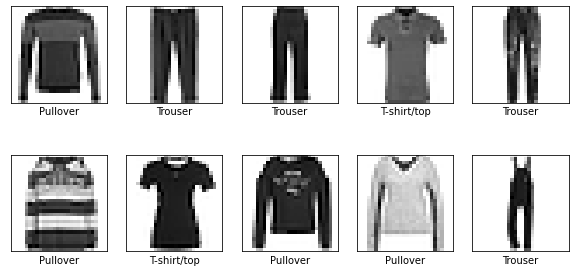

In [17]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
show_random_examples(x_preview, y_preview, y_preview)

<AxesSubplot:xlabel='Class', ylabel='Count'>

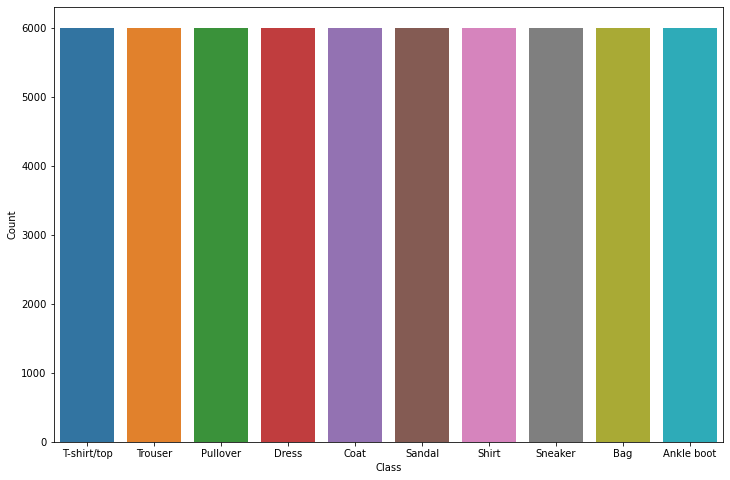

In [18]:
plt.figure(figsize = (12 ,8))
items = [{'Class': x, 'Count': y} for x, y in Counter(train_labels.ravel()).items()]
distribution = pd.DataFrame(items).sort_values(['Class'])
# sns.barplot(x=distribution.Class, y=distribution.Count);

ax = sns.barplot(x=distribution.Class, y=distribution.Count)
ax.set_xticklabels(class_names)
ax

## Create Validation Data Set

In [19]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train
                                                      ,y_train
                                                      ,test_size=.1
                                                      ,random_state=seed_val
                                                      ,shuffle=True)

## Confirm Datasets {Train, Validation, Test}

In [20]:
print(x_train.shape, x_valid.shape, x_test.shape)

(54000, 28, 28) (6000, 28, 28) (10000, 28, 28)


## Rescale Examples  {Train, Validation, Test}
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255

1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [21]:
x_train = x_train/255
x_valid = x_valid/255
x_test = x_test/255

# STOP INITIALIZATION HERE
# ----------------------------------------
# ----------------------------------------
# ----------------------------------------
# ----------------------------------------

## Experiment 1

- Conv2D with 3 Layers (128, 256, 512, Kernel size 3, Padding same)
- DNN with 2 layers (384, 768)

In [25]:
k.clear_session()
model_01 = Sequential([
  Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
  MaxPool2D((2, 2), strides=2),
  Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2), strides=2),
  Conv2D(filters=512, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2), strides=2),
  Flatten(),
  Dense(units=384, activation=tf.nn.relu),
  Dense(units=768, activation=tf.nn.relu),
  Dense(units=10, activation=tf.nn.softmax)       
])

In [26]:
model_01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 256)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 512)         1180160   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 512)        0

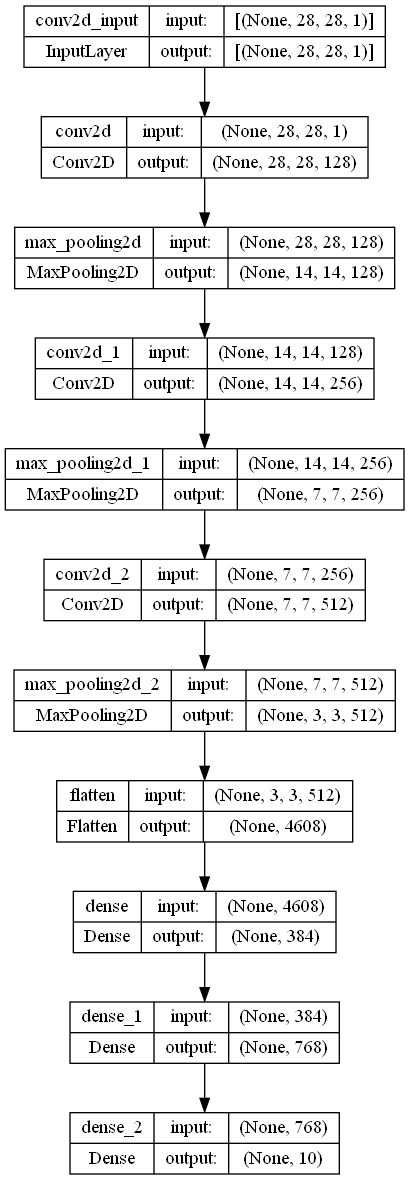

In [27]:
keras.utils.plot_model(model_01, "FASHION-MNIST_EXP-01.png", show_shapes=True) 

In [28]:
model_01.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [29]:
history_01 = model_01.fit(x_train
                    ,y_train
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid, y_valid)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("FASHION-MNIST_EXP-01.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
                    ]                                                                                                           
                   )

Epoch 1/200
844/844 [==============================] - 10s 10ms/step - loss: 0.4374 - accuracy: 0.8374 - val_loss: 0.2852 - val_accuracy: 0.8925
Epoch 2/200
844/844 [==============================] - 9s 10ms/step - loss: 0.2606 - accuracy: 0.9040 - val_loss: 0.2562 - val_accuracy: 0.9040
Epoch 3/200
844/844 [==============================] - 9s 11ms/step - loss: 0.2149 - accuracy: 0.9213 - val_loss: 0.2265 - val_accuracy: 0.9162
Epoch 4/200
844/844 [==============================] - 8s 10ms/step - loss: 0.1836 - accuracy: 0.9316 - val_loss: 0.2084 - val_accuracy: 0.9255
Epoch 5/200
844/844 [==============================] - 8s 9ms/step - loss: 0.1546 - accuracy: 0.9424 - val_loss: 0.2166 - val_accuracy: 0.9237
Epoch 6/200
844/844 [==============================] - 8s 10ms/step - loss: 0.1298 - accuracy: 0.9516 - val_loss: 0.2281 - val_accuracy: 0.9260
Epoch 7/200
844/844 [==============================] - 8s 10ms/step - loss: 0.1091 - accuracy: 0.9585 - val_loss: 0.2382 - val_accuracy:

In [22]:
model_01 = tf.keras.models.load_model("FASHION-MNIST_EXP-01.h5")
print(f"Test acc: {model_01.evaluate(x_test, y_test)[1]:.3f}")

313/313 [==============================] - 6s 4ms/step - loss: 0.2288 - accuracy: 0.9190
Test acc: 0.919


In [31]:
history_01_dict = history_01.history
history_01_df=pd.DataFrame(history_01_dict)
history_01_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
9   0.067     0.974     0.277         0.924
10  0.058     0.978     0.302         0.925
11  0.049     0.983     0.335         0.930
12  0.048     0.983     0.353         0.925
13  0.041     0.985     0.388         0.925

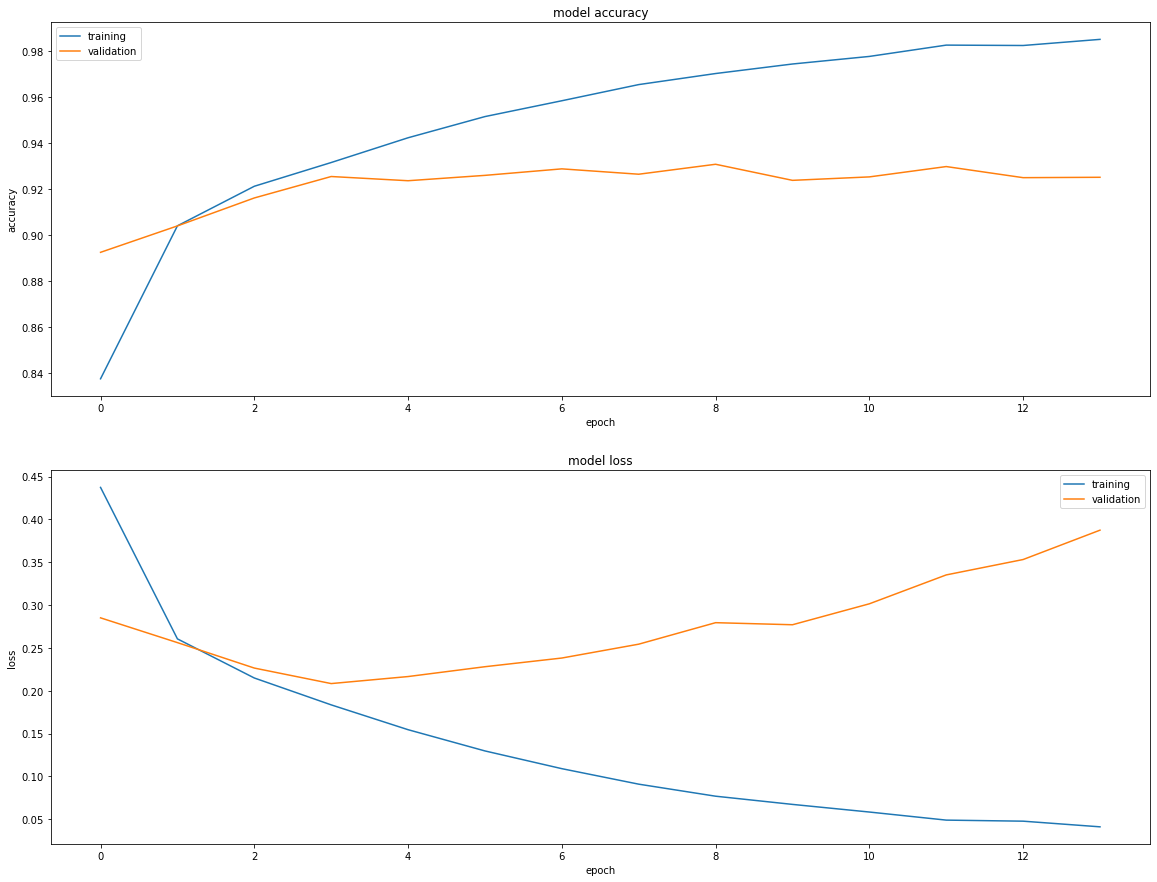

In [32]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_01.history['accuracy'], history_01.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_01.history['loss'], history_01.history['val_loss'], 'loss', 212)

In [33]:
pred_01 = model_01.predict(x_test)
pred_01_cm=np.argmax(pred_01, axis=1)
print_validation_report(y_test, pred_01_cm)

313/313 [==============================] - 1s 3ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1000
           1       1.00      0.99      0.99      1000
           2       0.86      0.90      0.88      1000
           3       0.93      0.93      0.93      1000
           4       0.86      0.90      0.88      1000
           5       0.99      0.98      0.99      1000
           6       0.82      0.67      0.74      1000
           7       0.94      0.99      0.96      1000
           8       0.99      0.98      0.98      1000
           9       0.99      0.94      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Accuracy Score: 0.919
Root Mean Square Error: 1.1237882362794158


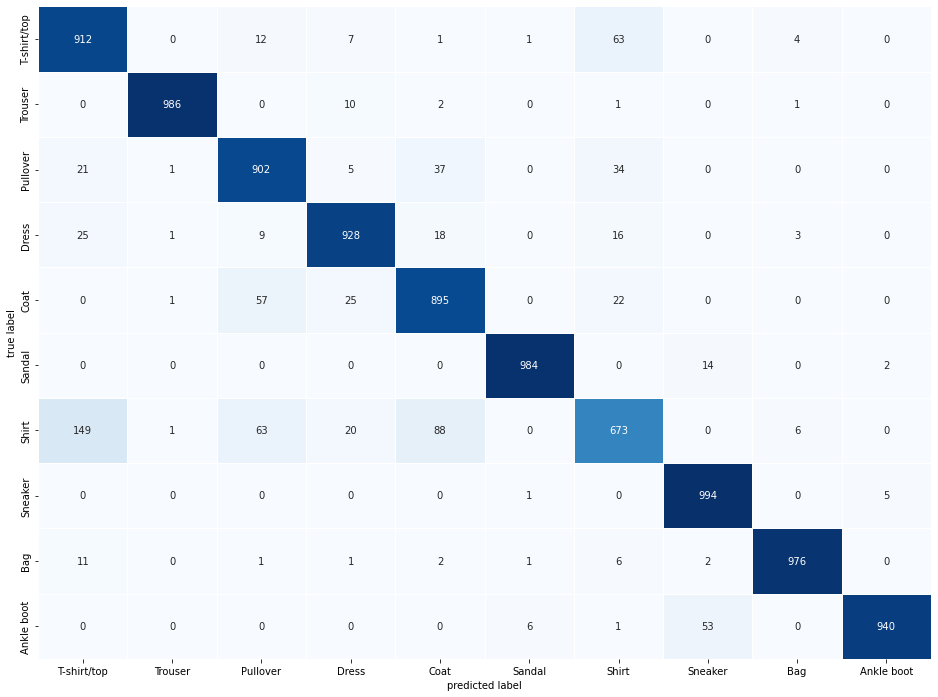

In [34]:
plot_confusion_matrix(y_test,pred_01_cm)

In [35]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred_01[0:20], columns = class_names)
df.style.format("{:.2%}").background_gradient(cmap=cm)

In [23]:
layer_names = []
for layer in model_01.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'conv2d_2',
 'max_pooling2d_2',
 'flatten',
 'dense',
 'dense_1',
 'dense_2']

In [24]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model_01.layers[:10]]
# Creates a model that will return these outputs, given the model input:
activation_model_01 = tf.keras.models.Model(inputs=model_01.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations_01 = activation_model_01.predict(x_valid[:2000])
dense_layer_activations_01 = activations_01[-3]
output_layer_activations_01 = activations_01[-1]

63/63 [==============================] - 1s 7ms/step


In [25]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_01 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_01 = tsne_01.fit_transform(dense_layer_activations_01)

# Scaling
tsne_results_01 = (tsne_results_01 - tsne_results_01.min()) / (tsne_results_01.max() - tsne_results_01.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.106s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.816705


C:\Users\Reed\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.554615
[t-SNE] KL divergence after 300 iterations: 1.097022


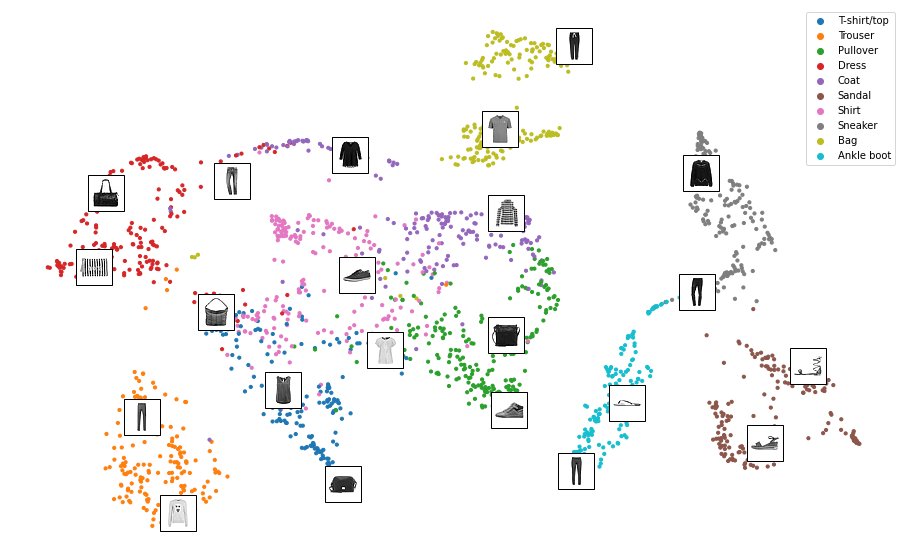

In [26]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results_01[:,0],tsne_results_01[:,1], c=y_valid[:2000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_01):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## Experiment 2

- Conv2D with 3 Layers (128, 256, 512, Kernel size 3, Padding same)
- DNN with 2 layers (384, 768)
- L2 Regularization(0.001)


In [27]:
k.clear_session()
model_02 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='Same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
  MaxPool2D((2, 2),strides=2),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Flatten(),
  Dense(units=384, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  Dense(units=768, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  Dense(units=10, activation=tf.nn.softmax)       
])

In [28]:
model_02.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 256)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 512)         1180160   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 512)        0

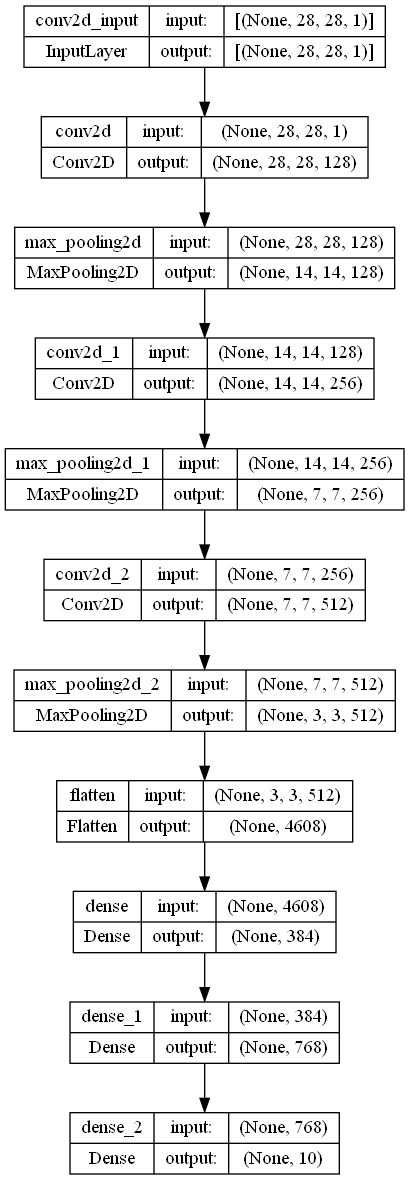

In [29]:
keras.utils.plot_model(model_02, "FASHION-MNIST_EXP-02.png", show_shapes=True) 

In [30]:
model_02.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [31]:
history_02 = model_02.fit(x_train
                    ,y_train
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid, y_valid)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("FASHION-MNIST_EXP-02.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
                    ]                                                                                                           
                   )

Epoch 1/200
844/844 [==============================] - 10s 10ms/step - loss: 0.6354 - accuracy: 0.8364 - val_loss: 0.4049 - val_accuracy: 0.8875
Epoch 2/200
844/844 [==============================] - 9s 10ms/step - loss: 0.3519 - accuracy: 0.8976 - val_loss: 0.3232 - val_accuracy: 0.9033
Epoch 3/200
844/844 [==============================] - 9s 10ms/step - loss: 0.2886 - accuracy: 0.9150 - val_loss: 0.2812 - val_accuracy: 0.9157
Epoch 4/200
844/844 [==============================] - 8s 10ms/step - loss: 0.2535 - accuracy: 0.9260 - val_loss: 0.2629 - val_accuracy: 0.9202
Epoch 5/200
844/844 [==============================] - 8s 10ms/step - loss: 0.2235 - accuracy: 0.9340 - val_loss: 0.2579 - val_accuracy: 0.9162
Epoch 6/200
844/844 [==============================] - 9s 10ms/step - loss: 0.1999 - accuracy: 0.9423 - val_loss: 0.2451 - val_accuracy: 0.9280
Epoch 7/200
844/844 [==============================] - 9s 10ms/step - loss: 0.1783 - accuracy: 0.9484 - val_loss: 0.2393 - val_accuracy

In [32]:
model_02 = tf.keras.models.load_model("FASHION-MNIST_EXP-02.h5") # L2 reg 0.001
print(f"Test acc: {model_02.evaluate(x_test, y_test)[1]:.3f}")

313/313 [==============================] - 2s 5ms/step - loss: 0.2666 - accuracy: 0.9183
Test acc: 0.918


In [33]:
history_02_dict = history_02.history
history_02_df=pd.DataFrame(history_02_dict)
history_02_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
12  0.096     0.977     0.289         0.927
13  0.088     0.979     0.289         0.931
14  0.084     0.980     0.313         0.929
15  0.077     0.983     0.299         0.930
16  0.070     0.985     0.333         0.929

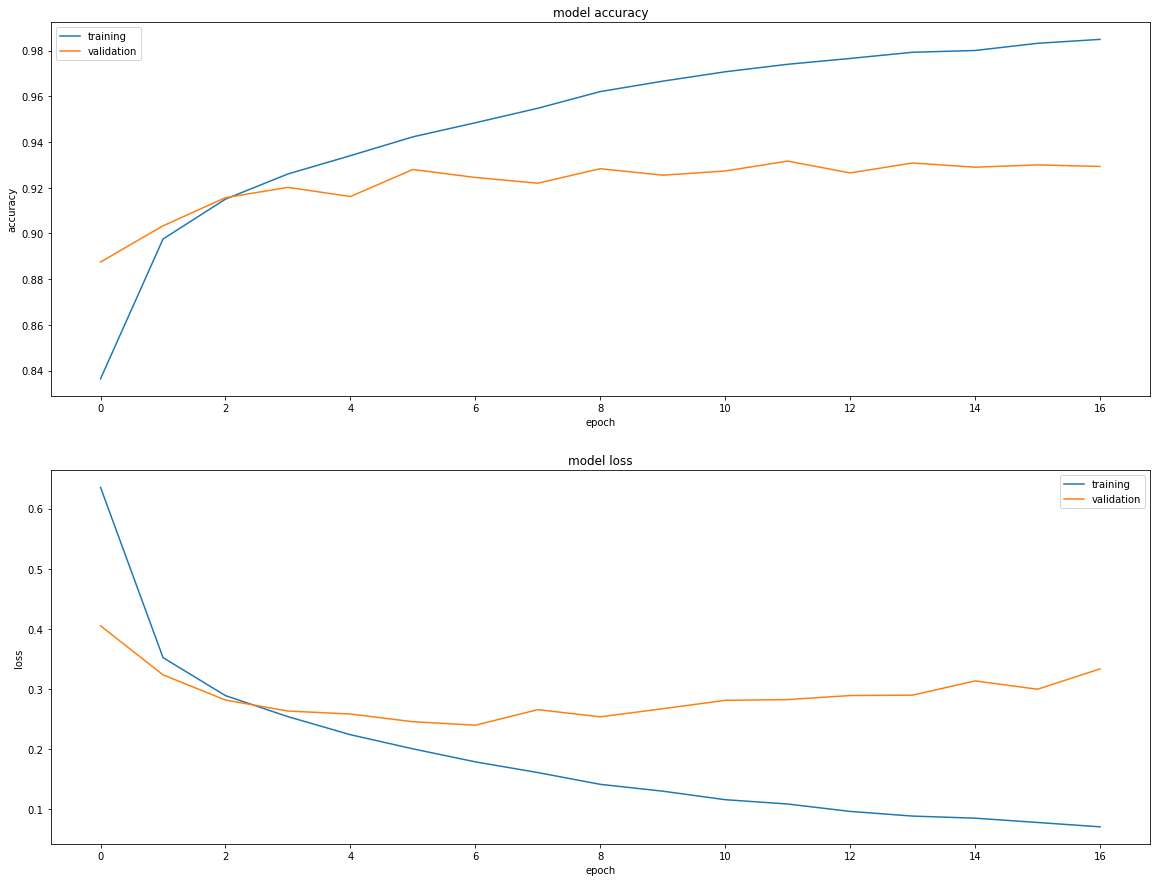

In [34]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_02.history['accuracy'], history_02.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_02.history['loss'], history_02.history['val_loss'], 'loss', 212)

In [35]:
pred_02 = model_02.predict(x_test)
pred_02_cm=np.argmax(pred_02, axis=1)
print_validation_report(y_test, pred_02_cm)

313/313 [==============================] - 1s 3ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1000
           1       0.99      0.99      0.99      1000
           2       0.91      0.84      0.87      1000
           3       0.93      0.94      0.93      1000
           4       0.82      0.91      0.86      1000
           5       0.98      0.99      0.99      1000
           6       0.76      0.75      0.76      1000
           7       0.95      0.98      0.96      1000
           8       0.99      0.98      0.99      1000
           9       0.99      0.95      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Accuracy Score: 0.9183
Root Mean Square Error: 1.095764573254675


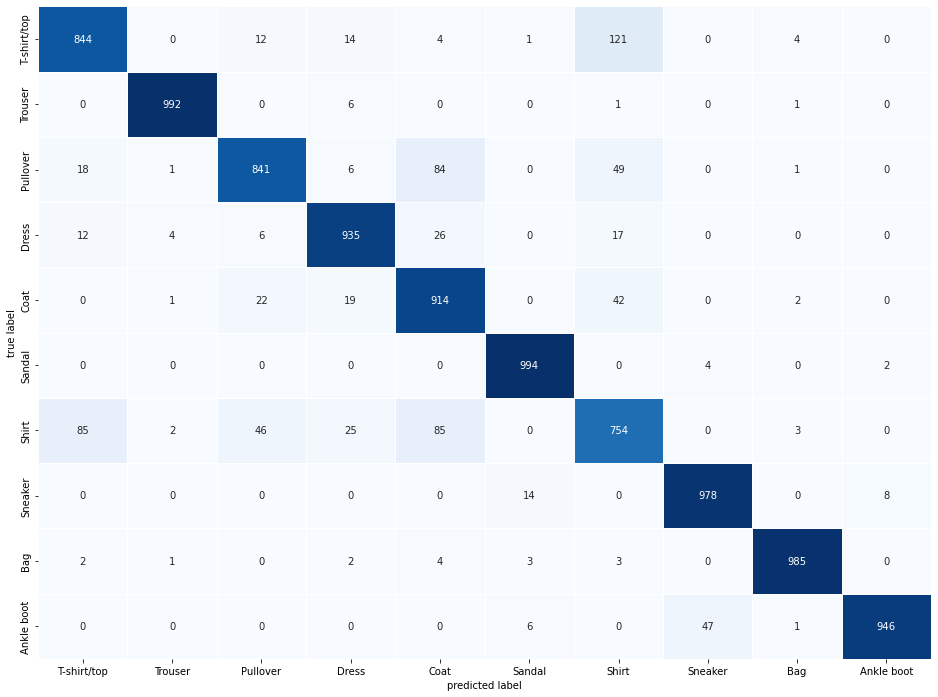

In [36]:
plot_confusion_matrix(y_test,pred_02_cm)

In [37]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred_02[0:20], columns = class_names)
df.style.format("{:.2%}").background_gradient(cmap=cm)

In [38]:
layer_names = []
for layer in model_02.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'conv2d_2',
 'max_pooling2d_2',
 'flatten',
 'dense',
 'dense_1',
 'dense_2']

In [39]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model_02.layers[:20]]
# Creates a model that will return these outputs, given the model input:
activation_model_02 = tf.keras.models.Model(inputs=model_02.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations_02 = activation_model_02.predict(x_valid[:2000])
dense_layer_activations_02 = activations_02[-3]
output_layer_activations_02 = activations_02[-1]

63/63 [==============================] - 1s 7ms/step


In [40]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_02 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_02 = tsne_02.fit_transform(dense_layer_activations_02)

# Scaling
tsne_results_02 = (tsne_results_02 - tsne_results_02.min()) / (tsne_results_02.max() - tsne_results_02.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.116s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.412556


C:\Users\Reed\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.315712
[t-SNE] KL divergence after 300 iterations: 1.029453


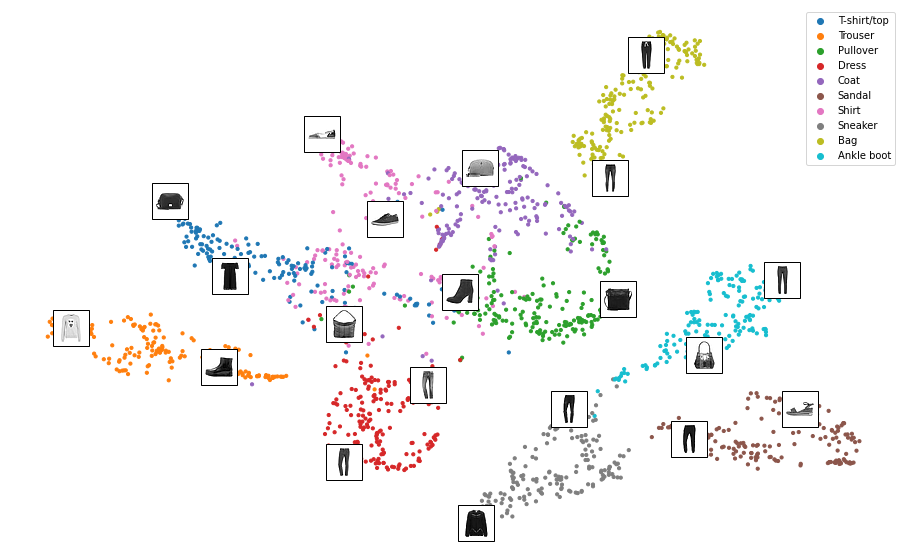

In [41]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results_02[:,0],tsne_results_02[:,1], c=y_valid[:2000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_02):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## Experiment 3

- Conv2D with 3 Layers (128, 256, 512, Kernel size 3, Padding same)
- DNN with 2 layers (384, 768)
- Batch Normalization
- Dropout(0.3)
- L2 Regularization(0.001)

In [42]:
k.clear_session()
model_03 = Sequential([
  Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.3),
  Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.3),
  Conv2D(filters=512, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.3),    
  Flatten(),
  Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=768,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)       
])

In [43]:
model_03.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 128)      512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 256)        0

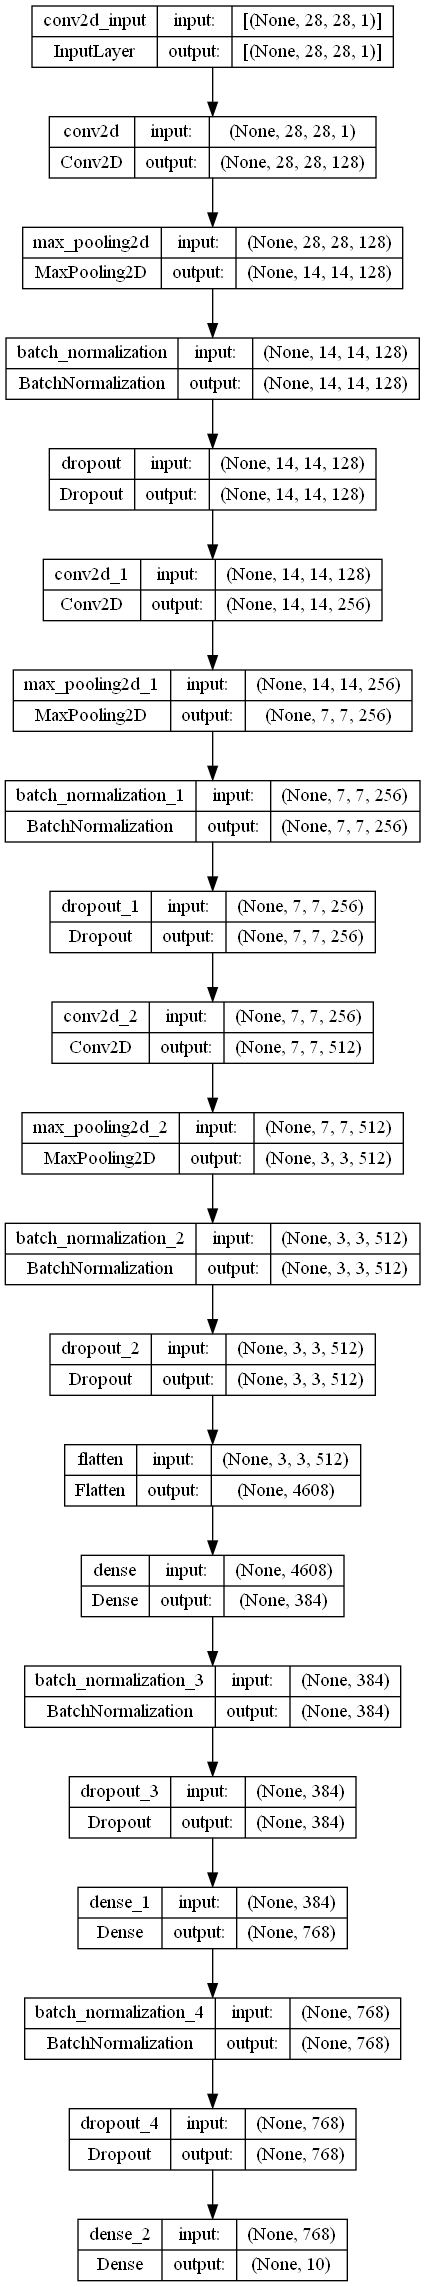

In [44]:
keras.utils.plot_model(model_03, "FASHION-MNIST_EXP-03.png", show_shapes=True) 

In [45]:
model_03.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [46]:
history_03 = model_03.fit(x_train
                    ,y_train
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid, y_valid)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("FASHION-MNIST_EXP-03.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
                    ]                                                                                                           
                   )

Epoch 1/200
844/844 [==============================] - 14s 15ms/step - loss: 1.4748 - accuracy: 0.8148 - val_loss: 0.8745 - val_accuracy: 0.8792
Epoch 2/200
844/844 [==============================] - 12s 14ms/step - loss: 0.7264 - accuracy: 0.8765 - val_loss: 0.6190 - val_accuracy: 0.8782
Epoch 3/200
844/844 [==============================] - 12s 15ms/step - loss: 0.5658 - accuracy: 0.8876 - val_loss: 0.5002 - val_accuracy: 0.9050
Epoch 4/200
844/844 [==============================] - 12s 14ms/step - loss: 0.5358 - accuracy: 0.8940 - val_loss: 0.4906 - val_accuracy: 0.9092
Epoch 5/200
844/844 [==============================] - 12s 14ms/step - loss: 0.5227 - accuracy: 0.8985 - val_loss: 0.5313 - val_accuracy: 0.8902
Epoch 6/200
844/844 [==============================] - 11s 14ms/step - loss: 0.5139 - accuracy: 0.9040 - val_loss: 0.5002 - val_accuracy: 0.9078
Epoch 7/200
844/844 [==============================] - 12s 14ms/step - loss: 0.5099 - accuracy: 0.9064 - val_loss: 0.4685 - val_ac

In [51]:
model_03 = tf.keras.models.load_model("FASHION-MNIST_EXP-03.h5") # batch normalization, L2 reg 0.001, dropout 0.3
print(f"Test acc: {model_03.evaluate(x_test, y_test)[1]:.3f}")

313/313 [==============================] - 2s 6ms/step - loss: 0.4229 - accuracy: 0.9212
Test acc: 0.921


In [64]:
history_03_dict = history_03.history
history_03_df=pd.DataFrame(history_03_dict)
history_03_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
12  0.431     0.926     0.439         0.919
13  0.432     0.926     0.415         0.922
14  0.415     0.928     0.424         0.922
15  0.400     0.932     0.427         0.918
16  0.383     0.933     0.409         0.922

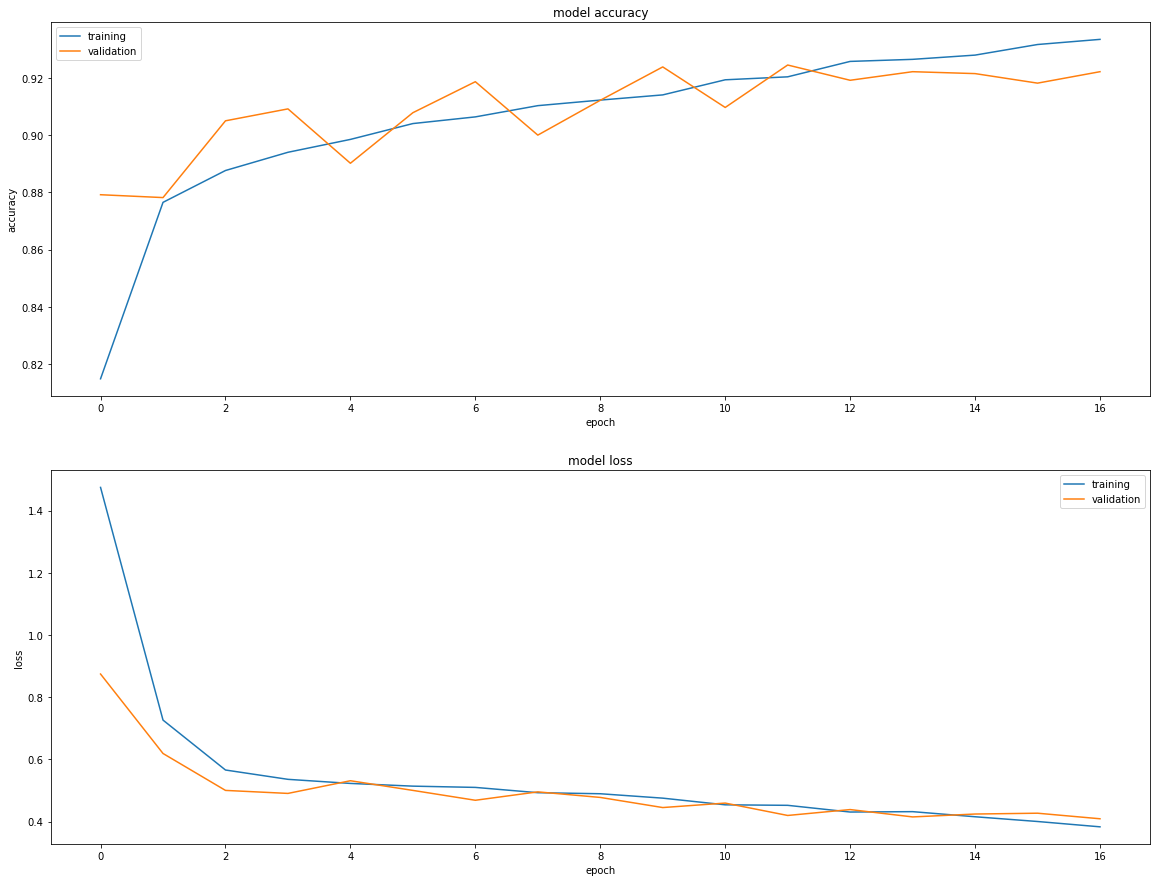

In [80]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_03.history['accuracy'], history_03.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_03.history['loss'], history_03.history['val_loss'], 'loss', 212)

In [73]:
pred_03 = model_03.predict(x_test)
pred_03_cm=np.argmax(pred_03, axis=1)
print_validation_report(y_test, pred_03_cm)

313/313 [==============================] - 1s 4ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1000
           1       1.00      0.97      0.99      1000
           2       0.82      0.94      0.88      1000
           3       0.90      0.94      0.92      1000
           4       0.90      0.85      0.87      1000
           5       0.99      0.98      0.99      1000
           6       0.86      0.70      0.77      1000
           7       0.93      0.99      0.96      1000
           8       0.99      0.99      0.99      1000
           9       0.99      0.94      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Accuracy Score: 0.9212
Root Mean Square Error: 1.0446051885760477


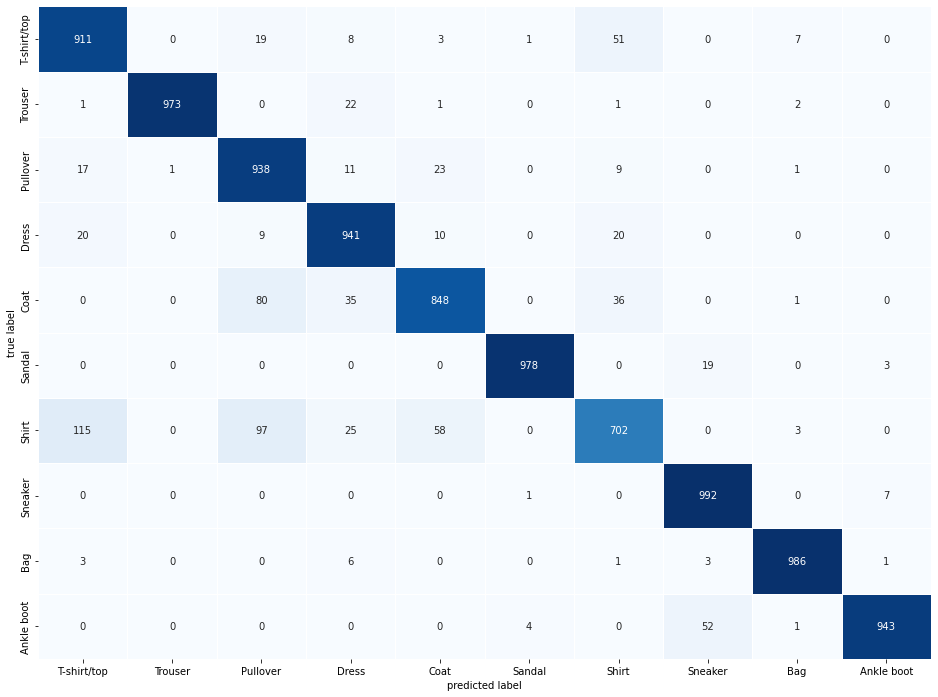

In [74]:
plot_confusion_matrix(y_test,pred_03_cm)

In [75]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred_03[0:20], columns = class_names)
df.style.format("{:.2%}").background_gradient(cmap=cm)

In [76]:
layer_names = []
for layer in model_03.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'batch_normalization',
 'dropout',
 'conv2d_1',
 'max_pooling2d_1',
 'batch_normalization_1',
 'dropout_1',
 'conv2d_2',
 'max_pooling2d_2',
 'batch_normalization_2',
 'dropout_2',
 'flatten',
 'dense',
 'batch_normalization_3',
 'dropout_3',
 'dense_1',
 'batch_normalization_4',
 'dropout_4',
 'dense_2']

In [77]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model_03.layers[:20]]
# Creates a model that will return these outputs, given the model input:
activation_model_03 = tf.keras.models.Model(inputs=model_03.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations_03 = activation_model_03.predict(x_valid[:2000])
dense_layer_activations_03 = activations_03[-3]
output_layer_activations_03 = activations_03[-1]

63/63 [==============================] - 1s 6ms/step


In [78]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_03 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_03 = tsne_03.fit_transform(dense_layer_activations_03)

# Scaling
tsne_results_03 = (tsne_results_03 - tsne_results_03.min()) / (tsne_results_03.max() - tsne_results_03.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.119s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.903120


C:\Users\Reed\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.764778
[t-SNE] KL divergence after 300 iterations: 0.960072


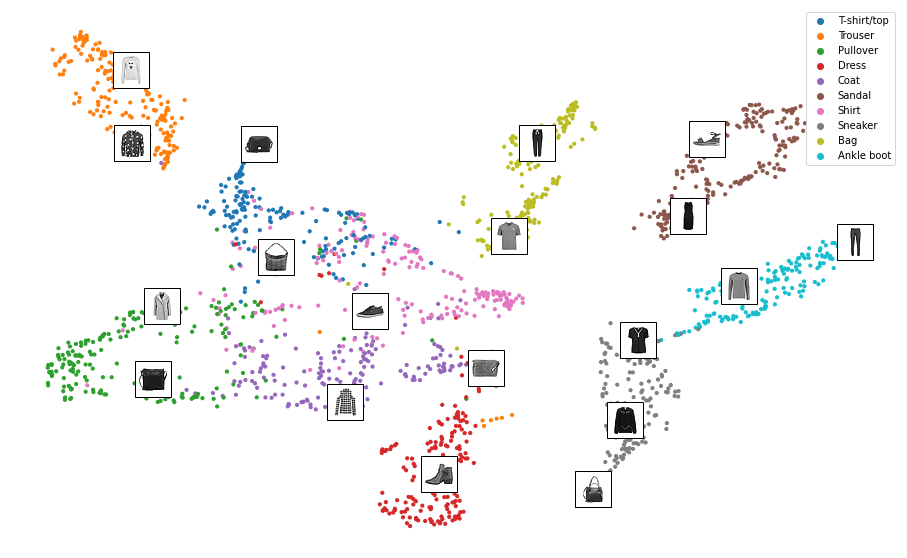

In [79]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results_03[:,0],tsne_results_03[:,1], c=y_valid[:2000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_03):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## Experiment 4

- Conv2D with 3 Layers (128, 256, 512, Kernel size 3, Padding same)
- DNN with 2 layers (384, 768)
- Batch Normalization
- Dropout(0.2)
- L2 Regularization(0.001)

In [81]:
k.clear_session()
model_04 = Sequential([
  Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.2),
  Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.2),
  Conv2D(filters=512, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.2),    
  Flatten(),
  Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.2),
  Dense(units=768,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.2),
  Dense(units=10, activation=tf.nn.softmax)       
])

In [82]:
model_04.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 128)      512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 256)        0

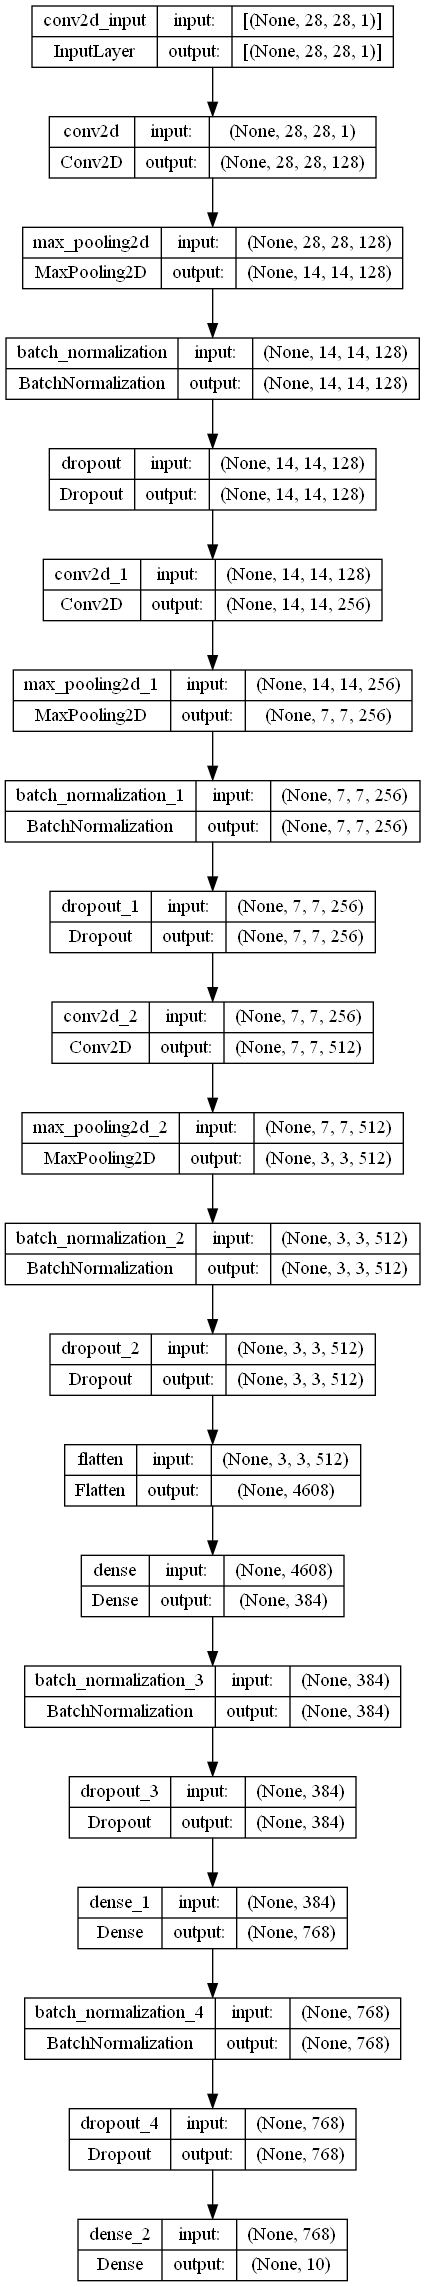

In [83]:
keras.utils.plot_model(model_04, "FASHION-MNIST_EXP-04.png", show_shapes=True) 

In [84]:
model_04.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [85]:
history_04 = model_04.fit(x_train
                    ,y_train
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid, y_valid)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("FASHION-MNIST_EXP-04.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
                    ]                                                                                                           
                   )

Epoch 1/200
844/844 [==============================] - 14s 15ms/step - loss: 1.3481 - accuracy: 0.8336 - val_loss: 0.7920 - val_accuracy: 0.8760
Epoch 2/200
844/844 [==============================] - 12s 15ms/step - loss: 0.6295 - accuracy: 0.8832 - val_loss: 0.5615 - val_accuracy: 0.8758
Epoch 3/200
844/844 [==============================] - 12s 14ms/step - loss: 0.4945 - accuracy: 0.8942 - val_loss: 0.4816 - val_accuracy: 0.8978
Epoch 4/200
844/844 [==============================] - 12s 15ms/step - loss: 0.4718 - accuracy: 0.9015 - val_loss: 0.4794 - val_accuracy: 0.8997
Epoch 5/200
844/844 [==============================] - 11s 14ms/step - loss: 0.4548 - accuracy: 0.9058 - val_loss: 0.5097 - val_accuracy: 0.8835
Epoch 6/200
844/844 [==============================] - 12s 15ms/step - loss: 0.4363 - accuracy: 0.9139 - val_loss: 0.4569 - val_accuracy: 0.9005
Epoch 7/200
844/844 [==============================] - 12s 14ms/step - loss: 0.4304 - accuracy: 0.9158 - val_loss: 0.4309 - val_ac

In [329]:
model_04 = tf.keras.models.load_model("FASHION-MNIST_EXP-04.h5") # batch normalization, L2 reg 0.001, dropout 0.2
print(f"Test acc: {model_04.evaluate(x_test, y_test)[1]:.3f}")

313/313 [==============================] - 2s 5ms/step - loss: 0.3310 - accuracy: 0.9245
Test acc: 0.924


In [87]:
history_04_dict = history_04.history
history_04_df=pd.DataFrame(history_04_dict)
history_04_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
16  0.262     0.949     0.341         0.921
17  0.248     0.954     0.336         0.926
18  0.244     0.953     0.585         0.871
19  0.231     0.956     0.308         0.929
20  0.226     0.957     0.384         0.911

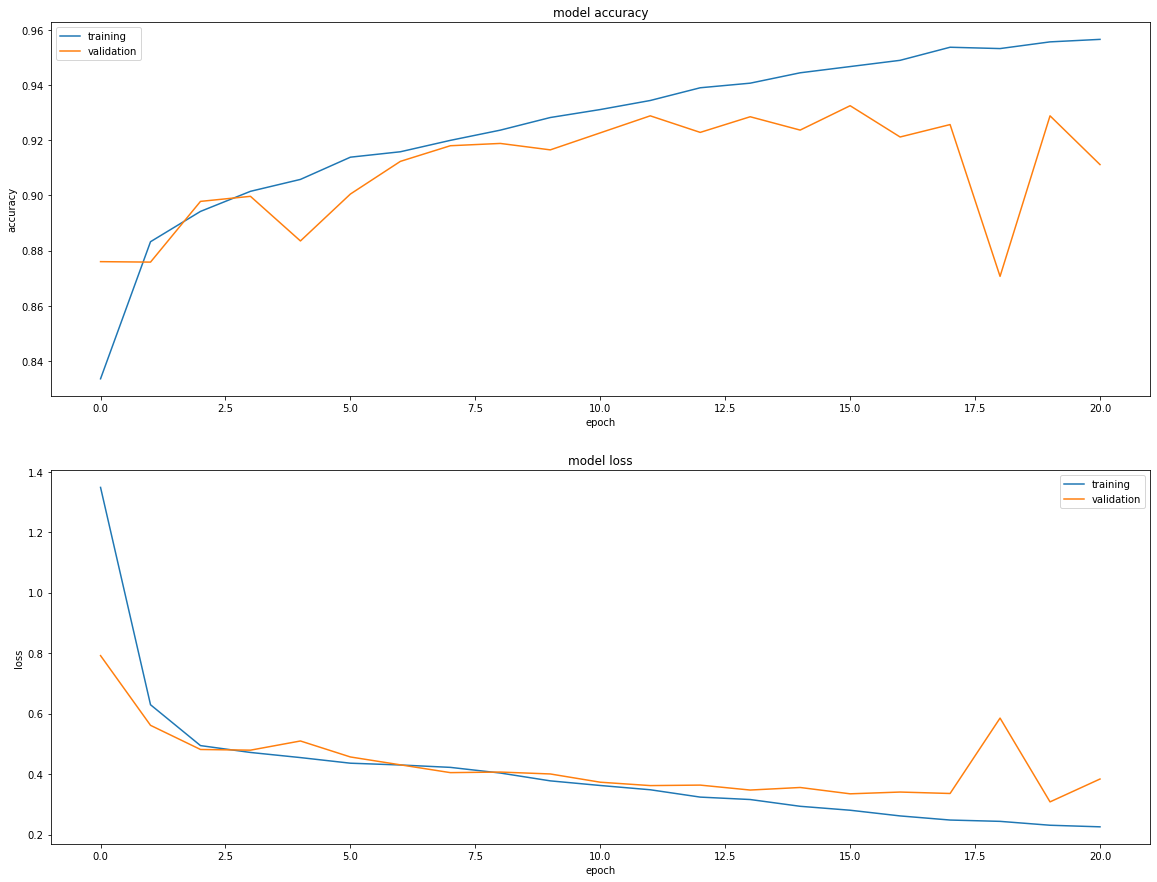

In [88]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_04.history['accuracy'], history_04.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_04.history['loss'], history_04.history['val_loss'], 'loss', 212)

In [330]:
pred_04 = model_04.predict(x_test)
pred_04_cm=np.argmax(pred_04, axis=1)
print_validation_report(y_test, pred_04_cm)

313/313 [==============================] - 1s 4ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1000
           1       1.00      0.98      0.99      1000
           2       0.92      0.87      0.89      1000
           3       0.90      0.94      0.92      1000
           4       0.87      0.90      0.88      1000
           5       0.99      0.97      0.98      1000
           6       0.78      0.78      0.78      1000
           7       0.95      0.98      0.97      1000
           8       0.99      0.98      0.99      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Accuracy Score: 0.9245
Root Mean Square Error: 1.0295630140987


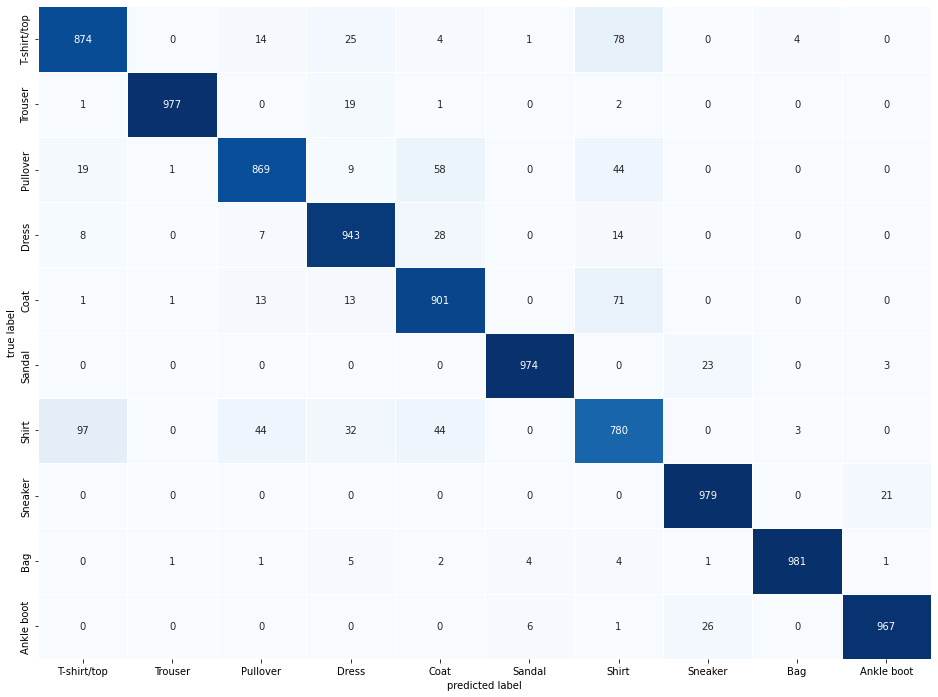

In [331]:
plot_confusion_matrix(y_test,pred_04_cm)

In [90]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred_04[0:20], columns = class_names)
df.style.format("{:.2%}").background_gradient(cmap=cm)

In [91]:
layer_names = []
for layer in model_04.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'batch_normalization',
 'dropout',
 'conv2d_1',
 'max_pooling2d_1',
 'batch_normalization_1',
 'dropout_1',
 'conv2d_2',
 'max_pooling2d_2',
 'batch_normalization_2',
 'dropout_2',
 'flatten',
 'dense',
 'batch_normalization_3',
 'dropout_3',
 'dense_1',
 'batch_normalization_4',
 'dropout_4',
 'dense_2']

In [92]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model_04.layers[:20]]
# Creates a model that will return these outputs, given the model input:
activation_model_04 = tf.keras.models.Model(inputs=model_04.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations_04 = activation_model_04.predict(x_valid[:2000])
dense_layer_activations_04 = activations_04[-3]
output_layer_activations_04 = activations_04[-1]

63/63 [==============================] - 1s 7ms/step


In [93]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_04 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_04 = tsne_04.fit_transform(dense_layer_activations_04)

# Scaling
tsne_results_04 = (tsne_results_04 - tsne_results_04.min()) / (tsne_results_04.max() - tsne_results_04.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.145s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.572267


C:\Users\Reed\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.119812
[t-SNE] KL divergence after 300 iterations: 0.994544


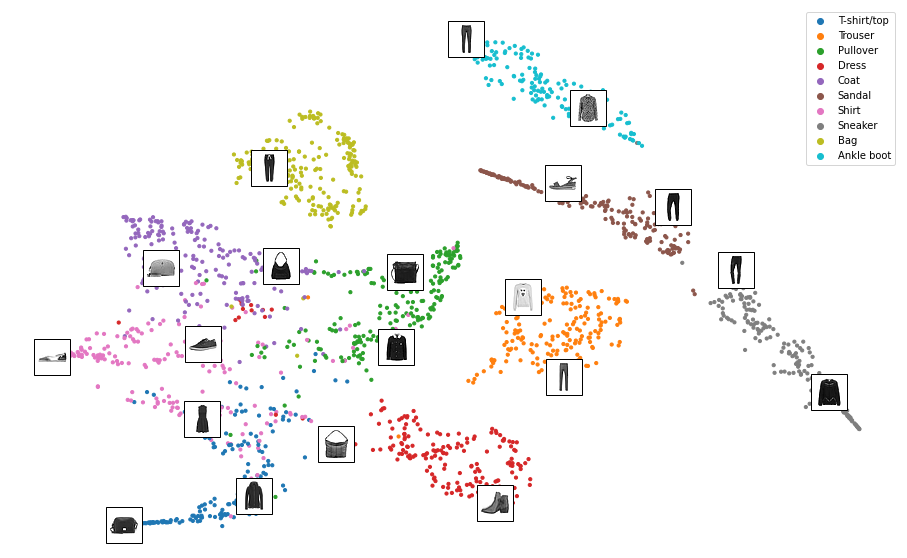

In [94]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results_04[:,0],tsne_results_04[:,1], c=y_valid[:2000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_04):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

# Exp04 (0.9297) > Exp03 (0.9263) accuracy, lower dropout to 0.1

## Experiment 5

- Conv2D with 3 Layers (128, 256, 512, Kernel size 3, Padding same)
- DNN with 2 layers (384, 768)
- Batch Normalization
- Dropout(0.1)
- L2 Regularization(0.001)

In [95]:
k.clear_session()
model_05 = Sequential([
  Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.1),
  Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.1),
  Conv2D(filters=512, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.1),    
  Flatten(),
  Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.1),
  Dense(units=768,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.1),
  Dense(units=10, activation=tf.nn.softmax)       
])

In [96]:
model_05.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 128)      512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 256)        0

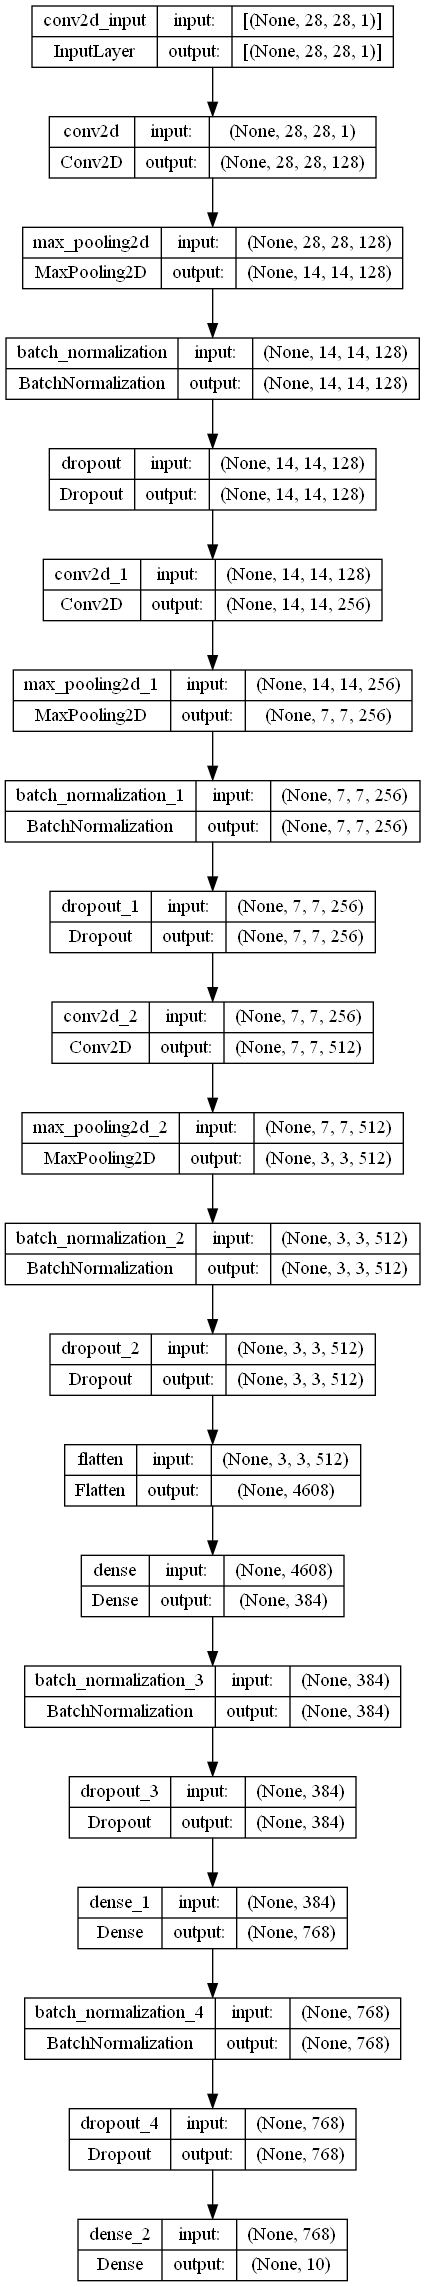

In [97]:
keras.utils.plot_model(model_05, "FASHION-MNIST_EXP-05.png", show_shapes=True) 

In [98]:
model_05.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [99]:
history_05 = model_05.fit(x_train
                    ,y_train
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid, y_valid)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("FASHION-MNIST_EXP-05.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
                    ]                                                                                                           
                   )

Epoch 1/200
844/844 [==============================] - 14s 15ms/step - loss: 1.2148 - accuracy: 0.8439 - val_loss: 0.7826 - val_accuracy: 0.8433
Epoch 2/200
844/844 [==============================] - 12s 14ms/step - loss: 0.5400 - accuracy: 0.8920 - val_loss: 0.4737 - val_accuracy: 0.8938
Epoch 3/200
844/844 [==============================] - 12s 14ms/step - loss: 0.4332 - accuracy: 0.9028 - val_loss: 0.4386 - val_accuracy: 0.8978
Epoch 4/200
844/844 [==============================] - 12s 14ms/step - loss: 0.4061 - accuracy: 0.9100 - val_loss: 0.4287 - val_accuracy: 0.9025
Epoch 5/200
844/844 [==============================] - 12s 14ms/step - loss: 0.3881 - accuracy: 0.9153 - val_loss: 0.4621 - val_accuracy: 0.8910
Epoch 6/200
844/844 [==============================] - 12s 14ms/step - loss: 0.3773 - accuracy: 0.9222 - val_loss: 0.4161 - val_accuracy: 0.9125
Epoch 7/200
844/844 [==============================] - 12s 14ms/step - loss: 0.3543 - accuracy: 0.9269 - val_loss: 0.3931 - val_ac

In [101]:
model_05 = tf.keras.models.load_model("FASHION-MNIST_EXP-05.h5") # batch normalization, L2 reg 0.001, dropout 0.2
print(f"Test acc: {model_05.evaluate(x_test, y_test)[1]:.3f}")

313/313 [==============================] - 2s 6ms/step - loss: 0.3061 - accuracy: 0.9254
Test acc: 0.925


In [102]:
history_05_dict = history_05.history
history_05_df=pd.DataFrame(history_05_dict)
history_05_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
14  0.194     0.960     0.308         0.928
15  0.178     0.965     0.296         0.930
16  0.170     0.967     0.311         0.926
17  0.157     0.970     0.317         0.925
18  0.153     0.970     0.331         0.925

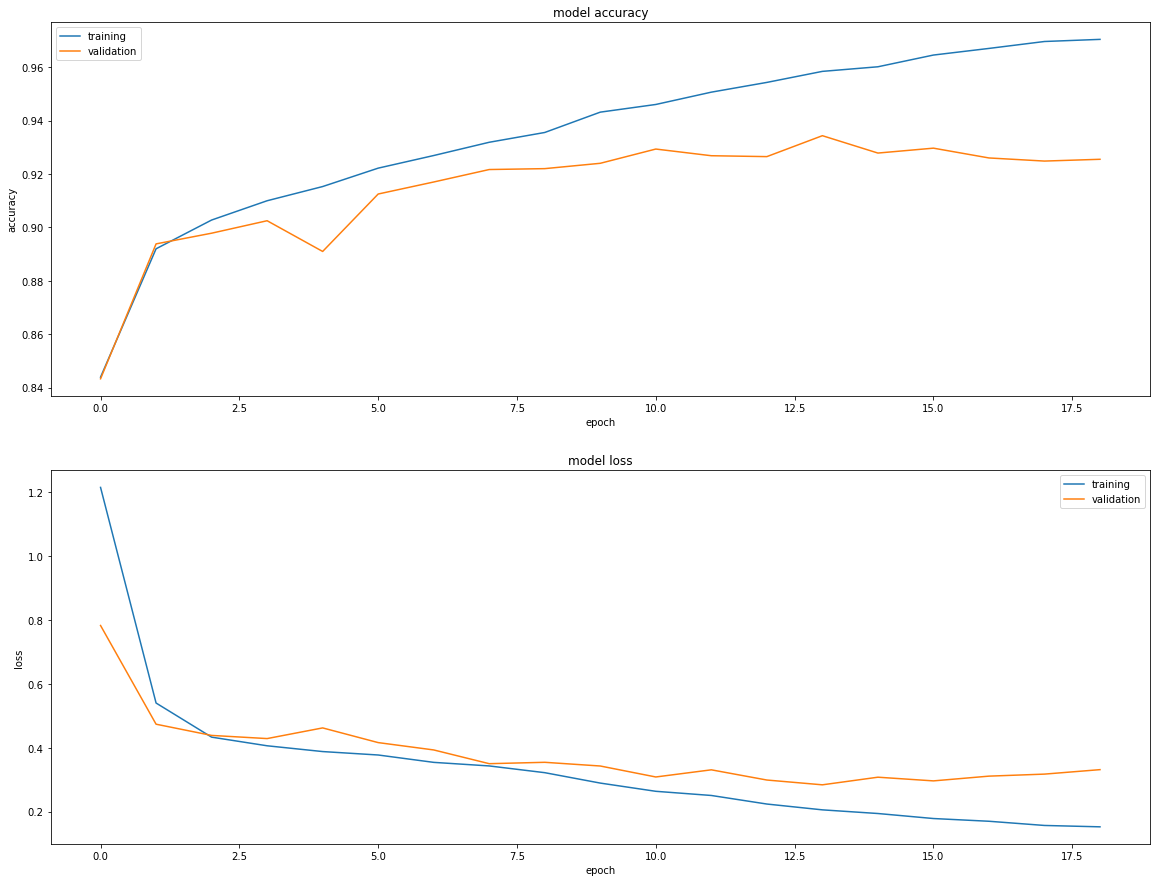

In [103]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_05.history['accuracy'], history_05.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_05.history['loss'], history_05.history['val_loss'], 'loss', 212)

In [104]:
pred_05 = model_05.predict(x_test)
pred_05_cm=np.argmax(pred_05, axis=1)
print_validation_report(y_test, pred_05_cm)

313/313 [==============================] - 1s 4ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      1000
           1       1.00      0.98      0.99      1000
           2       0.87      0.91      0.89      1000
           3       0.92      0.94      0.93      1000
           4       0.87      0.89      0.88      1000
           5       0.99      0.97      0.98      1000
           6       0.81      0.74      0.78      1000
           7       0.94      0.99      0.97      1000
           8       0.99      0.98      0.99      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

Accuracy Score: 0.9254
Root Mean Square Error: 1.0223502335305645


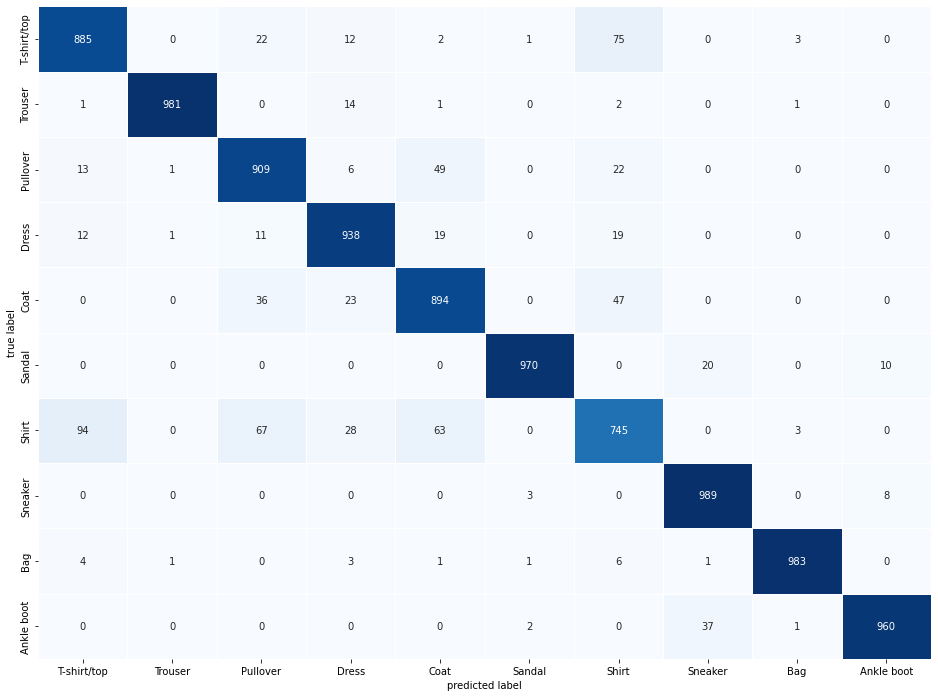

In [105]:
plot_confusion_matrix(y_test,pred_05_cm)

In [106]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred_05[0:20], columns = class_names)
df.style.format("{:.2%}").background_gradient(cmap=cm)

In [107]:
layer_names = []
for layer in model_05.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'batch_normalization',
 'dropout',
 'conv2d_1',
 'max_pooling2d_1',
 'batch_normalization_1',
 'dropout_1',
 'conv2d_2',
 'max_pooling2d_2',
 'batch_normalization_2',
 'dropout_2',
 'flatten',
 'dense',
 'batch_normalization_3',
 'dropout_3',
 'dense_1',
 'batch_normalization_4',
 'dropout_4',
 'dense_2']

In [108]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model_05.layers[:20]]
# Creates a model that will return these outputs, given the model input:
activation_model_05 = tf.keras.models.Model(inputs=model_05.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations_05 = activation_model_05.predict(x_valid[:2000])
dense_layer_activations_05 = activations_05[-3]
output_layer_activations_05 = activations_05[-1]

63/63 [==============================] - 1s 8ms/step


In [109]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_05 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_05 = tsne_05.fit_transform(dense_layer_activations_05)

# Scaling
tsne_results_05 = (tsne_results_05 - tsne_results_05.min()) / (tsne_results_05.max() - tsne_results_05.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.136s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.798853


C:\Users\Reed\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.980972
[t-SNE] KL divergence after 300 iterations: 0.995056


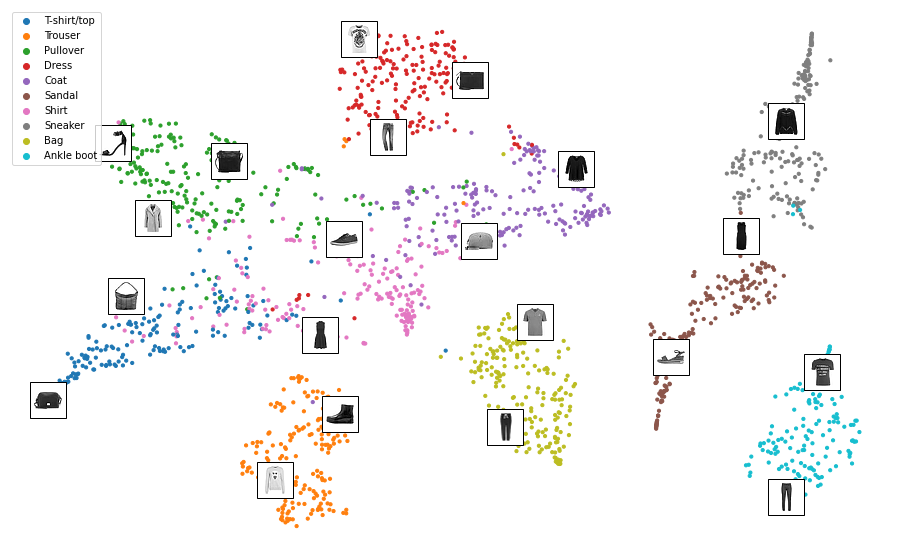

In [110]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results_05[:,0],tsne_results_05[:,1], c=y_valid[:2000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_05):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

### Exp 4 0.9297 > Exp 5 0.9277 accuracy, keep drouput at 0.2

Next: higher L2 regularization, 0.01

## Experiment 6

- Conv2D with 3 Layers (128, 256, 512, Kernel size 3, Padding same)
- DNN with 2 layers (384, 768)
- Batch Normalization
- Dropout(0.1)
- L2 Regularization(0.01)

In [134]:
k.clear_session()
model_06 = Sequential([
  Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.2),
  Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.2),
  Conv2D(filters=512, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.2),    
  Conv2D(filters=512, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.2),    
  Flatten(),
  Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.01)),
  BatchNormalization(),
  Dropout(0.2),
  Dense(units=768,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.01)),
  BatchNormalization(),
  Dropout(0.2),
  Dense(units=10, activation=tf.nn.softmax)       
])

In [135]:
model_06.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 128)      512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 256)        0

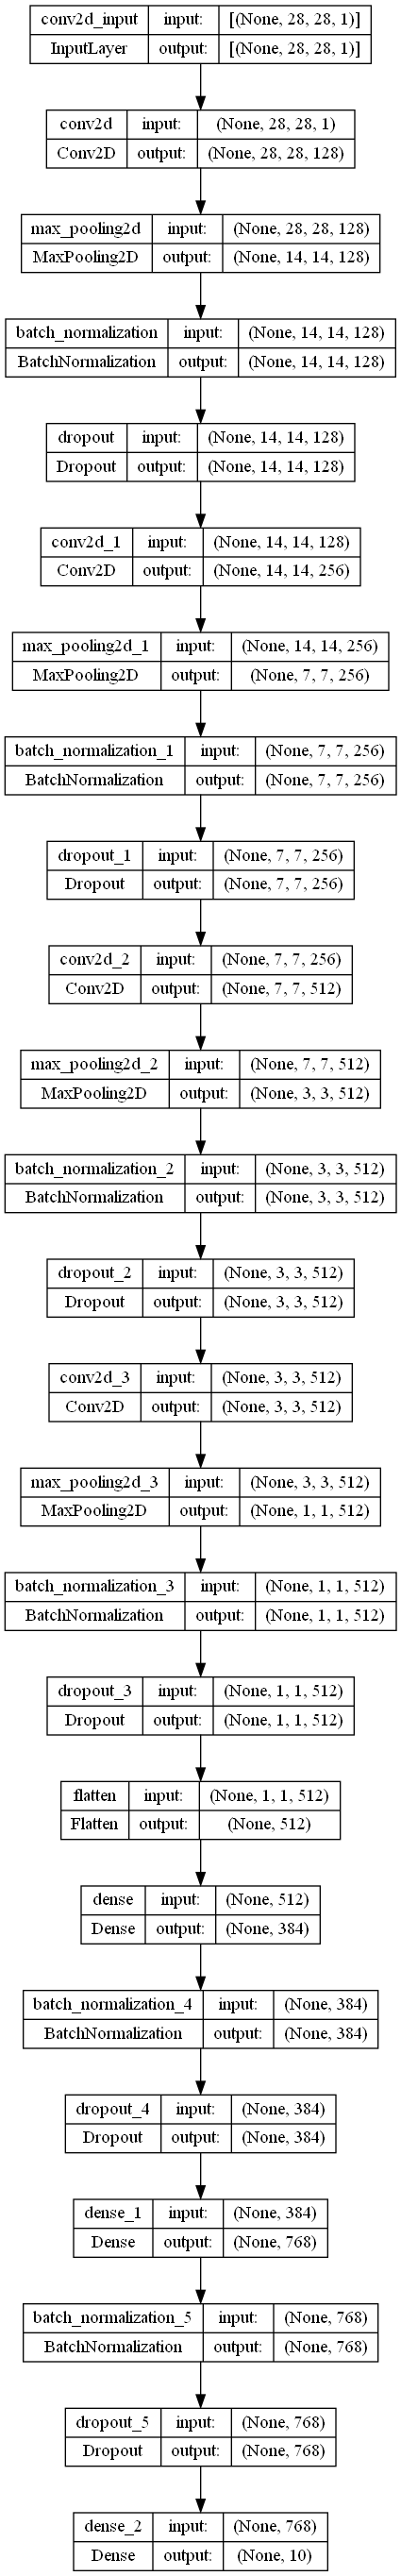

In [136]:
keras.utils.plot_model(model_06, "FASHION-MNIST_EXP-06.png", show_shapes=True) 

In [137]:
model_06.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [138]:
history_06 = model_06.fit(x_train
                    ,y_train
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid, y_valid)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("FASHION-MNIST_EXP-06-DO.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
                    ]                                                                                                           
                   )

Epoch 1/200
844/844 [==============================] - 17s 18ms/step - loss: 2.1471 - accuracy: 0.8342 - val_loss: 0.5840 - val_accuracy: 0.8463
Epoch 2/200
844/844 [==============================] - 15s 18ms/step - loss: 0.4639 - accuracy: 0.8875 - val_loss: 0.4166 - val_accuracy: 0.9047
Epoch 3/200
844/844 [==============================] - 15s 17ms/step - loss: 0.4157 - accuracy: 0.9003 - val_loss: 0.5578 - val_accuracy: 0.8520
Epoch 4/200
844/844 [==============================] - 15s 17ms/step - loss: 0.3977 - accuracy: 0.9102 - val_loss: 0.4185 - val_accuracy: 0.8993
Epoch 5/200
844/844 [==============================] - 15s 17ms/step - loss: 0.3564 - accuracy: 0.9172 - val_loss: 0.4255 - val_accuracy: 0.8968
Epoch 6/200
844/844 [==============================] - 15s 18ms/step - loss: 0.3393 - accuracy: 0.9247 - val_loss: 0.3401 - val_accuracy: 0.9192
Epoch 7/200
844/844 [==============================] - 15s 18ms/step - loss: 0.3181 - accuracy: 0.9307 - val_loss: 0.3378 - val_ac

In [139]:
model_06 = tf.keras.models.load_model("FASHION-MNIST_EXP-06.h5") # batch normalization, L2 reg 0.01, dropout 0.2
print(f"Test acc: {model_06.evaluate(x_test, y_test)[1]:.3f}")

313/313 [==============================] - 2s 6ms/step - loss: 0.3182 - accuracy: 0.9280
Test acc: 0.928


In [121]:
history_06_dict = history_06.history
history_06_df=pd.DataFrame(history_06_dict)
history_06_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
18  0.185     0.964     0.315         0.927
19  0.172     0.966     0.302         0.933
20  0.168     0.968     0.321         0.930
21  0.156     0.970     0.311         0.931
22  0.153     0.973     0.358         0.920

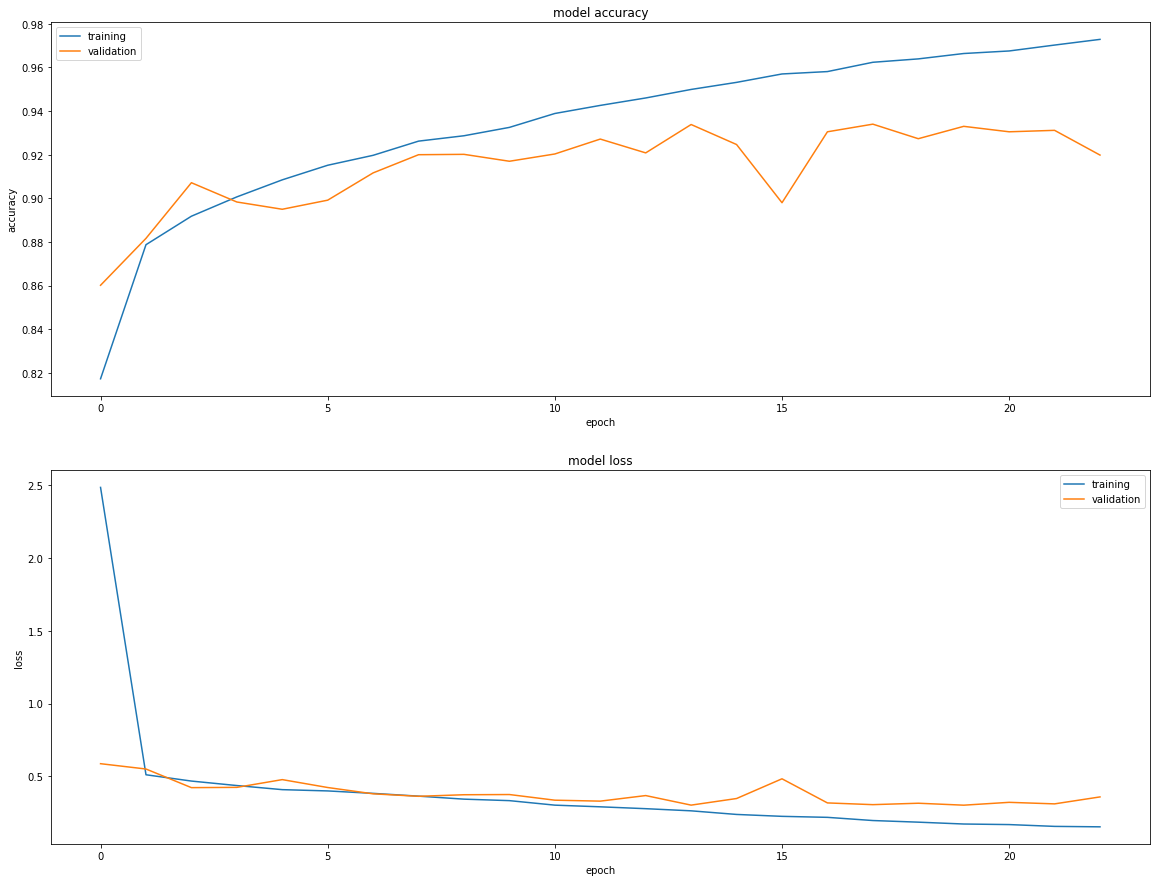

In [122]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_06.history['accuracy'], history_06.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_06.history['loss'], history_06.history['val_loss'], 'loss', 212)

In [123]:
pred_06 = model_06.predict(x_test)
pred_06_cm=np.argmax(pred_06, axis=1)
print_validation_report(y_test, pred_06_cm)

313/313 [==============================] - 1s 4ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.89      0.86      0.88      1000
           1       1.00      0.98      0.99      1000
           2       0.93      0.88      0.90      1000
           3       0.90      0.94      0.92      1000
           4       0.90      0.89      0.89      1000
           5       0.98      0.99      0.99      1000
           6       0.77      0.81      0.79      1000
           7       0.98      0.96      0.97      1000
           8       0.99      0.98      0.99      1000
           9       0.96      0.98      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

Accuracy Score: 0.928
Root Mean Square Error: 1.0185283501208988


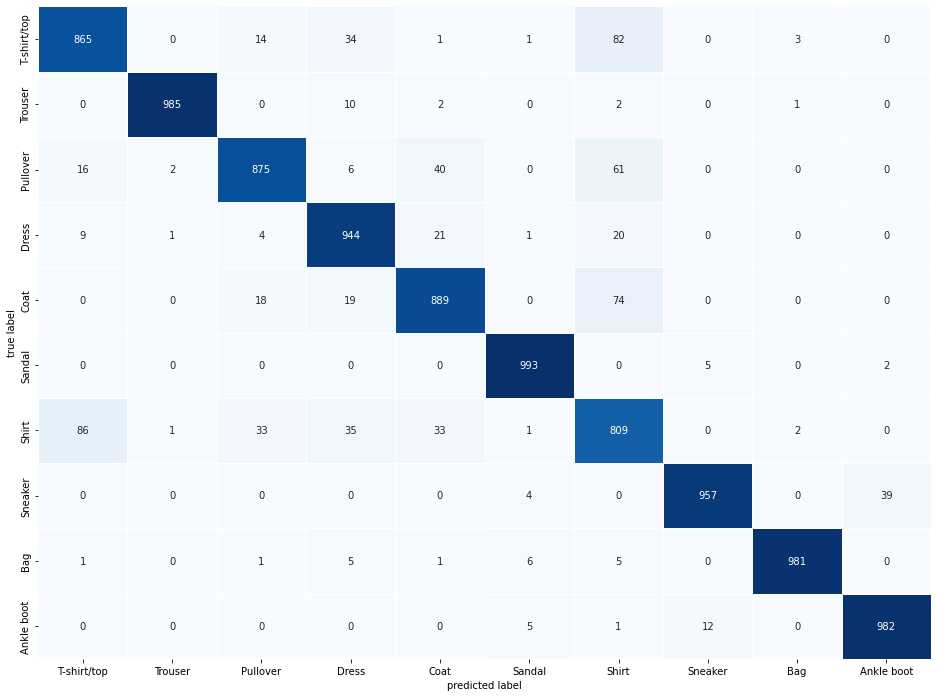

In [125]:
plot_confusion_matrix(y_test,pred_06_cm)

In [126]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred_06[0:20], columns = class_names)
df.style.format("{:.2%}").background_gradient(cmap=cm)

In [127]:
layer_names = []
for layer in model_06.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'batch_normalization',
 'dropout',
 'conv2d_1',
 'max_pooling2d_1',
 'batch_normalization_1',
 'dropout_1',
 'conv2d_2',
 'max_pooling2d_2',
 'batch_normalization_2',
 'dropout_2',
 'conv2d_3',
 'max_pooling2d_3',
 'batch_normalization_3',
 'dropout_3',
 'flatten',
 'dense',
 'batch_normalization_4',
 'dropout_4',
 'dense_1',
 'batch_normalization_5',
 'dropout_5',
 'dense_2']

In [128]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model_06.layers[:20]]
# Creates a model that will return these outputs, given the model input:
activation_model_06 = tf.keras.models.Model(inputs=model_06.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations_06 = activation_model_06.predict(x_valid[:2000])
dense_layer_activations_06 = activations_06[-3]
output_layer_activations_06 = activations_06[-1]

63/63 [==============================] - 1s 6ms/step


In [129]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_06 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_06 = tsne_06.fit_transform(dense_layer_activations_06)

# Scaling
tsne_results_06 = (tsne_results_06 - tsne_results_06.min()) / (tsne_results_06.max() - tsne_results_06.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.119s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.820662


C:\Users\Reed\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.538265
[t-SNE] KL divergence after 300 iterations: 1.002389


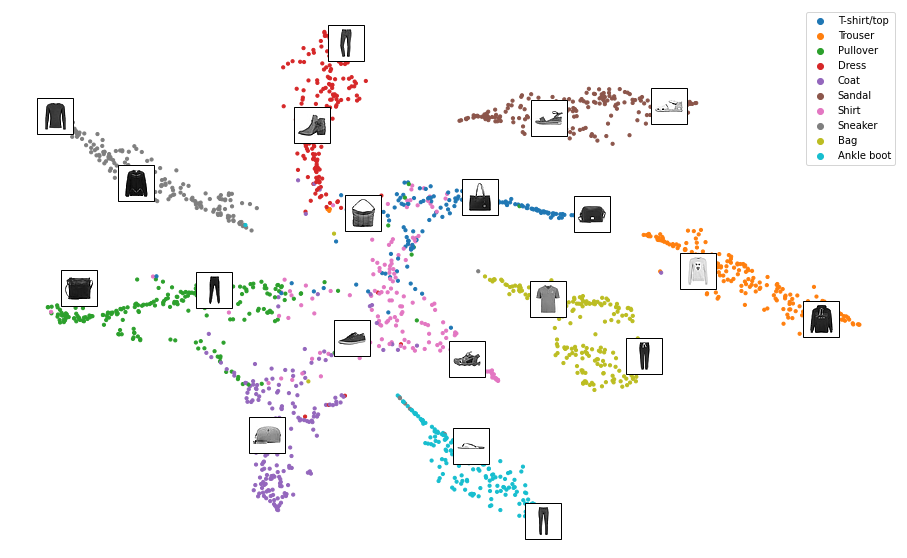

In [130]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results_06[:,0],tsne_results_06[:,1], c=y_valid[:2000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_06):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

# INVALID EXPERIMENT 10
# ----------------------------------------------------------------

# INVALID EXPERIMENT 10 DONE
# ----------------------------------------------------------------

### Exp 6 0.9323 > Exp 4 0.9297 accuracy, L2 Reg 0.01 improvement

Next: higher L2 regularization, 0.1

## Experiment 7

- Conv2D with 3 Layers (128, 256, 512, Kernel size 3, Padding same)
- DNN with 2 layers (384, 768)
- Batch Normalization
- Dropout(0.2)
- L2 Regularization(0.1)

In [131]:
k.clear_session()
model_07 = Sequential([
  Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.2),
  Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.2),
  Conv2D(filters=512, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.2),    
  Flatten(),
  Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.1)),
  BatchNormalization(),
  Dropout(0.2),
  Dense(units=768,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.1)),
  BatchNormalization(),
  Dropout(0.2),
  Dense(units=10, activation=tf.nn.softmax)       
])

In [132]:
model_07.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 128)      512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 256)        0

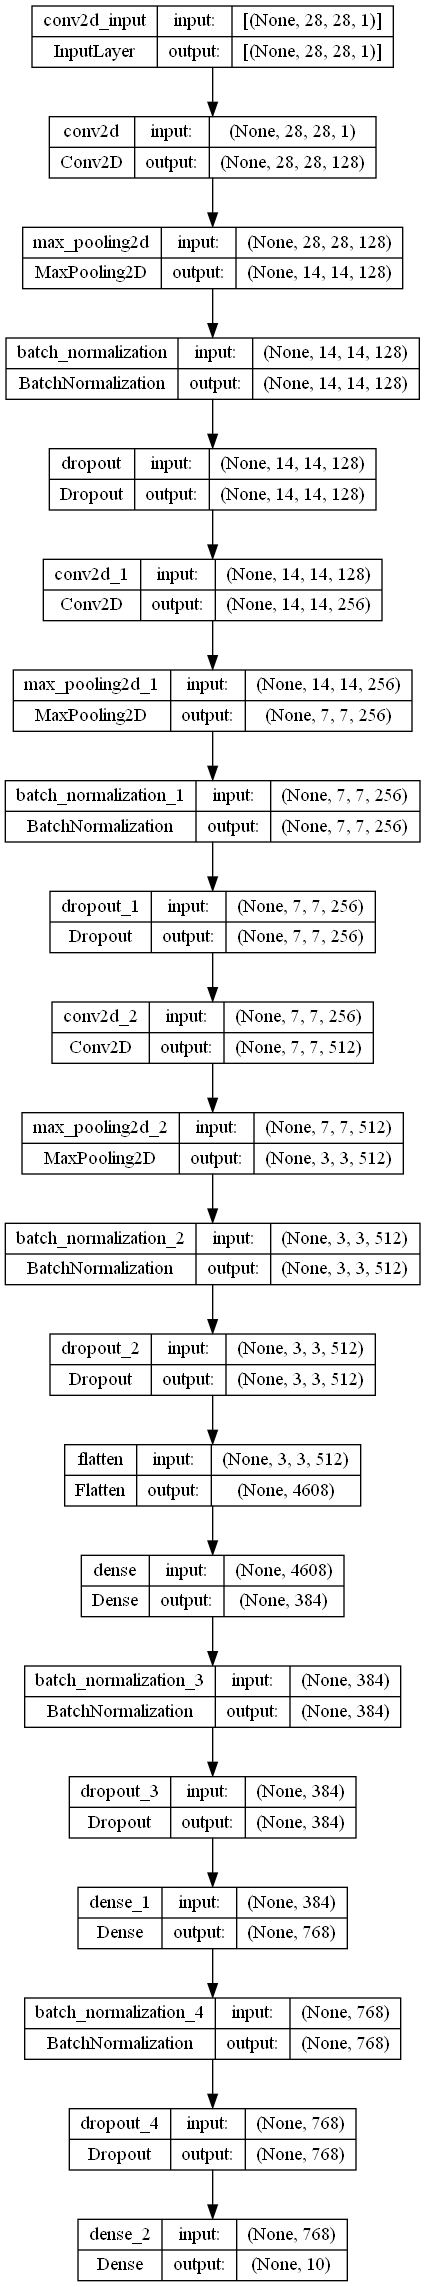

In [133]:
keras.utils.plot_model(model_07, "FASHION-MNIST_EXP-07.png", show_shapes=True) 

In [134]:
model_07.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [135]:
history_07 = model_07.fit(x_train
                    ,y_train
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid, y_valid)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("FASHION-MNIST_EXP-07.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
                    ]                                                                                                           
                   )

Epoch 1/200
844/844 [==============================] - 13s 14ms/step - loss: 5.4039 - accuracy: 0.7919 - val_loss: 2.0352 - val_accuracy: 0.8067
Epoch 2/200
844/844 [==============================] - 12s 15ms/step - loss: 1.5277 - accuracy: 0.8488 - val_loss: 1.2324 - val_accuracy: 0.8642
Epoch 3/200
844/844 [==============================] - 12s 14ms/step - loss: 1.3170 - accuracy: 0.8648 - val_loss: 1.3859 - val_accuracy: 0.8383
Epoch 4/200
844/844 [==============================] - 12s 14ms/step - loss: 1.2361 - accuracy: 0.8709 - val_loss: 1.4098 - val_accuracy: 0.8837
Epoch 5/200
844/844 [==============================] - 12s 14ms/step - loss: 1.1479 - accuracy: 0.8785 - val_loss: 1.2347 - val_accuracy: 0.8733
Epoch 6/200
844/844 [==============================] - 12s 14ms/step - loss: 1.0442 - accuracy: 0.8840 - val_loss: 1.0227 - val_accuracy: 0.8508
Epoch 7/200
844/844 [==============================] - 12s 14ms/step - loss: 0.9940 - accuracy: 0.8891 - val_loss: 1.0101 - val_ac

In [47]:
model_07 = tf.keras.models.load_model("FASHION-MNIST_EXP-07.h5") # batch normalization, L2 reg 0.01, dropout 0.2
print(f"Test acc: {model_07.evaluate(x_test, y_test)[1]:.3f}")

313/313 [==============================] - 2s 5ms/step - loss: 0.6381 - accuracy: 0.9042
Test acc: 0.904


In [137]:
history_07_dict = history_07.history
history_07_df=pd.DataFrame(history_07_dict)
history_07_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
10  0.766     0.903     0.714         0.904
11  0.760     0.908     0.729         0.906
12  0.715     0.911     0.647         0.913
13  0.676     0.912     0.624         0.909
14  0.650     0.915     0.686         0.894

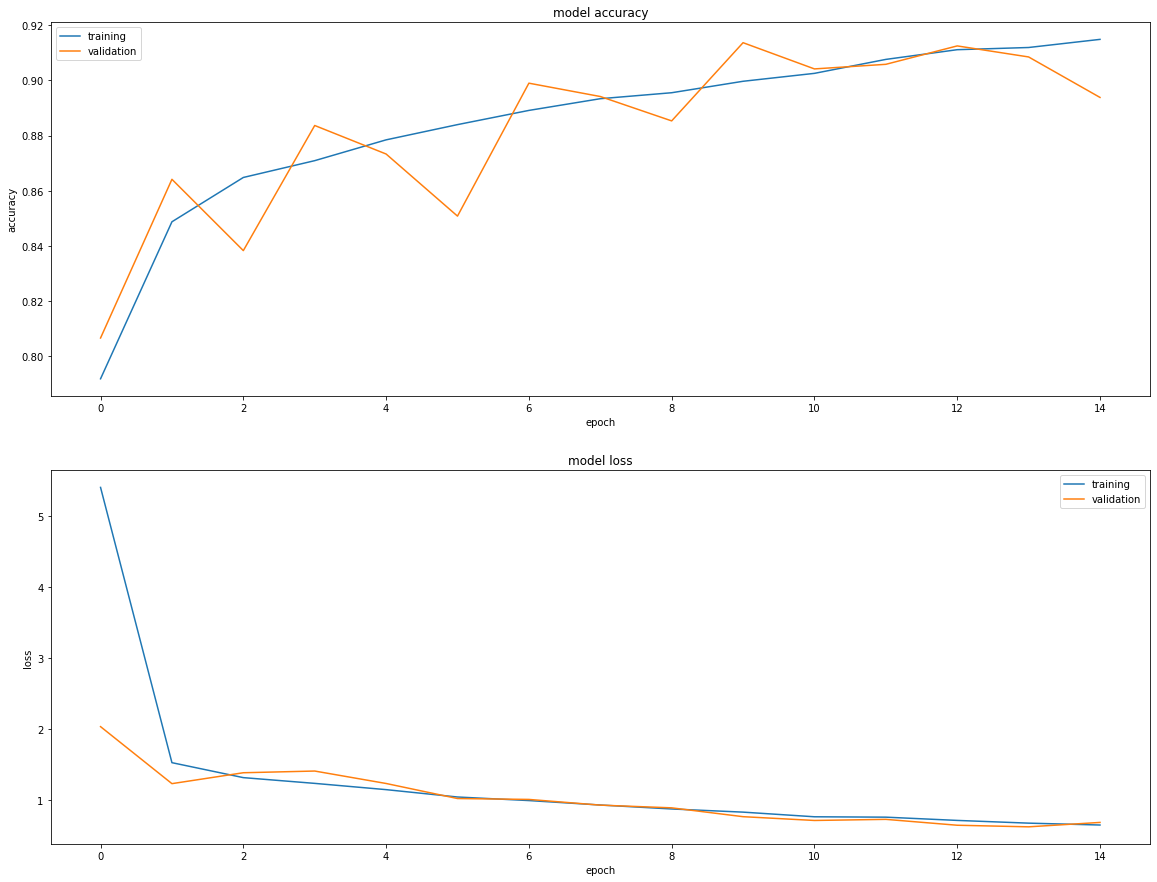

In [138]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_07.history['accuracy'], history_07.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_07.history['loss'], history_07.history['val_loss'], 'loss', 212)

In [48]:
pred_07 = model_07.predict(x_test)
pred_07_cm=np.argmax(pred_07, axis=1)
print_validation_report(y_test, pred_07_cm)

313/313 [==============================] - 1s 4ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1000
           1       0.99      0.98      0.99      1000
           2       0.88      0.80      0.84      1000
           3       0.91      0.91      0.91      1000
           4       0.74      0.94      0.83      1000
           5       0.98      0.99      0.98      1000
           6       0.79      0.68      0.73      1000
           7       0.93      0.99      0.96      1000
           8       0.99      0.98      0.99      1000
           9       0.99      0.93      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.90      0.90     10000

Accuracy Score: 0.9042
Root Mean Square Error: 1.1322985472038725


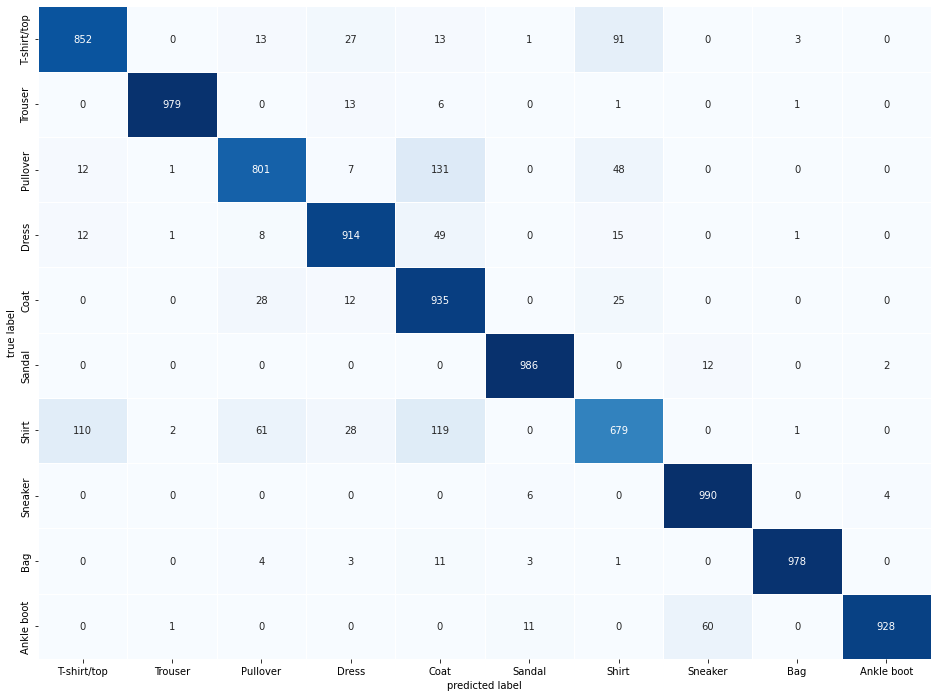

In [49]:
plot_confusion_matrix(y_test,pred_07_cm)

In [50]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred_07[0:20], columns = class_names)
df.style.format("{:.2%}").background_gradient(cmap=cm)

In [51]:
layer_names = []
for layer in model_07.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'batch_normalization',
 'dropout',
 'conv2d_1',
 'max_pooling2d_1',
 'batch_normalization_1',
 'dropout_1',
 'conv2d_2',
 'max_pooling2d_2',
 'batch_normalization_2',
 'dropout_2',
 'flatten',
 'dense',
 'batch_normalization_3',
 'dropout_3',
 'dense_1',
 'batch_normalization_4',
 'dropout_4',
 'dense_2']

In [52]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model_07.layers[:20]]
# Creates a model that will return these outputs, given the model input:
activation_model_07 = tf.keras.models.Model(inputs=model_07.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations_07 = activation_model_07.predict(x_valid[:2000])
dense_layer_activations_07 = activations_07[-3]
output_layer_activations_07 = activations_07[-1]

63/63 [==============================] - 1s 8ms/step


In [53]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_07 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_07 = tsne_07.fit_transform(dense_layer_activations_07)

# Scaling
tsne_results_07 = (tsne_results_07 - tsne_results_07.min()) / (tsne_results_07.max() - tsne_results_07.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 0.148s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.367312


C:\Users\Reed\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.101410
[t-SNE] KL divergence after 300 iterations: 0.917420


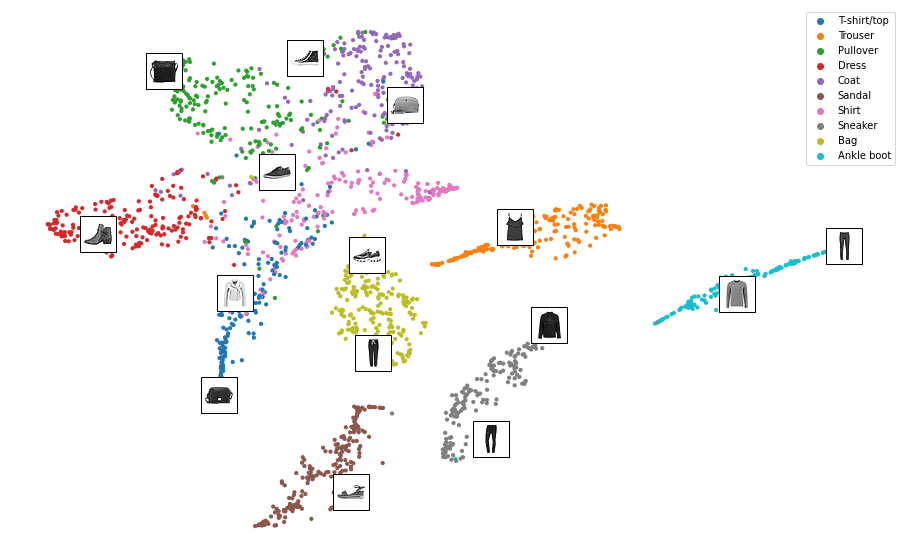

In [54]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results_07[:,0],tsne_results_07[:,1], c=y_valid[:2000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_07):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

### Exp 6 0.9323 > Exp 7 0.9188 accuracy, L2 Reg 0.1 not improvement

- Best model so far: Exp. 6 at 0.9323

- Next: L2 regularization at 0.0001


## Experiment 8

- Conv2D with 3 Layers (128, 256, 512, Kernel size 3, Padding same)
- DNN with 2 layers (384, 768)
- Batch Normalization
- Dropout(0.2)
- L2 Regularization(0.0001)

In [146]:
k.clear_session()
model_08 = Sequential([
  Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.2),
  Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.2),
  Conv2D(filters=512, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.2),    
  Flatten(),
  Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
  BatchNormalization(),
  Dropout(0.2),
  Dense(units=768,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
  BatchNormalization(),
  Dropout(0.2),
  Dense(units=10, activation=tf.nn.softmax)       
])

In [147]:
model_08.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 128)      512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 256)        0

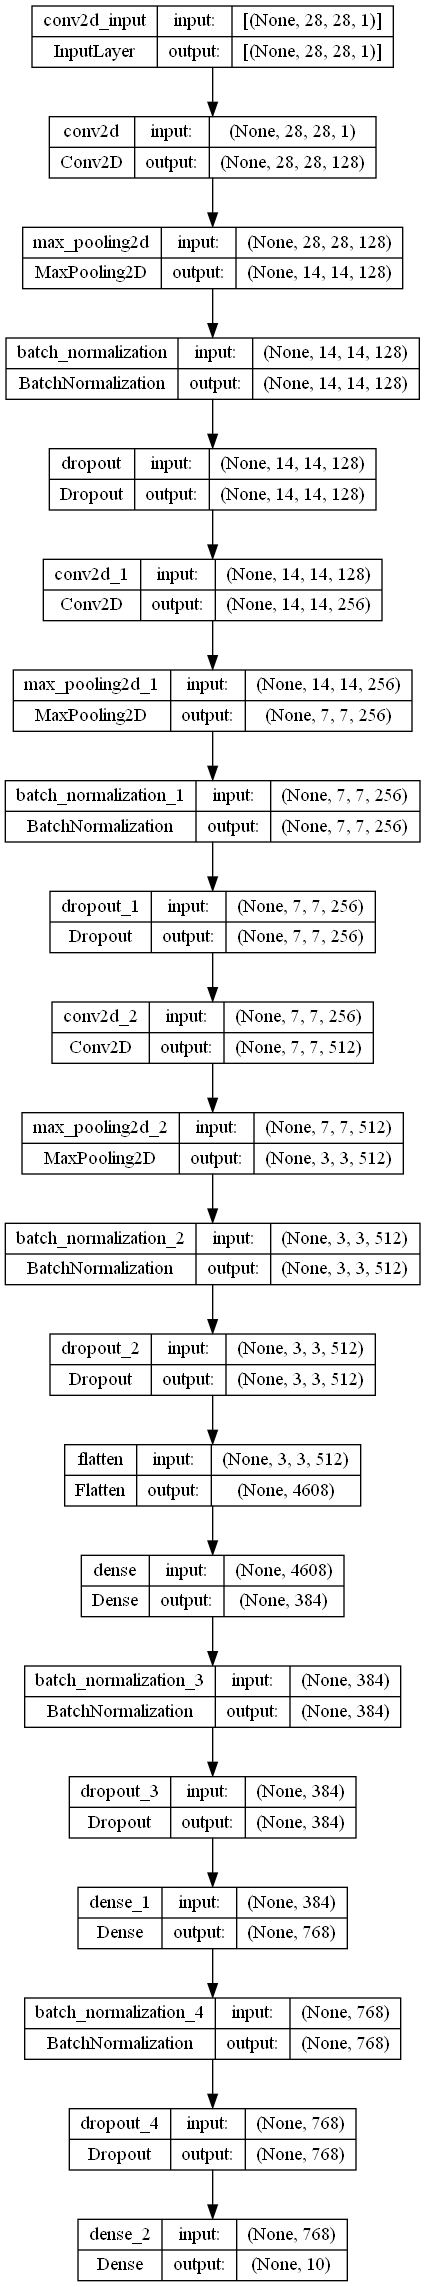

In [148]:
keras.utils.plot_model(model_08, "FASHION-MNIST_EXP-08.png", show_shapes=True) 

In [149]:
model_08.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [150]:
history_08 = model_08.fit(x_train
                    ,y_train
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid, y_valid)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("FASHION-MNIST_EXP-08.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
                    ]                                                                                                           
                   )

Epoch 1/200
844/844 [==============================] - 14s 15ms/step - loss: 0.6151 - accuracy: 0.8316 - val_loss: 0.4516 - val_accuracy: 0.8855
Epoch 2/200
844/844 [==============================] - 12s 14ms/step - loss: 0.4346 - accuracy: 0.8906 - val_loss: 0.3884 - val_accuracy: 0.9015
Epoch 3/200
844/844 [==============================] - 12s 14ms/step - loss: 0.3789 - accuracy: 0.9062 - val_loss: 0.3559 - val_accuracy: 0.9095
Epoch 4/200
844/844 [==============================] - 12s 14ms/step - loss: 0.3492 - accuracy: 0.9137 - val_loss: 0.3344 - val_accuracy: 0.9213
Epoch 5/200
844/844 [==============================] - 12s 14ms/step - loss: 0.3297 - accuracy: 0.9193 - val_loss: 0.3570 - val_accuracy: 0.9045
Epoch 6/200
844/844 [==============================] - 12s 14ms/step - loss: 0.3164 - accuracy: 0.9260 - val_loss: 0.3859 - val_accuracy: 0.9013
Epoch 7/200
844/844 [==============================] - 12s 14ms/step - loss: 0.3037 - accuracy: 0.9280 - val_loss: 0.3302 - val_ac

In [22]:
model_08 = tf.keras.models.load_model("FASHION-MNIST_EXP-08.h5") # batch normalization, L2 reg 0.01, dropout 0.2
print(f"Test acc: {model_08.evaluate(x_test, y_test)[1]:.3f}")

313/313 [==============================] - 5s 6ms/step - loss: 0.3320 - accuracy: 0.9275
Test acc: 0.928


In [152]:
history_08_dict = history_08.history
history_08_df=pd.DataFrame(history_08_dict)
history_08_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
15  0.220     0.960     0.328         0.930
16  0.216     0.960     0.328         0.926
17  0.207     0.963     0.319         0.932
18  0.198     0.964     0.356         0.924
19  0.190     0.966     0.326         0.928

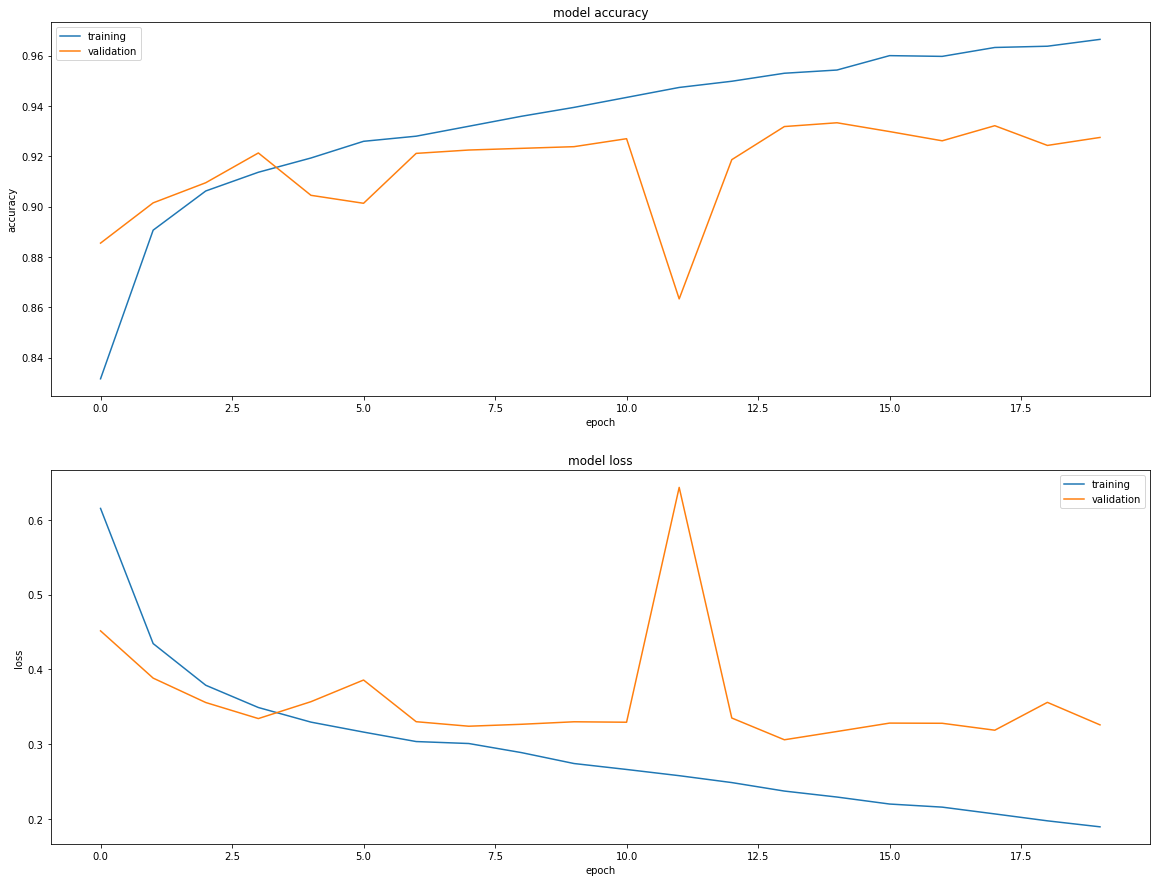

In [153]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_08.history['accuracy'], history_08.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_08.history['loss'], history_08.history['val_loss'], 'loss', 212)

In [23]:
pred_08 = model_08.predict(x_test)
pred_08_cm=np.argmax(pred_08, axis=1)
print_validation_report(y_test, pred_08_cm)

313/313 [==============================] - 1s 4ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1000
           1       0.99      0.99      0.99      1000
           2       0.88      0.89      0.89      1000
           3       0.95      0.91      0.93      1000
           4       0.88      0.88      0.88      1000
           5       0.99      0.98      0.98      1000
           6       0.79      0.80      0.79      1000
           7       0.94      0.99      0.97      1000
           8       0.99      0.98      0.99      1000
           9       0.98      0.95      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

Accuracy Score: 0.9275
Root Mean Square Error: 0.995339138183564


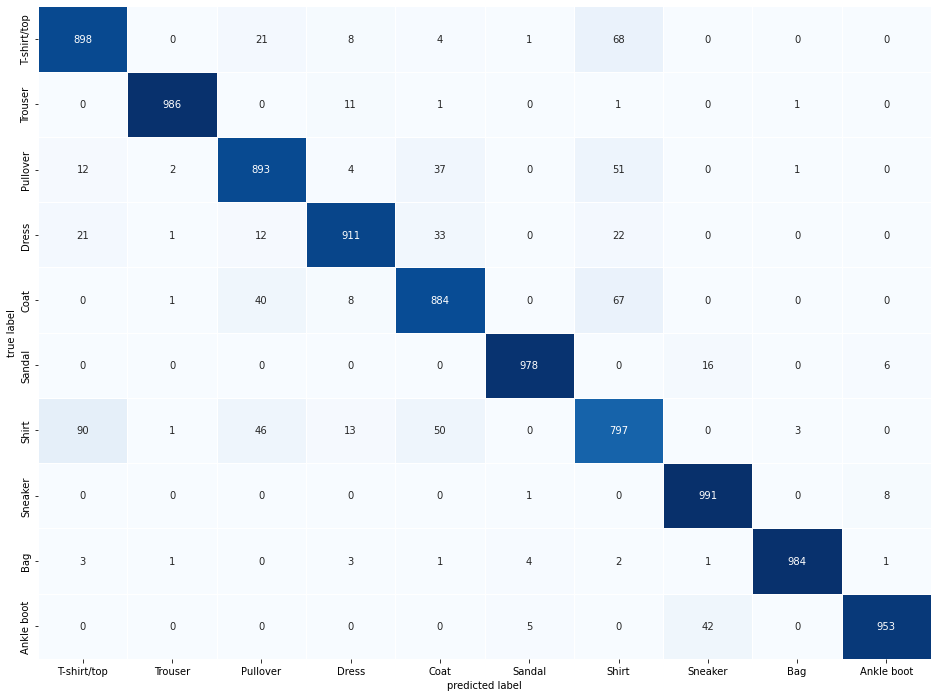

In [24]:
plot_confusion_matrix(y_test,pred_08_cm)

In [25]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred_08[0:20], columns = class_names)
df.style.format("{:.2%}").background_gradient(cmap=cm)

In [26]:
layer_names = []
for layer in model_08.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'batch_normalization',
 'dropout',
 'conv2d_1',
 'max_pooling2d_1',
 'batch_normalization_1',
 'dropout_1',
 'conv2d_2',
 'max_pooling2d_2',
 'batch_normalization_2',
 'dropout_2',
 'flatten',
 'dense',
 'batch_normalization_3',
 'dropout_3',
 'dense_1',
 'batch_normalization_4',
 'dropout_4',
 'dense_2']

In [27]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model_08.layers[:20]]
# Creates a model that will return these outputs, given the model input:
activation_model_08 = tf.keras.models.Model(inputs=model_08.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations_08 = activation_model_08.predict(x_valid[:2000])
dense_layer_activations_08 = activations_08[-3]
output_layer_activations_08 = activations_08[-1]

63/63 [==============================] - 1s 6ms/step


In [28]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_08 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_08 = tsne_08.fit_transform(dense_layer_activations_08)

# Scaling
tsne_results_08 = (tsne_results_08 - tsne_results_08.min()) / (tsne_results_08.max() - tsne_results_08.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.130s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 3.490862


C:\Users\Reed\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.638149
[t-SNE] KL divergence after 300 iterations: 0.917299


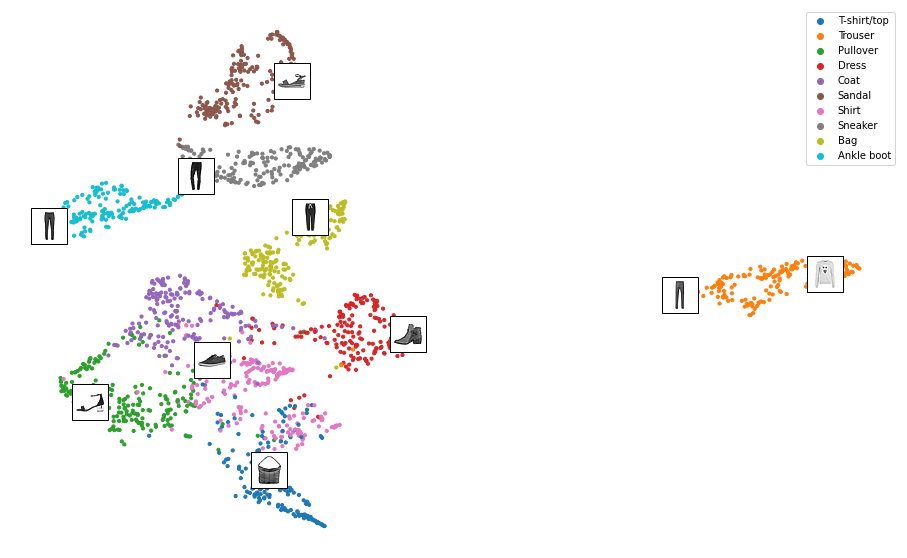

In [29]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results_08[:,0],tsne_results_08[:,1], c=y_valid[:2000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_08):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

### Exp 6 0.9323 > Exp 8 0.9262 accuracy, L2 Reg 0.0001 not improvement

Best model Conv2D model so far: Experiment 6 at 0.9323

- Conv2D with 3 Layers (128, 256, 512, Kernel size 3, Padding same)
- DNN with 2 layers (384, 768)
- Batch Normalization
- Dropout(0.2)
- L2 Regularization(0.01)

Next: Dropout(0.5) - just check, all other Exp 6 settings same

## Experiment 9

- Conv2D with 3 Layers (128, 256, 512, Kernel size 3, Padding same)
- DNN with 2 layers (384, 768)
- Batch Normalization
- Dropout(0.5) - changed from Exp 6
- L2 Regularization(0.01)

In [30]:
k.clear_session()
model_09 = Sequential([
  Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.5),
  Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.5),
  Conv2D(filters=512, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.5),    
  Flatten(),
  Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.01)),
  BatchNormalization(),
  Dropout(0.5),
  Dense(units=768,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.01)),
  BatchNormalization(),
  Dropout(0.5),
  Dense(units=10, activation=tf.nn.softmax)       
])

In [31]:
model_09.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 128)      512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 256)        0

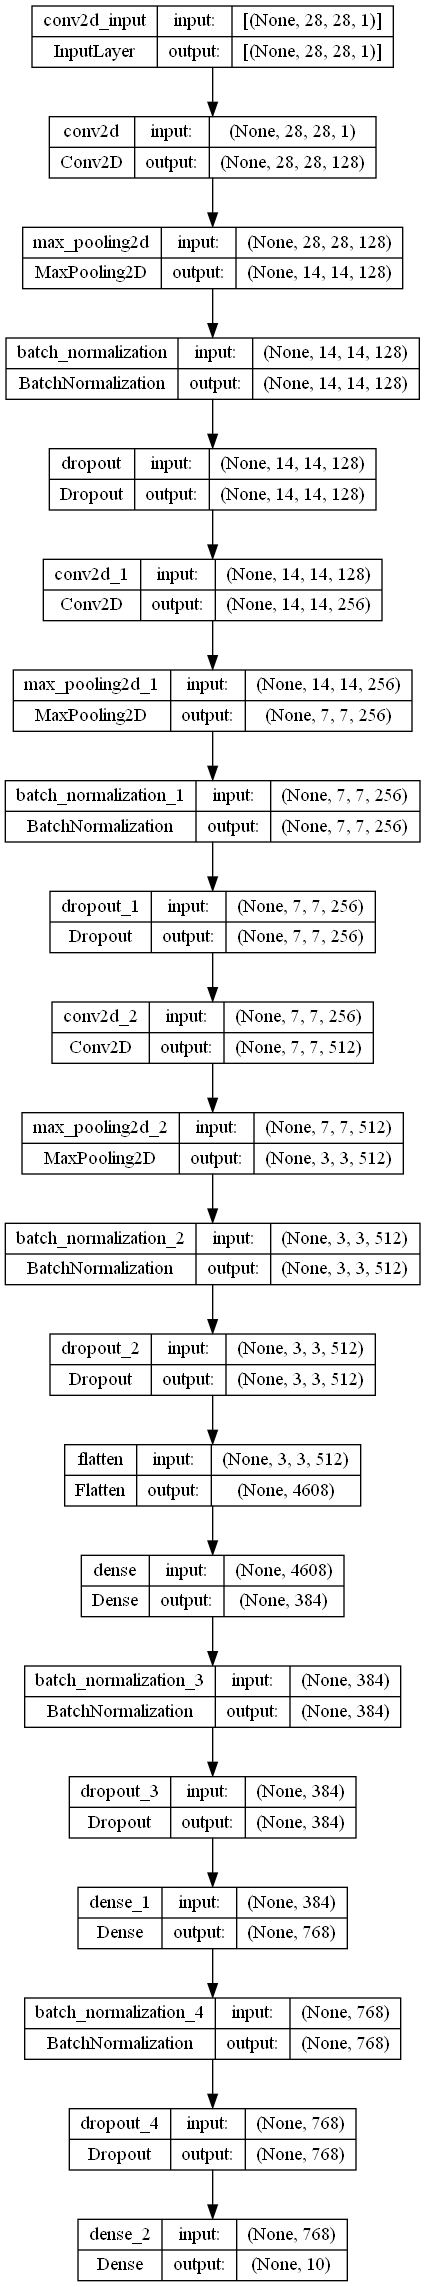

In [32]:
keras.utils.plot_model(model_09, "FASHION-MNIST_EXP-09.png", show_shapes=True) 

In [33]:
model_09.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [34]:
history_09 = model_09.fit(x_train
                    ,y_train
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid, y_valid)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("FASHION-MNIST_EXP-09.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
                    ]                                                                                                           
                   )

Epoch 1/200
844/844 [==============================] - 15s 15ms/step - loss: 4.2149 - accuracy: 0.7629 - val_loss: 1.4119 - val_accuracy: 0.8525
Epoch 2/200
844/844 [==============================] - 12s 14ms/step - loss: 1.3559 - accuracy: 0.8386 - val_loss: 1.3147 - val_accuracy: 0.8748
Epoch 3/200
844/844 [==============================] - 12s 14ms/step - loss: 1.2714 - accuracy: 0.8518 - val_loss: 1.2155 - val_accuracy: 0.8790
Epoch 4/200
844/844 [==============================] - 12s 14ms/step - loss: 1.2871 - accuracy: 0.8581 - val_loss: 1.2817 - val_accuracy: 0.8728
Epoch 5/200
844/844 [==============================] - 12s 14ms/step - loss: 1.2619 - accuracy: 0.8656 - val_loss: 1.2891 - val_accuracy: 0.8690
Epoch 6/200
844/844 [==============================] - 12s 14ms/step - loss: 1.2502 - accuracy: 0.8694 - val_loss: 1.1643 - val_accuracy: 0.9000
Epoch 7/200
844/844 [==============================] - 12s 14ms/step - loss: 1.2386 - accuracy: 0.8709 - val_loss: 1.2213 - val_ac

In [63]:
model_09 = tf.keras.models.load_model("FASHION-MNIST_EXP-09.h5") # batch normalization, L2 reg 0.01, dropout 0.5
print(f"Test acc: {model_09.evaluate(x_test, y_test)[1]:.3f}")

313/313 [==============================] - 2s 6ms/step - loss: 1.0441 - accuracy: 0.8926
Test acc: 0.893


In [64]:
history_09_dict = history_09.history
history_09_df=pd.DataFrame(history_09_dict)
history_09_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
6   1.239     0.871     1.221         0.881
7   1.253     0.874     1.152         0.896
8   1.200     0.877     1.142         0.886
9   1.169     0.880     1.031         0.897
10  1.174     0.882     1.038         0.892

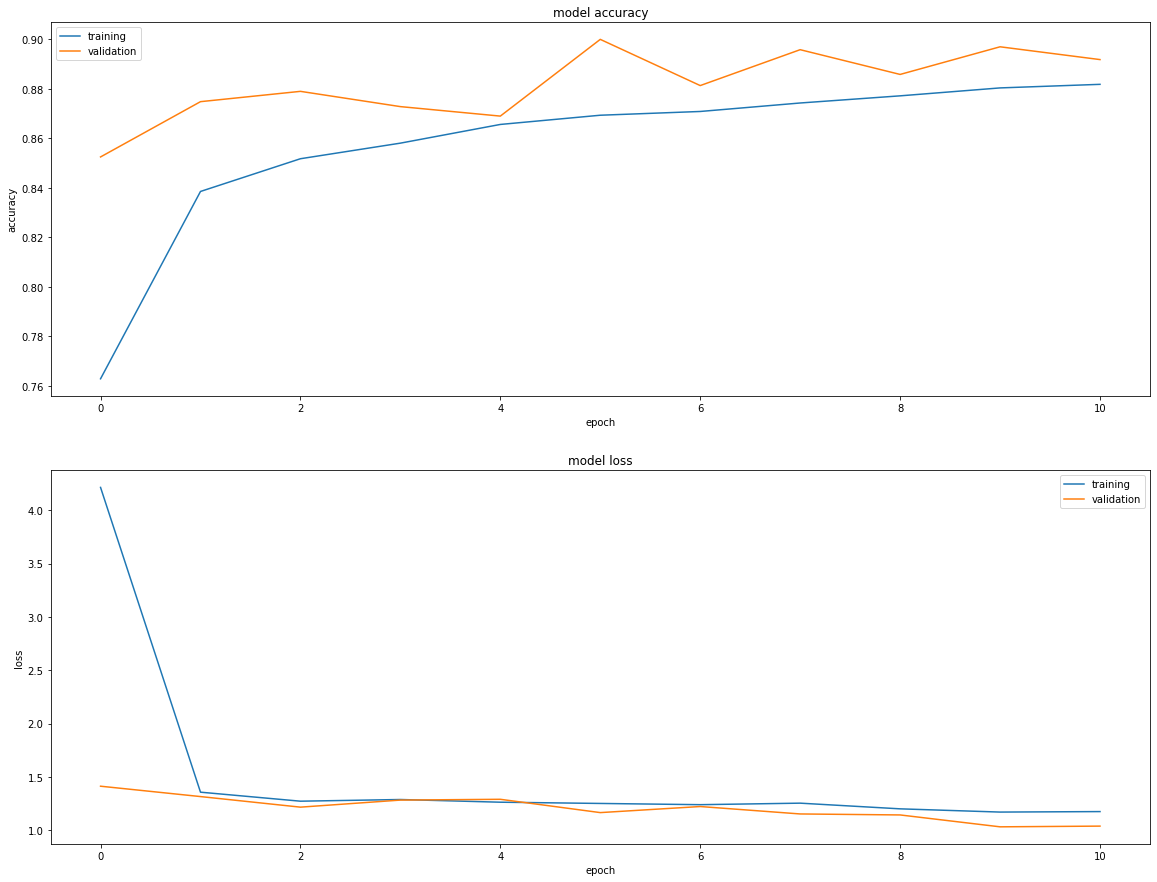

In [65]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_09.history['accuracy'], history_09.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_09.history['loss'], history_09.history['val_loss'], 'loss', 212)

In [66]:
pred_09 = model_09.predict(x_test)
pred_09_cm=np.argmax(pred_09, axis=1)
print_validation_report(y_test, pred_09_cm)

313/313 [==============================] - 1s 3ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.73      0.96      0.83      1000
           1       0.98      0.98      0.98      1000
           2       0.84      0.88      0.86      1000
           3       0.93      0.87      0.90      1000
           4       0.80      0.83      0.82      1000
           5       0.99      0.97      0.98      1000
           6       0.78      0.53      0.63      1000
           7       0.95      0.95      0.95      1000
           8       0.98      0.98      0.98      1000
           9       0.95      0.98      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Accuracy Score: 0.8926
Root Mean Square Error: 1.2723600119463045


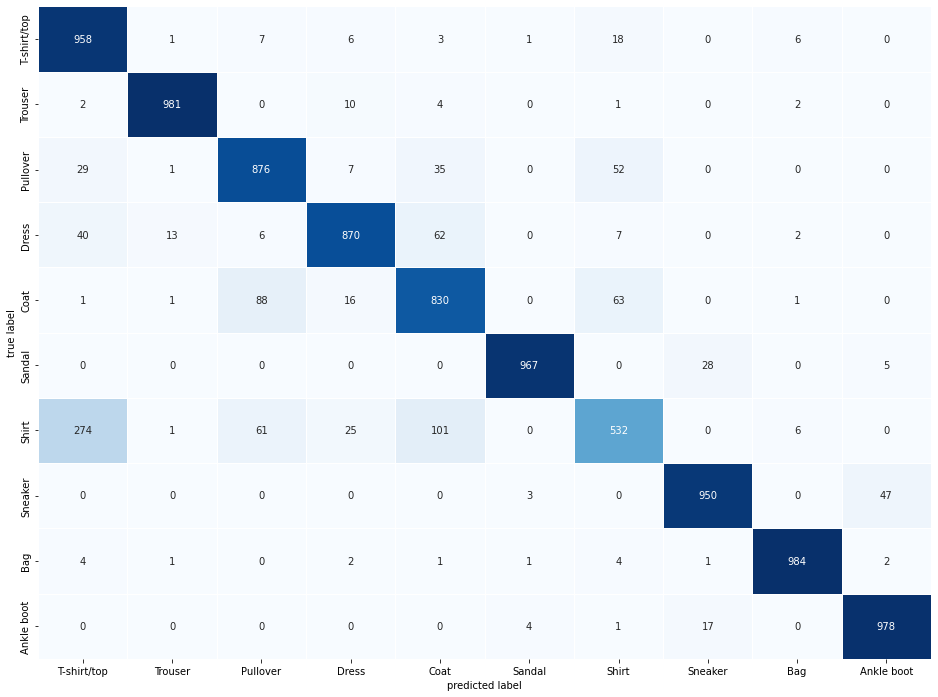

In [67]:
plot_confusion_matrix(y_test,pred_09_cm)

In [68]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred_09[0:20], columns = class_names)
df.style.format("{:.2%}").background_gradient(cmap=cm)

In [69]:
layer_names = []
for layer in model_09.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'batch_normalization',
 'dropout',
 'conv2d_1',
 'max_pooling2d_1',
 'batch_normalization_1',
 'dropout_1',
 'conv2d_2',
 'max_pooling2d_2',
 'batch_normalization_2',
 'dropout_2',
 'flatten',
 'dense',
 'batch_normalization_3',
 'dropout_3',
 'dense_1',
 'batch_normalization_4',
 'dropout_4',
 'dense_2']

In [70]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model_09.layers[:20]]
# Creates a model that will return these outputs, given the model input:
activation_model_09 = tf.keras.models.Model(inputs=model_09.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations_09 = activation_model_09.predict(x_valid[:2000])
dense_layer_activations_09 = activations_09[-3]
output_layer_activations_09 = activations_09[-1]

63/63 [==============================] - 1s 7ms/step


In [71]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_09 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_09 = tsne_09.fit_transform(dense_layer_activations_09)

# Scaling
tsne_results_09 = (tsne_results_09 - tsne_results_09.min()) / (tsne_results_09.max() - tsne_results_09.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 0.139s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 2.614910


C:\Users\Reed\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.966213
[t-SNE] KL divergence after 300 iterations: 0.935416


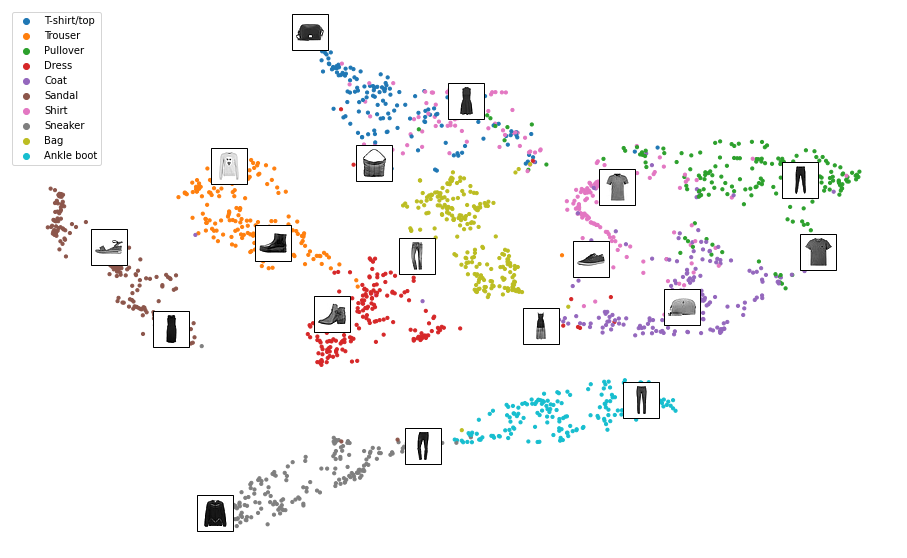

In [72]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results_09[:,0],tsne_results_09[:,1], c=y_valid[:2000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_09):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## Experiment 6

- Conv2D with 3 Layers (128, 256, 512, Kernel size 3, Padding same)
- DNN with 2 layers (384, 768)
- Batch Normalization
- Dropout(0.2)
- L2 Regularization(0.01)

In [30]:
k.clear_session()
model_06 = Sequential([
  Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.2),
  Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.2),
  Conv2D(filters=512, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.2),    
  Conv2D(filters=512, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.2),    
  Flatten(),
  Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.01)),
  BatchNormalization(),
  Dropout(0.2),
  Dense(units=768,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.01)),
  BatchNormalization(),
  Dropout(0.2),
  Dense(units=10, activation=tf.nn.softmax)       
])

In [31]:
model_06.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 128)      512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 256)        0

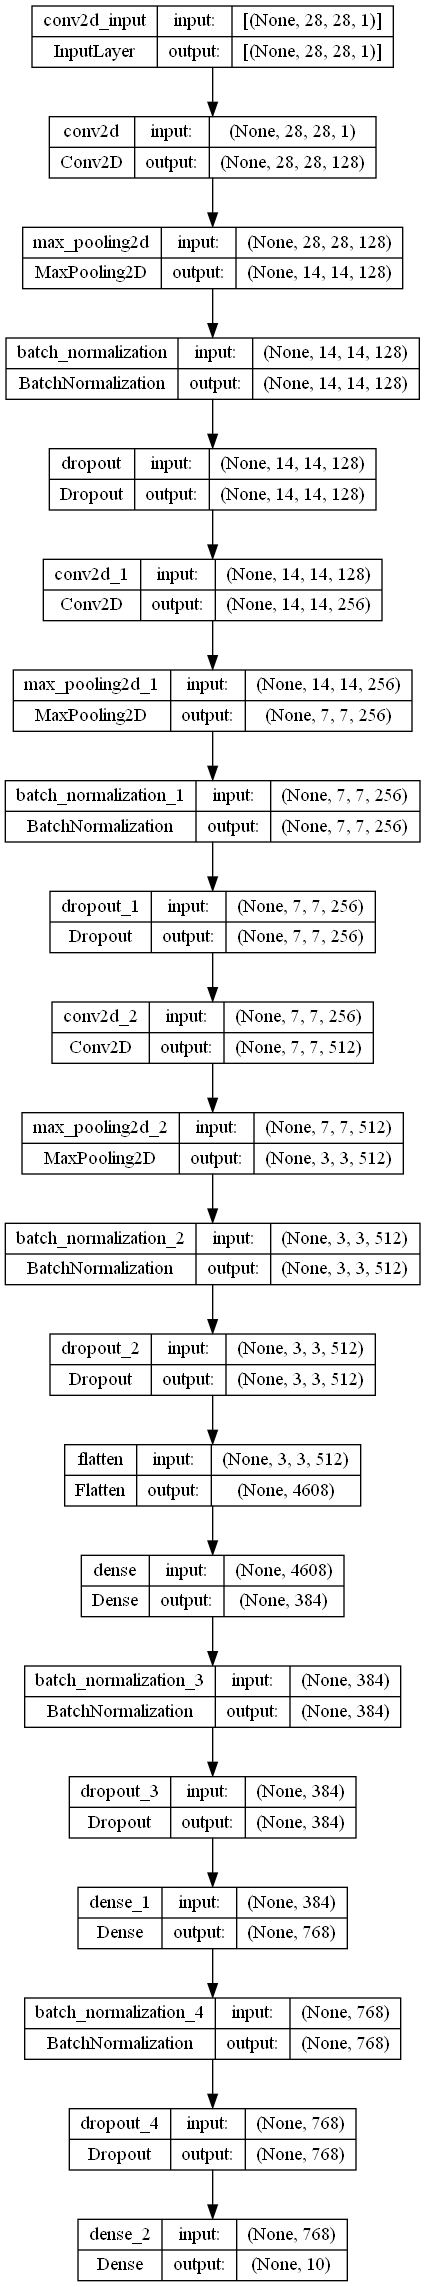

In [32]:
keras.utils.plot_model(model_06, "FASHION-MNIST_EXP-06.png", show_shapes=True) 

In [33]:
model_06.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [34]:
history_06 = model_06.fit(x_train
                    ,y_train
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid, y_valid)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("FASHION-MNIST_EXP-06.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
                    ]                                                                                                           
                   )

Epoch 1/200
844/844 [==============================] - 15s 15ms/step - loss: 2.6499 - accuracy: 0.8191 - val_loss: 0.9440 - val_accuracy: 0.8397
Epoch 2/200
844/844 [==============================] - 12s 14ms/step - loss: 0.8287 - accuracy: 0.8676 - val_loss: 0.8990 - val_accuracy: 0.8535
Epoch 3/200
844/844 [==============================] - 12s 14ms/step - loss: 0.7644 - accuracy: 0.8802 - val_loss: 0.7502 - val_accuracy: 0.8672
Epoch 4/200
844/844 [==============================] - 12s 14ms/step - loss: 0.7271 - accuracy: 0.8875 - val_loss: 0.8211 - val_accuracy: 0.8597
Epoch 5/200
844/844 [==============================] - 12s 14ms/step - loss: 0.6844 - accuracy: 0.8931 - val_loss: 0.7007 - val_accuracy: 0.8737
Epoch 6/200
844/844 [==============================] - 13s 15ms/step - loss: 0.6540 - accuracy: 0.8984 - val_loss: 0.7565 - val_accuracy: 0.8557
Epoch 7/200
844/844 [==============================] - 12s 15ms/step - loss: 0.6099 - accuracy: 0.9046 - val_loss: 0.5672 - val_ac

In [107]:
model_06 = tf.keras.models.load_model("FASHION-MNIST_EXP-06.h5") # batch normalization, L2 reg 0.01, dropout 0.2
print(f"Test acc: {model_06.evaluate(x_test, y_test)[1]:.3f}")

313/313 [==============================] - 2s 5ms/step - loss: 0.3229 - accuracy: 0.9323
Test acc: 0.932


In [36]:
history_06_dict = history_06.history
history_06_df=pd.DataFrame(history_06_dict)
history_06_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
26  0.258     0.955     0.308         0.934
27  0.256     0.955     0.338         0.927
28  0.243     0.958     0.338         0.927
29  0.247     0.958     0.301         0.936
30  0.238     0.959     0.321         0.930

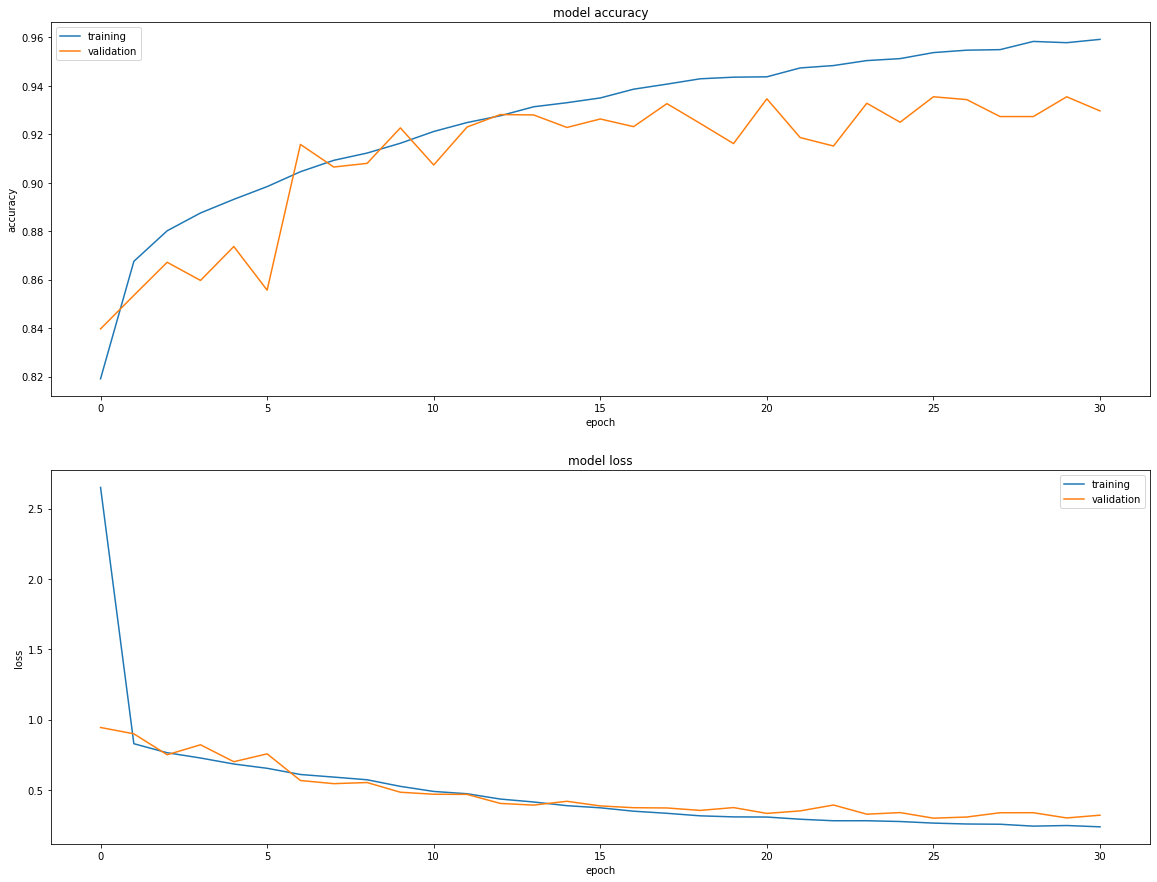

In [37]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_06.history['accuracy'], history_06.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_06.history['loss'], history_06.history['val_loss'], 'loss', 212)

In [108]:
pred_06 = model_06.predict(x_test)
pred_06_cm=np.argmax(pred_06, axis=1)
print_validation_report(y_test, pred_06_cm)

313/313 [==============================] - 1s 4ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      1000
           1       1.00      0.99      0.99      1000
           2       0.87      0.93      0.90      1000
           3       0.94      0.93      0.93      1000
           4       0.90      0.89      0.90      1000
           5       0.99      1.00      0.99      1000
           6       0.81      0.77      0.79      1000
           7       0.96      0.98      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.99      0.96      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

Accuracy Score: 0.9323
Root Mean Square Error: 0.9973464794142505


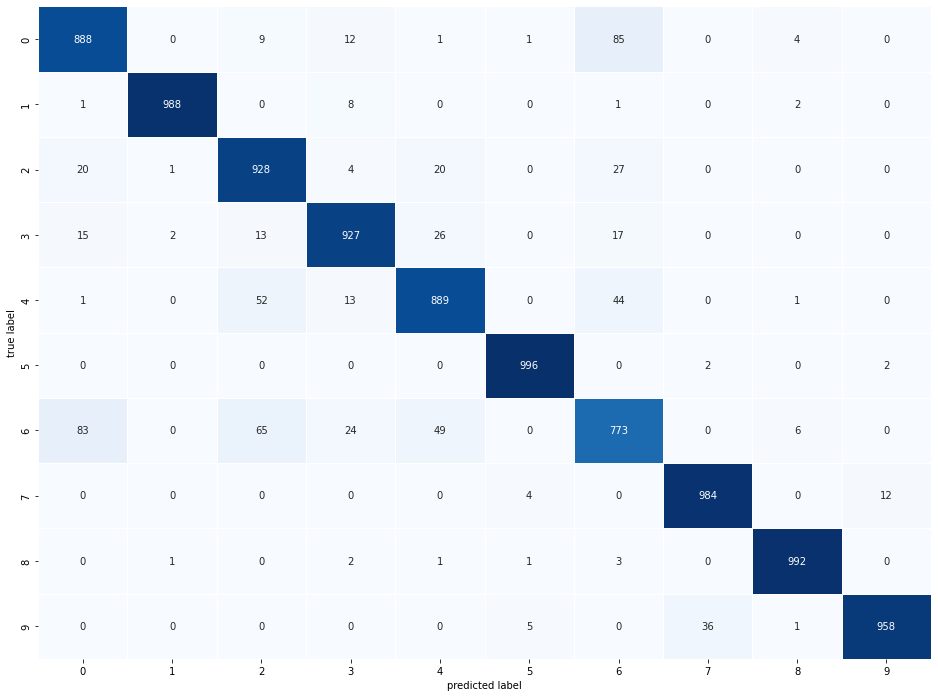

In [109]:
plot_confusion_matrix(y_test,pred_06_cm)

In [110]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred_06[0:20], columns = class_names)
df.style.format("{:.2%}").background_gradient(cmap=cm)

In [41]:
layer_names = []
for layer in model_06.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'batch_normalization',
 'dropout',
 'conv2d_1',
 'max_pooling2d_1',
 'batch_normalization_1',
 'dropout_1',
 'conv2d_2',
 'max_pooling2d_2',
 'batch_normalization_2',
 'dropout_2',
 'flatten',
 'dense',
 'batch_normalization_3',
 'dropout_3',
 'dense_1',
 'batch_normalization_4',
 'dropout_4',
 'dense_2']

In [42]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model_06.layers[:20]]
# Creates a model that will return these outputs, given the model input:
activation_model_06 = tf.keras.models.Model(inputs=model_06.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations_06 = activation_model_06.predict(x_valid[:2000])
dense_layer_activations_06 = activations_06[-3]
output_layer_activations_06 = activations_06[-1]

63/63 [==============================] - 0s 6ms/step


In [43]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_06 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_06 = tsne_06.fit_transform(dense_layer_activations_06)

# Scaling
tsne_results_06 = (tsne_results_06 - tsne_results_06.min()) / (tsne_results_06.max() - tsne_results_06.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.149s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.951332


C:\Users\Reed\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.182163
[t-SNE] KL divergence after 300 iterations: 0.969210


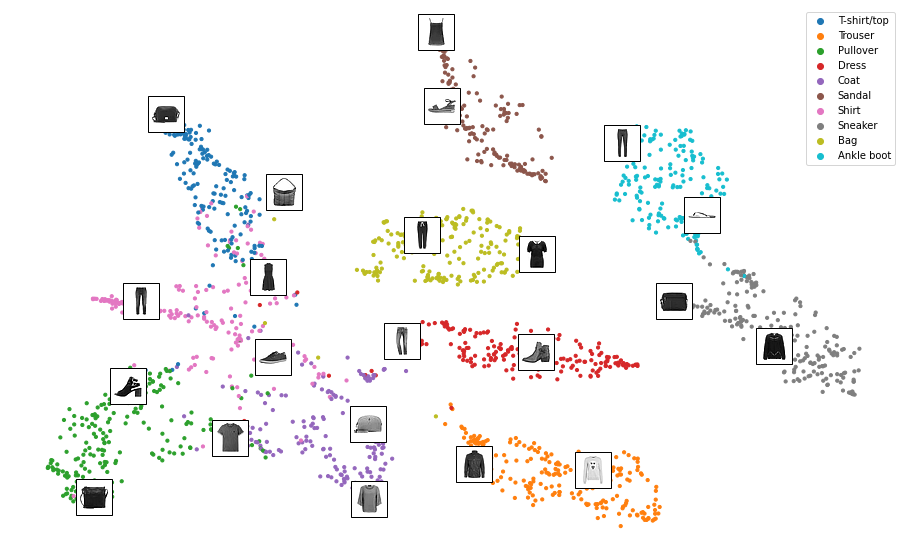

In [44]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results_06[:,0],tsne_results_06[:,1], c=y_valid[:2000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_06):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

### Exp 6 0.9323 > Exp 9 0.8722 accuracy, Dropout 0.5 does not improve accuracy

- Best model so far: Exp. 6 at 0.9323

- Next: Additional Conv2D Layer based on Exp 6


## Experiment 10

- Conv2D with 4 Layers (128, 256, 512, 1024, Kernel size 3, Padding same)
- DNN with 2 layers (384, 768)
- Batch Normalization
- Dropout(0.2)
- L2 Regularization(0.01)

In [55]:
k.clear_session()
model_10 = Sequential([
  Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.2),
  Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.2),
  Conv2D(filters=512, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.2),    
  Conv2D(filters=1024, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.2),    
  Flatten(),
  Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.01)),
  BatchNormalization(),
  Dropout(0.2),
  Dense(units=768,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.01)),
  BatchNormalization(),
  Dropout(0.2),
  Dense(units=10, activation=tf.nn.softmax)       
])

In [56]:
model_10.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 128)      512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 256)        0

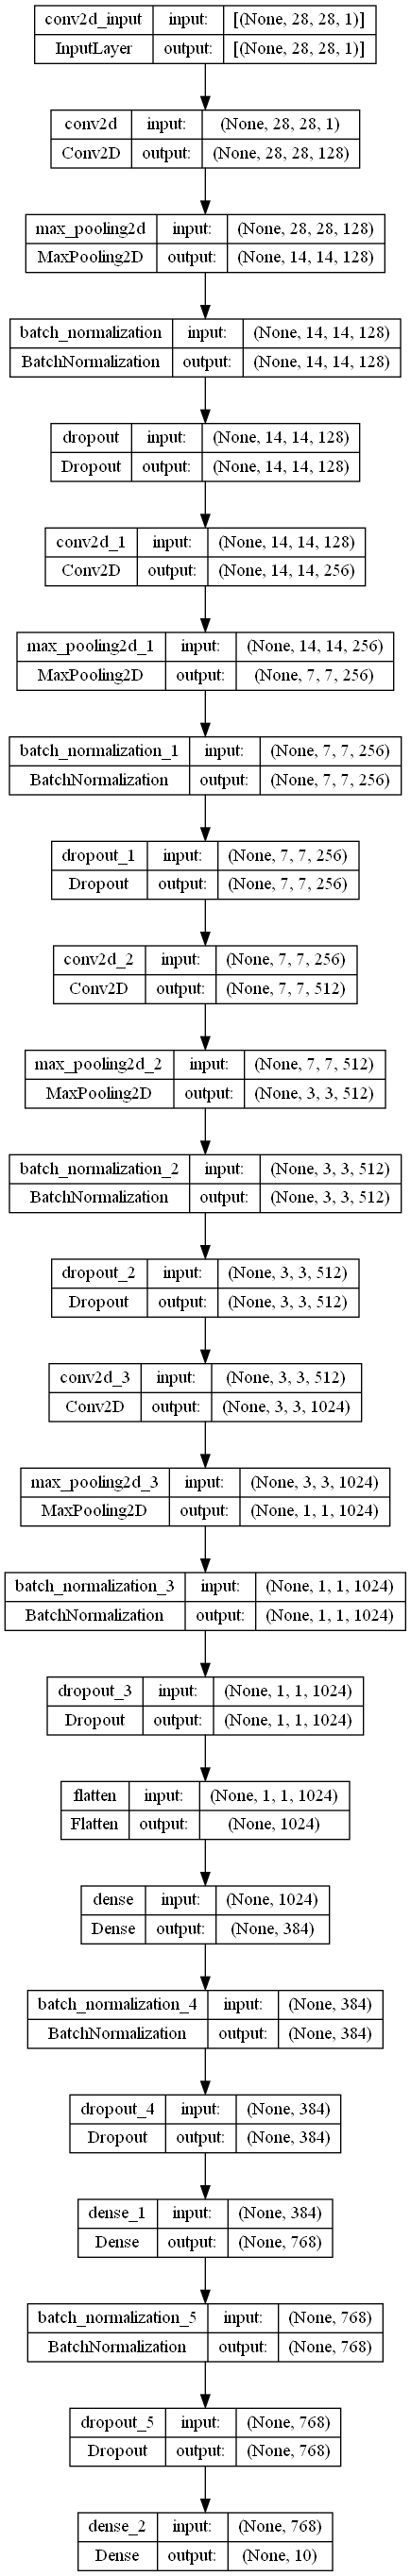

In [57]:
keras.utils.plot_model(model_10, "FASHION-MNIST_EXP-10.png", show_shapes=True) 

In [58]:
model_10.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [59]:
history_10 = model_10.fit(x_train
                    ,y_train
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid, y_valid)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("FASHION-MNIST_EXP-10.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
                    ]                                                                                                           
                   )

Epoch 1/200
844/844 [==============================] - 18s 19ms/step - loss: 2.4406 - accuracy: 0.8175 - val_loss: 0.6048 - val_accuracy: 0.8593
Epoch 2/200
844/844 [==============================] - 16s 19ms/step - loss: 0.5409 - accuracy: 0.8771 - val_loss: 0.5737 - val_accuracy: 0.8550
Epoch 3/200
844/844 [==============================] - 16s 19ms/step - loss: 0.4960 - accuracy: 0.8919 - val_loss: 0.4531 - val_accuracy: 0.9012
Epoch 4/200
844/844 [==============================] - 15s 18ms/step - loss: 0.4584 - accuracy: 0.9008 - val_loss: 0.4622 - val_accuracy: 0.8932
Epoch 5/200
844/844 [==============================] - 16s 19ms/step - loss: 0.4336 - accuracy: 0.9075 - val_loss: 0.4953 - val_accuracy: 0.8965
Epoch 6/200
844/844 [==============================] - 17s 20ms/step - loss: 0.4246 - accuracy: 0.9140 - val_loss: 0.4195 - val_accuracy: 0.9062
Epoch 7/200
844/844 [==============================] - 16s 20ms/step - loss: 0.4093 - accuracy: 0.9188 - val_loss: 0.5446 - val_ac

In [ ]:
# 313/313 [==============================] - 3s 6ms/step - loss: 0.3276 - accuracy: 0.9322
# Test acc: 0.932

In [88]:
model_10 = tf.keras.models.load_model("FASHION-MNIST_EXP-10.h5") # batch normalization, L2 reg 0.01, dropout 0.2
print(f"Test acc: {model_10.evaluate(x_test, y_test)[1]:.3f}")

313/313 [==============================] - 2s 6ms/step - loss: 0.3408 - accuracy: 0.9263
Test acc: 0.926


In [89]:
history_10_dict = history_10.history
history_10_df=pd.DataFrame(history_10_dict)
history_10_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
16  0.253     0.958     0.390         0.913
17  0.228     0.961     0.343         0.931
18  0.214     0.963     0.320         0.931
19  0.203     0.965     0.349         0.930
20  0.209     0.966     0.360         0.930

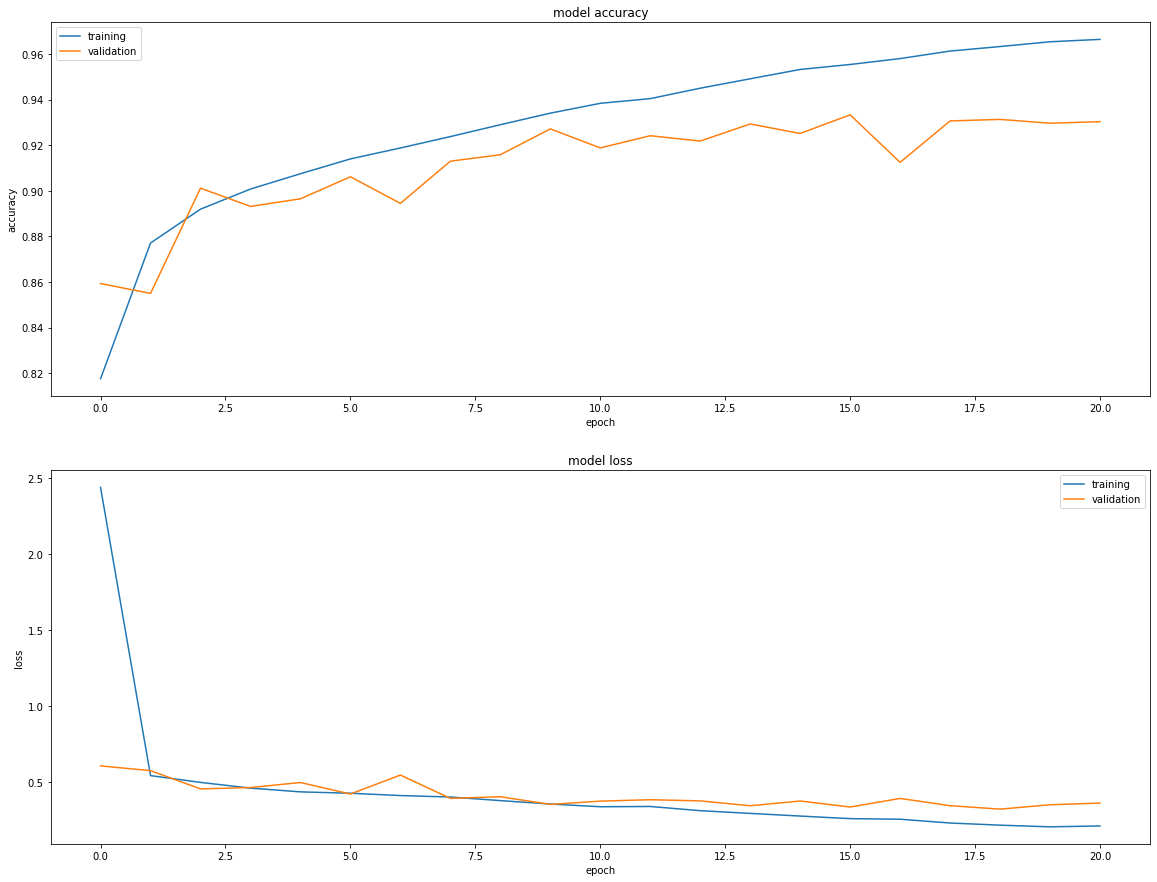

In [90]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_10.history['accuracy'], history_10.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_10.history['loss'], history_10.history['val_loss'], 'loss', 212)

In [91]:
pred_10 = model_10.predict(x_test)
pred_10_cm=np.argmax(pred_10, axis=1)
print_validation_report(y_test, pred_10_cm)

313/313 [==============================] - 1s 4ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      1000
           1       1.00      0.98      0.99      1000
           2       0.89      0.88      0.89      1000
           3       0.89      0.94      0.92      1000
           4       0.85      0.93      0.89      1000
           5       1.00      0.97      0.98      1000
           6       0.80      0.79      0.80      1000
           7       0.95      0.99      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.98      0.97      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

Accuracy Score: 0.9263
Root Mean Square Error: 1.0152832117197643


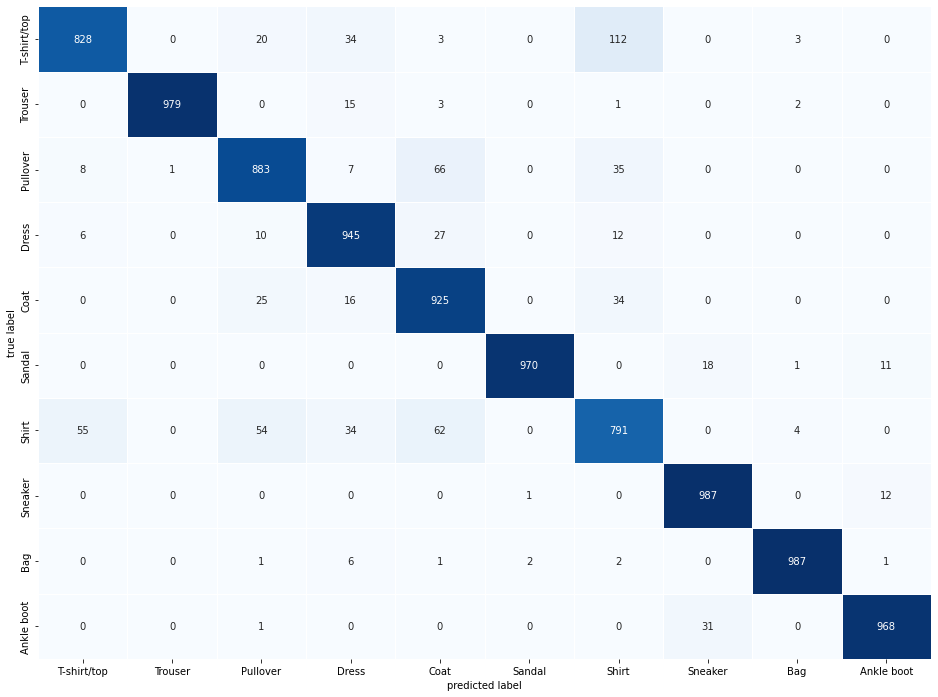

In [92]:
plot_confusion_matrix(y_test,pred_10_cm)

In [93]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred_10[0:20], columns = class_names)
df.style.format("{:.2%}").background_gradient(cmap=cm)

### Exp 6 0.9323 > Exp 10 0.9322 accuracy, extra Conv2D layer is about the same (accuracy is 0.0001 less),
### doesn't improve accuracy despite almost twice as many parameters

- Best model so far: Exp. 6 at 0.9323

- Next: Pre-Trained Models (next notebook)

- BONUS: stacked CNNs (Exp 11 below)

## Experiment 11 - Conv2D stacked 3x3 layers

- Conv2D with 3 stacks of 3 Layers (Kernel size 3, Padding same)
- DNN with 2 layers (384, 768)
- Batch Normalization
- Dropout(0.2)
- L2 Regularization(0.01)

In [73]:
k.clear_session()
model_11 = Sequential([
  Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
  Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.2),
  Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.2),
  Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  Conv2D(filters=32, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.2),    
  Flatten(),
  Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.01)),
  BatchNormalization(),
  Dropout(0.2),
  Dense(units=768,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.01)),
  BatchNormalization(),
  Dropout(0.2),
  Dense(units=10, activation=tf.nn.softmax)       
])

In [74]:
model_11.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       295040    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 256)       295168    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 256)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 256)      1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 14, 14, 256)       0

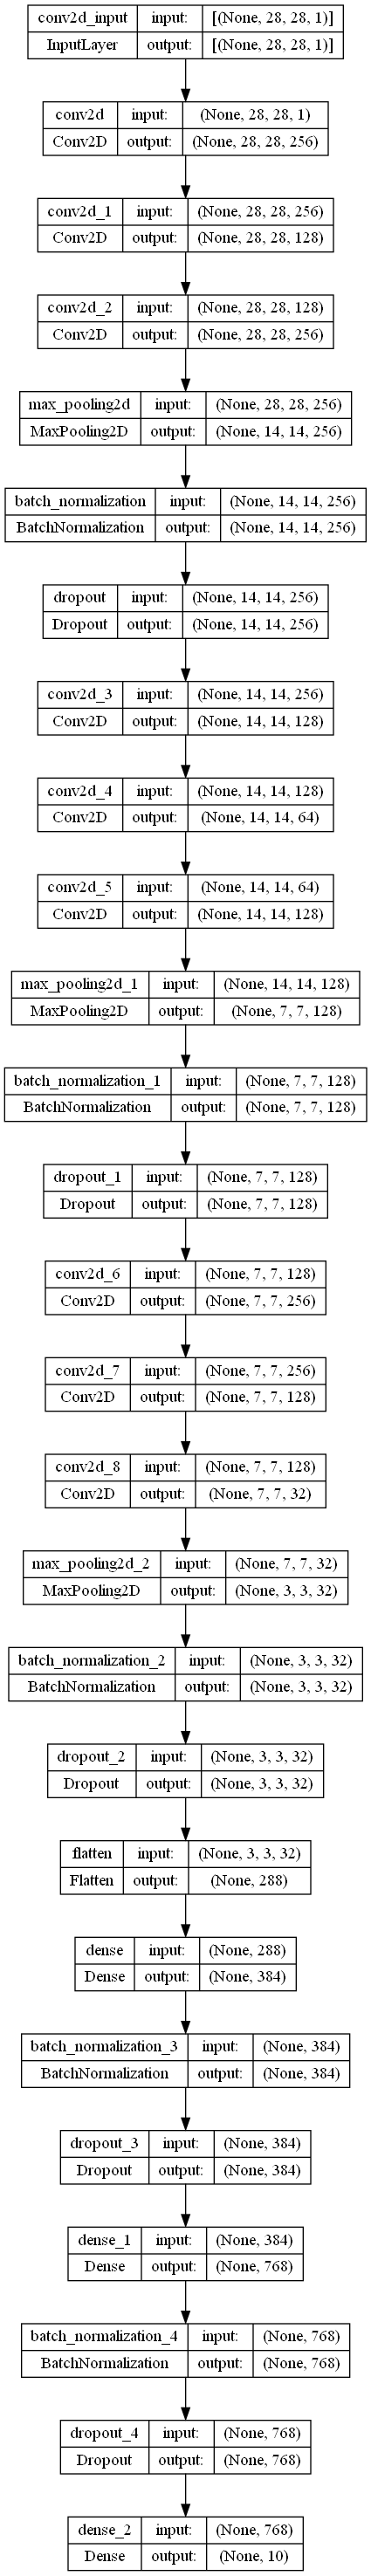

In [75]:
keras.utils.plot_model(model_11, "FASHION-MNIST_EXP-11.png", show_shapes=True) 

In [76]:
model_11.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [77]:
history_11 = model_11.fit(x_train
                    ,y_train
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid, y_valid)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("FASHION-MNIST_EXP-11.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
                    ]                                                                                                           
                   )

Epoch 1/200
844/844 [==============================] - 27s 29ms/step - loss: 2.7768 - accuracy: 0.7782 - val_loss: 0.6474 - val_accuracy: 0.8547
Epoch 2/200
844/844 [==============================] - 23s 28ms/step - loss: 0.5608 - accuracy: 0.8649 - val_loss: 0.5216 - val_accuracy: 0.8697
Epoch 3/200
844/844 [==============================] - 24s 29ms/step - loss: 0.4923 - accuracy: 0.8831 - val_loss: 0.4804 - val_accuracy: 0.8948
Epoch 4/200
844/844 [==============================] - 23s 27ms/step - loss: 0.4561 - accuracy: 0.8935 - val_loss: 0.4915 - val_accuracy: 0.8908
Epoch 5/200
844/844 [==============================] - 23s 28ms/step - loss: 0.4312 - accuracy: 0.9000 - val_loss: 0.4480 - val_accuracy: 0.8882
Epoch 6/200
844/844 [==============================] - 23s 28ms/step - loss: 0.4036 - accuracy: 0.9091 - val_loss: 0.3624 - val_accuracy: 0.9167
Epoch 7/200
844/844 [==============================] - 24s 28ms/step - loss: 0.3810 - accuracy: 0.9133 - val_loss: 0.3490 - val_ac

In [78]:
model_11 = tf.keras.models.load_model("FASHION-MNIST_EXP-11.h5") # batch normalization, L2 reg 0.01, dropout 0.2
print(f"Test acc: {model_11.evaluate(x_test, y_test)[1]:.3f}")

313/313 [==============================] - 3s 7ms/step - loss: 0.2698 - accuracy: 0.9370
Test acc: 0.937


In [79]:
history_11_dict = history_11.history
history_11_df=pd.DataFrame(history_11_dict)
history_11_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
23  0.121     0.976     0.270         0.941
24  0.119     0.976     0.270         0.941
25  0.112     0.978     0.265         0.941
26  0.104     0.980     0.281         0.938
27  0.104     0.980     0.310         0.937

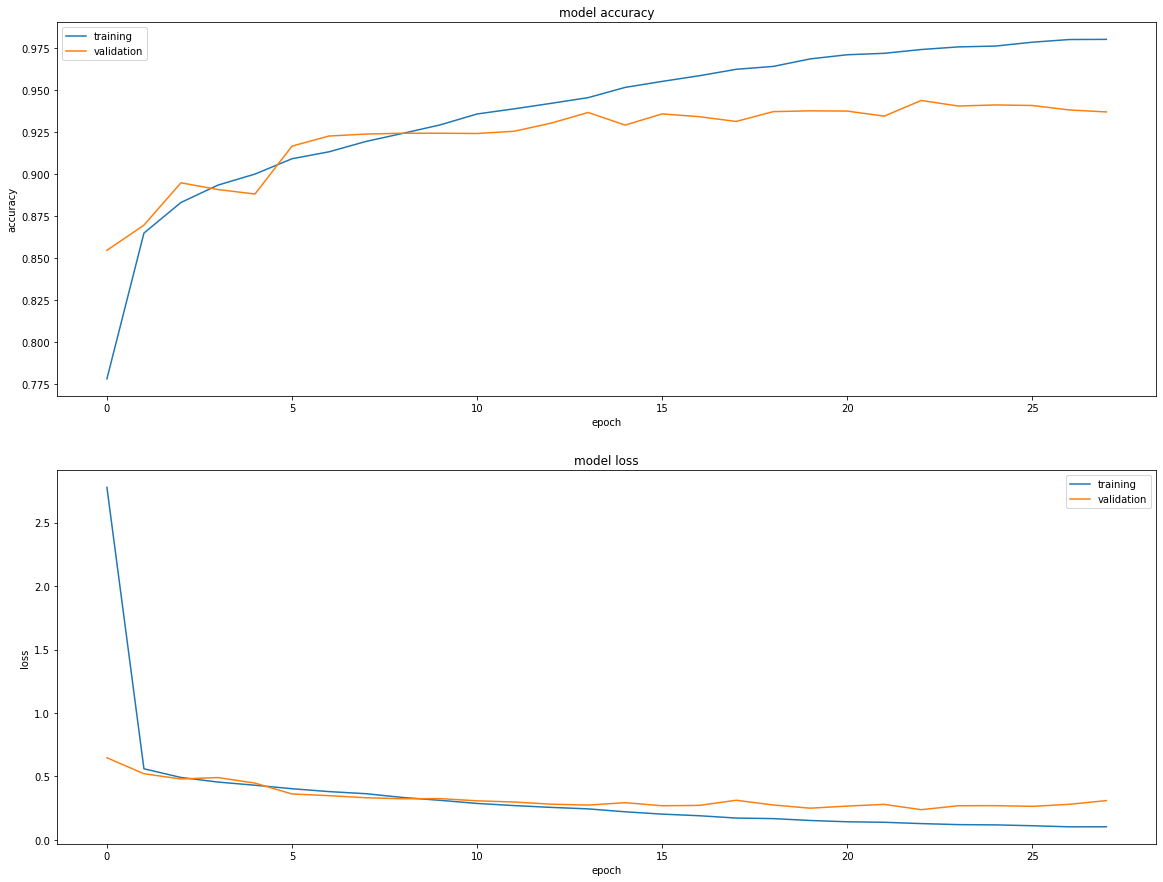

In [80]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_11.history['accuracy'], history_11.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_11.history['loss'], history_11.history['val_loss'], 'loss', 212)

In [81]:
pred_11 = model_11.predict(x_test)
pred_11_cm=np.argmax(pred_11, axis=1)
print_validation_report(y_test, pred_11_cm)

313/313 [==============================] - 2s 6ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.91      0.86      0.89      1000
           1       1.00      0.99      0.99      1000
           2       0.92      0.90      0.91      1000
           3       0.92      0.95      0.93      1000
           4       0.90      0.92      0.91      1000
           5       0.99      0.98      0.99      1000
           6       0.79      0.82      0.81      1000
           7       0.96      0.99      0.97      1000
           8       0.99      0.98      0.99      1000
           9       0.98      0.97      0.97      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

Accuracy Score: 0.937
Root Mean Square Error: 0.9784170889758621


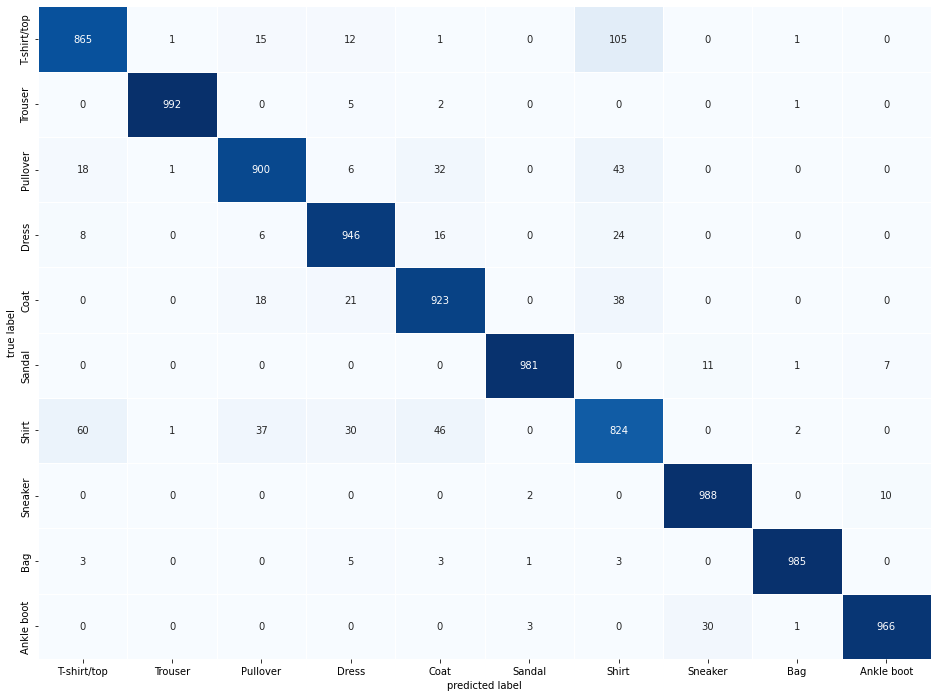

In [82]:
plot_confusion_matrix(y_test,pred_11_cm)

In [98]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred_11[0:20], columns = class_names)
df.style.format("{:.2%}").background_gradient(cmap=cm)

In [99]:
layer_names = []
for layer in model_11.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'conv2d_1',
 'conv2d_2',
 'max_pooling2d',
 'batch_normalization',
 'dropout',
 'conv2d_3',
 'conv2d_4',
 'conv2d_5',
 'max_pooling2d_1',
 'batch_normalization_1',
 'dropout_1',
 'conv2d_6',
 'conv2d_7',
 'conv2d_8',
 'max_pooling2d_2',
 'batch_normalization_2',
 'dropout_2',
 'flatten',
 'dense',
 'batch_normalization_3',
 'dropout_3',
 'dense_1',
 'batch_normalization_4',
 'dropout_4',
 'dense_2']

In [85]:
len(layer_names)

26

In [24]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model_11.layers[:26]]
# Creates a model that will return these outputs, given the model input:
activation_model_11 = tf.keras.models.Model(inputs=model_11.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations_11 = activation_model_11.predict(x_valid[:500])
dense_layer_activations_11 = activations_11[-4]
output_layer_activations_11 = activations_11[-1]

16/16 [==============================] - 1s 31ms/step


ResourceExhaustedError: OOM when allocating tensor with shape[500,14,14,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:ConcatV2] name: concat

In [36]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_11 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_11 = tsne_11.fit_transform(dense_layer_activations_11)

# Scaling
tsne_results_11 = (tsne_results_11 - tsne_results_11.min()) / (tsne_results_11.max() - tsne_results_11.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 0.153s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.318236


C:\Users\Reed\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.374878
[t-SNE] KL divergence after 300 iterations: 1.019683


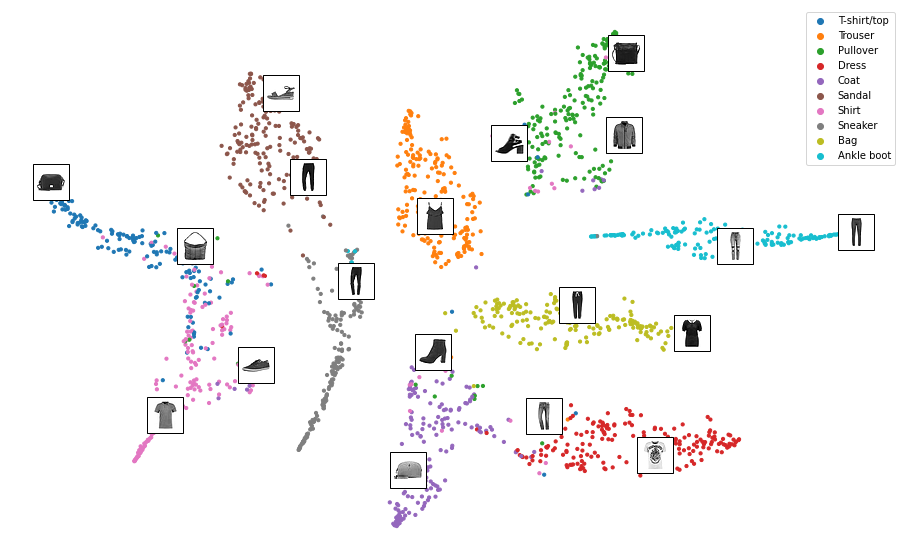

In [37]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results_11[:,0],tsne_results_11[:,1], c=y_valid[:500], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_11):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## Experiment 12  - L2 Reg high/low from 0.01: 0.001 (low)

- Conv2D with 3 stacks of 3 Layers (Kernel size 3, Padding same)
- DNN with 2 layers (384, 768)
- Batch Normalization
- Dropout(0.2)
- L2 Regularization(0.001) - modded from Exp 11

In [100]:
k.clear_session()
model_12 = Sequential([
  Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
  Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.2),
  Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.2),
  Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  Conv2D(filters=32, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.2),    
  Flatten(),
  Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.2),
  Dense(units=768,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.2),
  Dense(units=10, activation=tf.nn.softmax)       
])

In [101]:
model_12.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       295040    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 256)       295168    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 256)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 256)      1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 14, 14, 256)       0

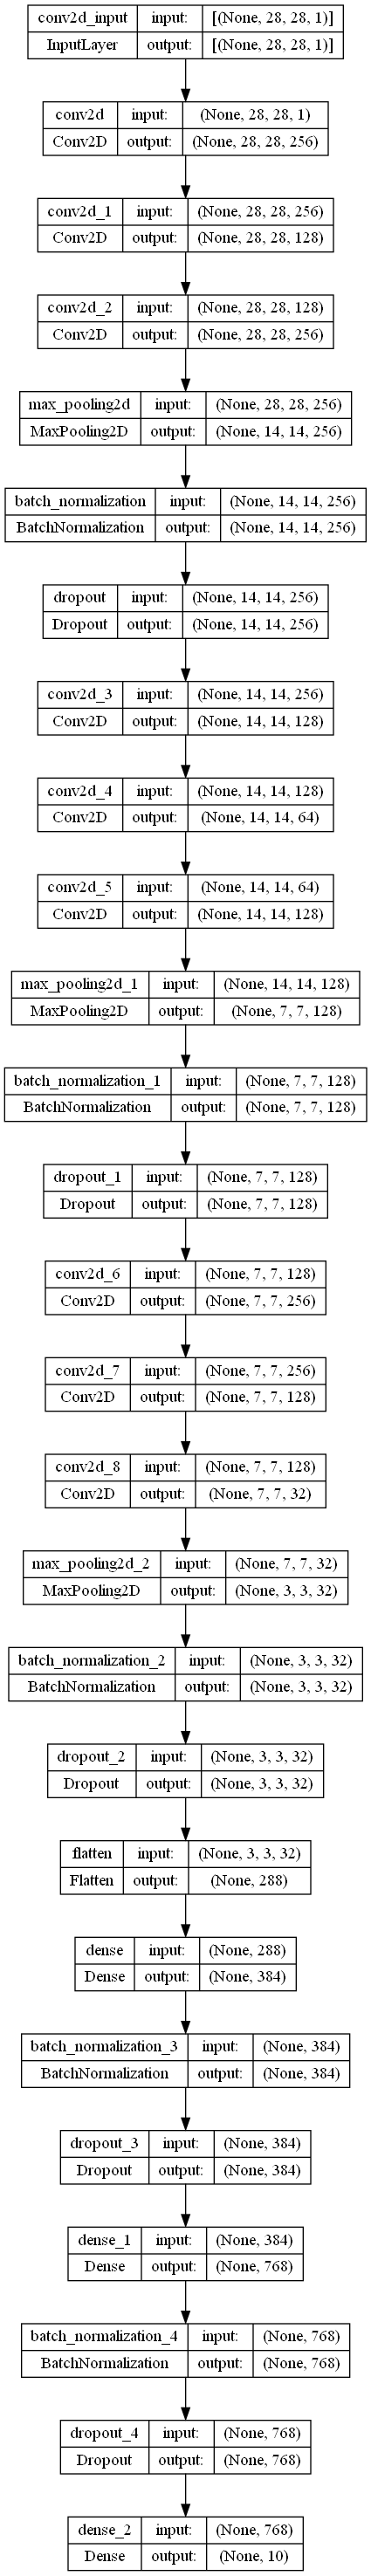

In [102]:
keras.utils.plot_model(model_12, "FASHION-MNIST_EXP-12.png", show_shapes=True) 

In [103]:
model_12.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [104]:
history_12 = model_12.fit(x_train
                    ,y_train
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid, y_valid)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("FASHION-MNIST_EXP-12.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
                    ]                                                                                                           
                   )

Epoch 1/200
844/844 [==============================] - 25s 28ms/step - loss: 1.2986 - accuracy: 0.7786 - val_loss: 1.1942 - val_accuracy: 0.7772
Epoch 2/200
844/844 [==============================] - 24s 28ms/step - loss: 0.6775 - accuracy: 0.8649 - val_loss: 0.5534 - val_accuracy: 0.8635
Epoch 3/200
844/844 [==============================] - 23s 28ms/step - loss: 0.4569 - accuracy: 0.8874 - val_loss: 0.4388 - val_accuracy: 0.8872
Epoch 4/200
844/844 [==============================] - 24s 29ms/step - loss: 0.3850 - accuracy: 0.8956 - val_loss: 0.3553 - val_accuracy: 0.9028
Epoch 5/200
844/844 [==============================] - 24s 28ms/step - loss: 0.3491 - accuracy: 0.9033 - val_loss: 0.3276 - val_accuracy: 0.9082
Epoch 6/200
844/844 [==============================] - 24s 28ms/step - loss: 0.3286 - accuracy: 0.9101 - val_loss: 0.3045 - val_accuracy: 0.9160
Epoch 7/200
844/844 [==============================] - 23s 28ms/step - loss: 0.3102 - accuracy: 0.9152 - val_loss: 0.2900 - val_ac

In [105]:
model_12 = tf.keras.models.load_model("FASHION-MNIST_EXP-12.h5") # batch normalization, L2 reg 0.01, dropout 0.2
print(f"Test acc: {model_12.evaluate(x_test, y_test)[1]:.3f}")

313/313 [==============================] - 3s 7ms/step - loss: 0.2472 - accuracy: 0.9362
Test acc: 0.936


In [108]:
history_12_dict = history_12.history
history_12_df=pd.DataFrame(history_12_dict)
history_12_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
16  0.166     0.958     0.239         0.934
17  0.154     0.962     0.240         0.937
18  0.151     0.963     0.237         0.938
19  0.135     0.967     0.266         0.933
20  0.128     0.970     0.246         0.938

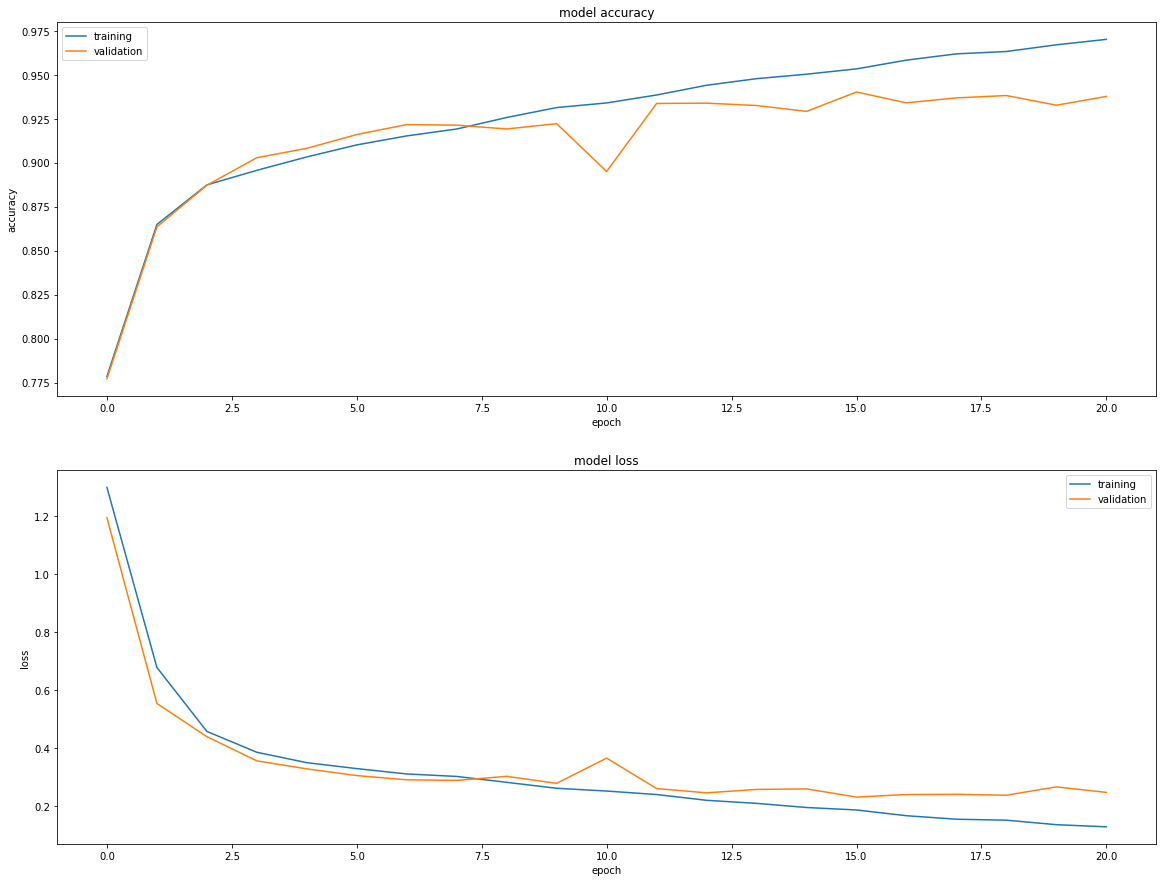

In [110]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_12.history['accuracy'], history_12.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_12.history['loss'], history_12.history['val_loss'], 'loss', 212)

In [111]:
pred_12 = model_12.predict(x_test)
pred_12_cm=np.argmax(pred_12, axis=1)
print_validation_report(y_test, pred_12_cm)

313/313 [==============================] - 2s 5ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.85      0.88      1000
           1       1.00      0.99      0.99      1000
           2       0.91      0.91      0.91      1000
           3       0.93      0.95      0.94      1000
           4       0.89      0.93      0.91      1000
           5       0.98      0.99      0.99      1000
           6       0.81      0.81      0.81      1000
           7       0.97      0.97      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.98      0.97      0.97      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

Accuracy Score: 0.9362
Root Mean Square Error: 0.9919173352653939


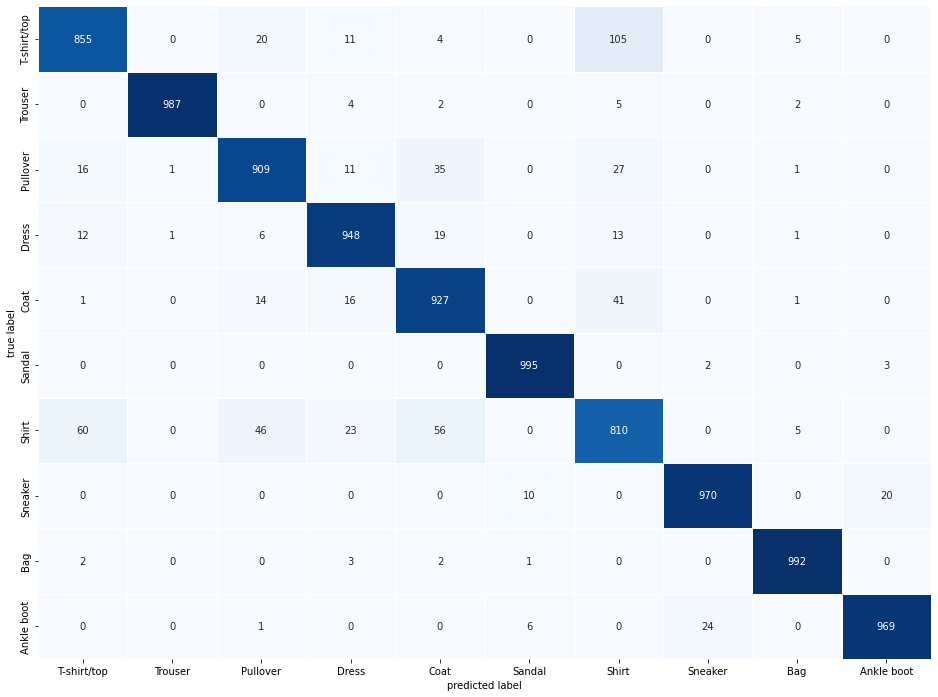

In [113]:
plot_confusion_matrix(y_test,pred_12_cm)

In [114]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred_12[0:20], columns = class_names)
df.style.format("{:.2%}").background_gradient(cmap=cm)

## Experiment 13  - L2 Reg high/low from 0.01: 0.1 (high)

- Conv2D with 3 stacks of 3 Layers (Kernel size 3, Padding same)
- DNN with 2 layers (384, 768)
- Batch Normalization
- Dropout(0.2)
- L2 Regularization(0.1) - modded from Exp 12

In [141]:
k.clear_session()
model_13 = Sequential([
  Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
  Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.2),
  Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.2),
  Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  Conv2D(filters=32, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.2),    
  Flatten(),
  Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.1)),
  BatchNormalization(),
  Dropout(0.2),
  Dense(units=768,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.1)),
  BatchNormalization(),
  Dropout(0.2),
  Dense(units=10, activation=tf.nn.softmax)       
])

In [142]:
model_13.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       295040    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 256)       295168    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 256)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 256)      1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 14, 14, 256)       0

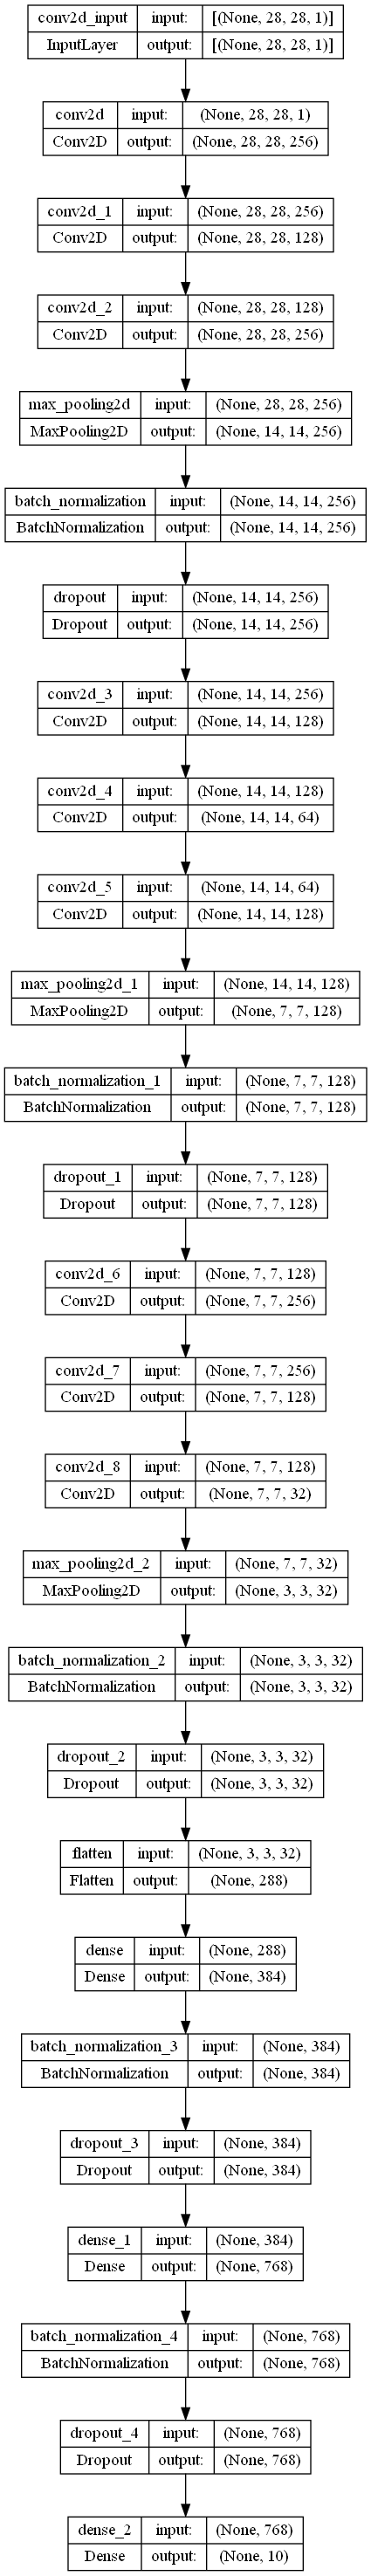

In [143]:
keras.utils.plot_model(model_13, "FASHION-MNIST_EXP-13.png", show_shapes=True) 

In [144]:
model_13.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [145]:
history_13 = model_13.fit(x_train
                    ,y_train
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid, y_valid)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("FASHION-MNIST_EXP-13.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
                    ]                                                                                                           
                   )

Epoch 1/200
844/844 [==============================] - 28s 31ms/step - loss: 4.8826 - accuracy: 0.7727 - val_loss: 0.8778 - val_accuracy: 0.8410
Epoch 2/200
844/844 [==============================] - 26s 30ms/step - loss: 0.7619 - accuracy: 0.8553 - val_loss: 0.6175 - val_accuracy: 0.8715
Epoch 3/200
844/844 [==============================] - 25s 29ms/step - loss: 0.6280 - accuracy: 0.8750 - val_loss: 0.5976 - val_accuracy: 0.8785
Epoch 4/200
844/844 [==============================] - 24s 29ms/step - loss: 0.5677 - accuracy: 0.8880 - val_loss: 0.6665 - val_accuracy: 0.8772
Epoch 5/200
844/844 [==============================] - 23s 28ms/step - loss: 0.5202 - accuracy: 0.8960 - val_loss: 0.5629 - val_accuracy: 0.8863
Epoch 6/200
844/844 [==============================] - 23s 28ms/step - loss: 0.4771 - accuracy: 0.9049 - val_loss: 0.4270 - val_accuracy: 0.9157
Epoch 7/200
844/844 [==============================] - 23s 27ms/step - loss: 0.4409 - accuracy: 0.9112 - val_loss: 0.6625 - val_ac

In [146]:
model_13 = tf.keras.models.load_model("FASHION-MNIST_EXP-13.h5") # batch normalization, L2 reg 0.01, dropout 0.2
print(f"Test acc: {model_13.evaluate(x_test, y_test)[1]:.3f}")

313/313 [==============================] - 3s 7ms/step - loss: 0.3083 - accuracy: 0.9292
Test acc: 0.929


In [147]:
history_13_dict = history_13.history
history_13_df=pd.DataFrame(history_13_dict)
history_13_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
16  0.234     0.955     0.306         0.933
17  0.223     0.958     0.317         0.935
18  0.209     0.961     0.281         0.936
19  0.197     0.963     0.283         0.931
20  0.187     0.966     0.350         0.936

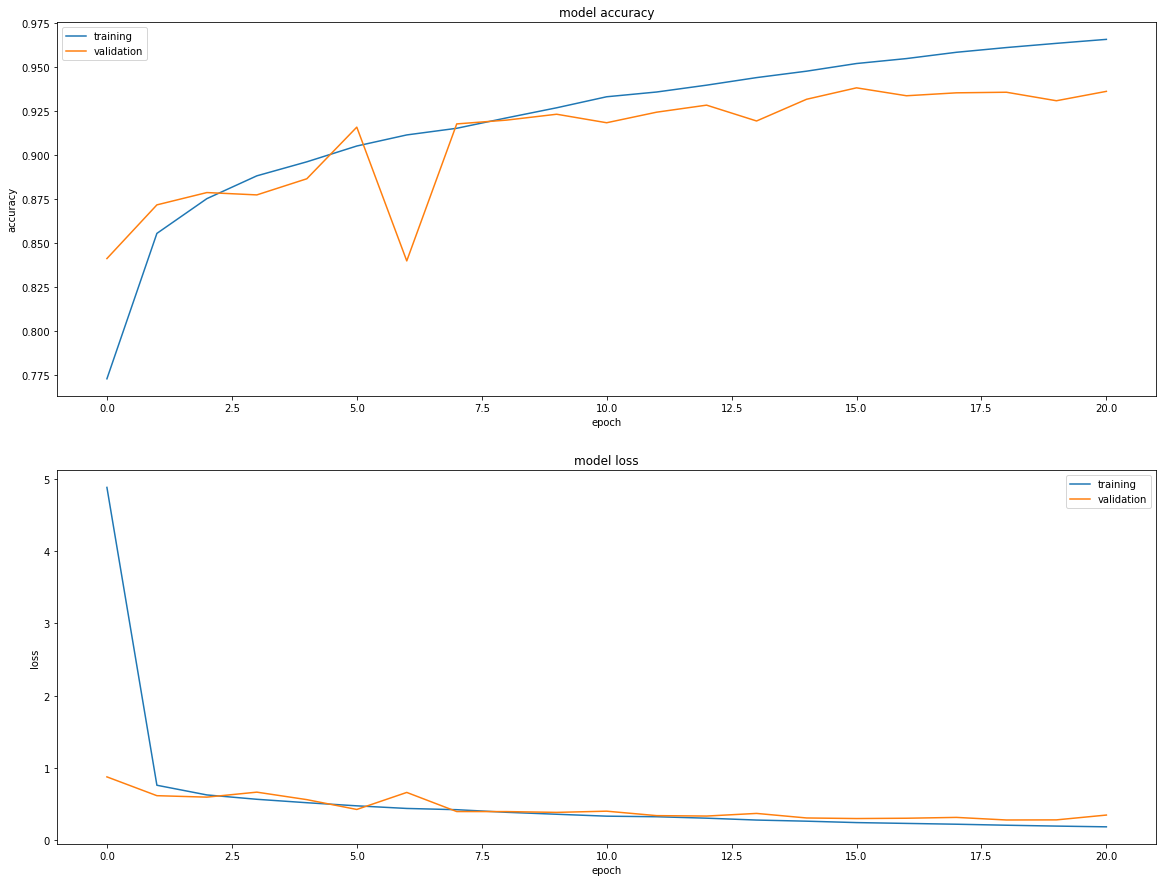

In [148]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_13.history['accuracy'], history_13.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_13.history['loss'], history_13.history['val_loss'], 'loss', 212)

In [149]:
pred_13 = model_13.predict(x_test)
pred_13_cm=np.argmax(pred_13, axis=1)
print_validation_report(y_test, pred_13_cm)

313/313 [==============================] - 2s 6ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1000
           1       1.00      0.98      0.99      1000
           2       0.90      0.90      0.90      1000
           3       0.93      0.94      0.93      1000
           4       0.86      0.94      0.90      1000
           5       0.99      0.99      0.99      1000
           6       0.87      0.72      0.79      1000
           7       0.93      0.99      0.96      1000
           8       0.99      0.98      0.99      1000
           9       0.99      0.93      0.96      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

Accuracy Score: 0.9292
Root Mean Square Error: 1.020588065773846


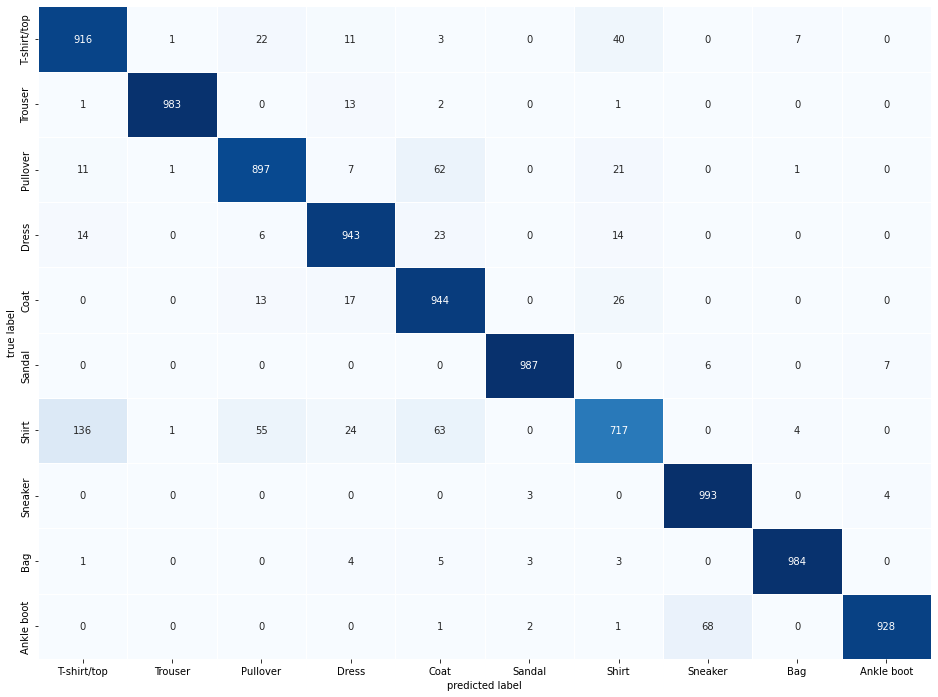

In [150]:
plot_confusion_matrix(y_test,pred_13_cm)

In [151]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred_13[0:20], columns = class_names)
df.style.format("{:.2%}").background_gradient(cmap=cm)

## Experiment 14 - dropout high/low from 0.2: 0.3 (high)

- Conv2D with 3 stacks of 3 Layers (Kernel size 3, Padding same)
- DNN with 2 layers (384, 768)
- Batch Normalization
- Dropout(0.3) - modded from exp 11
- L2 Regularization(0.01)

In [152]:
k.clear_session()
model_14 = Sequential([
  Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
  Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.3),
  Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.3),
  Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  Conv2D(filters=32, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.3),    
  Flatten(),
  Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.01)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=768,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.01)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)       
])

In [153]:
model_14.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       295040    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 256)       295168    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 256)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 256)      1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 14, 14, 256)       0

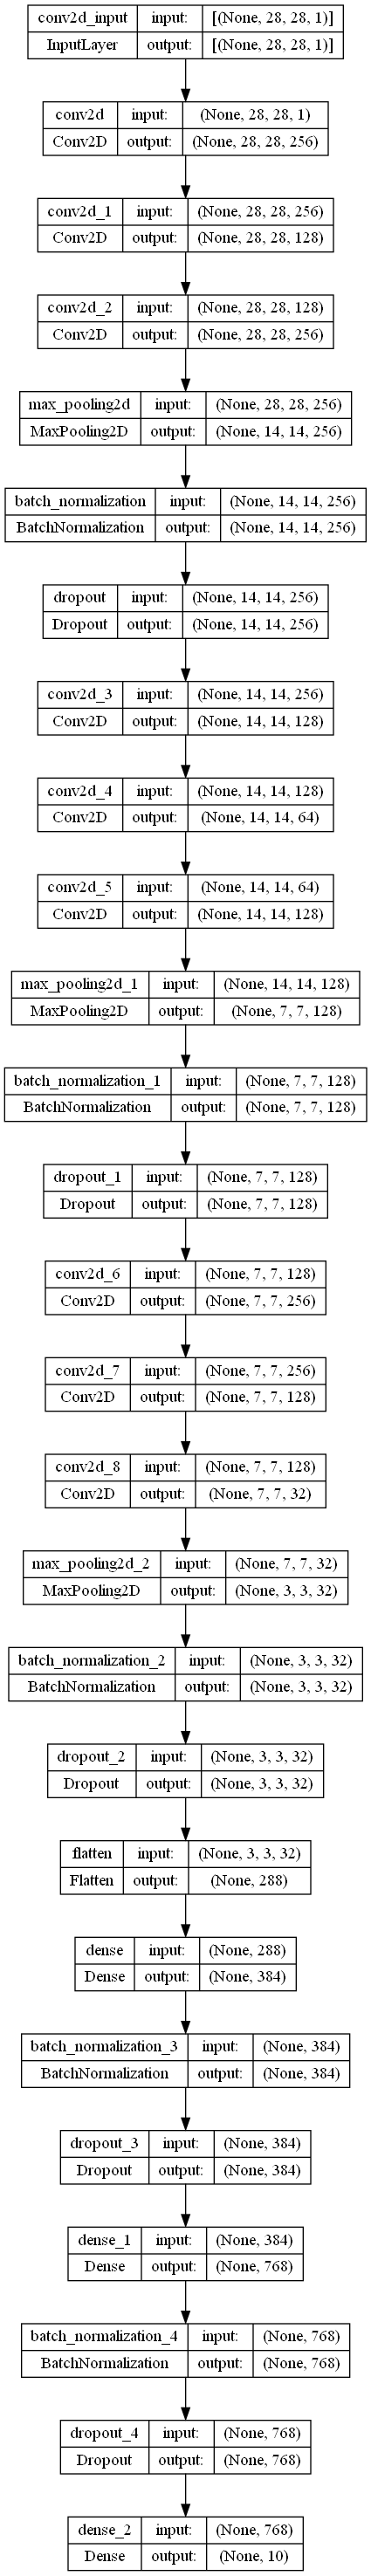

In [154]:
keras.utils.plot_model(model_14, "FASHION-MNIST_EXP-14.png", show_shapes=True) 

In [155]:
model_14.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [156]:
history_14 = model_14.fit(x_train
                    ,y_train
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid, y_valid)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("FASHION-MNIST_EXP-14.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
                    ]                                                                                                           
                   )

Epoch 1/200
844/844 [==============================] - 25s 27ms/step - loss: 3.0190 - accuracy: 0.7534 - val_loss: 0.8446 - val_accuracy: 0.8180
Epoch 2/200
844/844 [==============================] - 23s 27ms/step - loss: 0.6541 - accuracy: 0.8507 - val_loss: 0.5184 - val_accuracy: 0.8792
Epoch 3/200
844/844 [==============================] - 23s 27ms/step - loss: 0.5501 - accuracy: 0.8743 - val_loss: 0.7111 - val_accuracy: 0.8485
Epoch 4/200
844/844 [==============================] - 23s 28ms/step - loss: 0.5138 - accuracy: 0.8857 - val_loss: 0.5095 - val_accuracy: 0.8897
Epoch 5/200
844/844 [==============================] - 23s 27ms/step - loss: 0.4793 - accuracy: 0.8955 - val_loss: 0.4695 - val_accuracy: 0.8960
Epoch 6/200
844/844 [==============================] - 23s 28ms/step - loss: 0.4563 - accuracy: 0.9020 - val_loss: 0.4274 - val_accuracy: 0.9055
Epoch 7/200
844/844 [==============================] - 23s 27ms/step - loss: 0.4335 - accuracy: 0.9070 - val_loss: 0.4373 - val_ac

In [157]:
model_14 = tf.keras.models.load_model("FASHION-MNIST_EXP-14.h5") # batch normalization, L2 reg 0.01, dropout 0.2
print(f"Test acc: {model_14.evaluate(x_test, y_test)[1]:.3f}")

313/313 [==============================] - 2s 7ms/step - loss: 0.2799 - accuracy: 0.9366
Test acc: 0.937


In [158]:
history_14_dict = history_14.history
history_14_df=pd.DataFrame(history_14_dict)
history_14_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
25  0.172     0.969     0.308         0.941
26  0.162     0.972     0.273         0.942
27  0.152     0.973     0.301         0.941
28  0.157     0.974     0.289         0.940
29  0.142     0.976     0.298         0.936

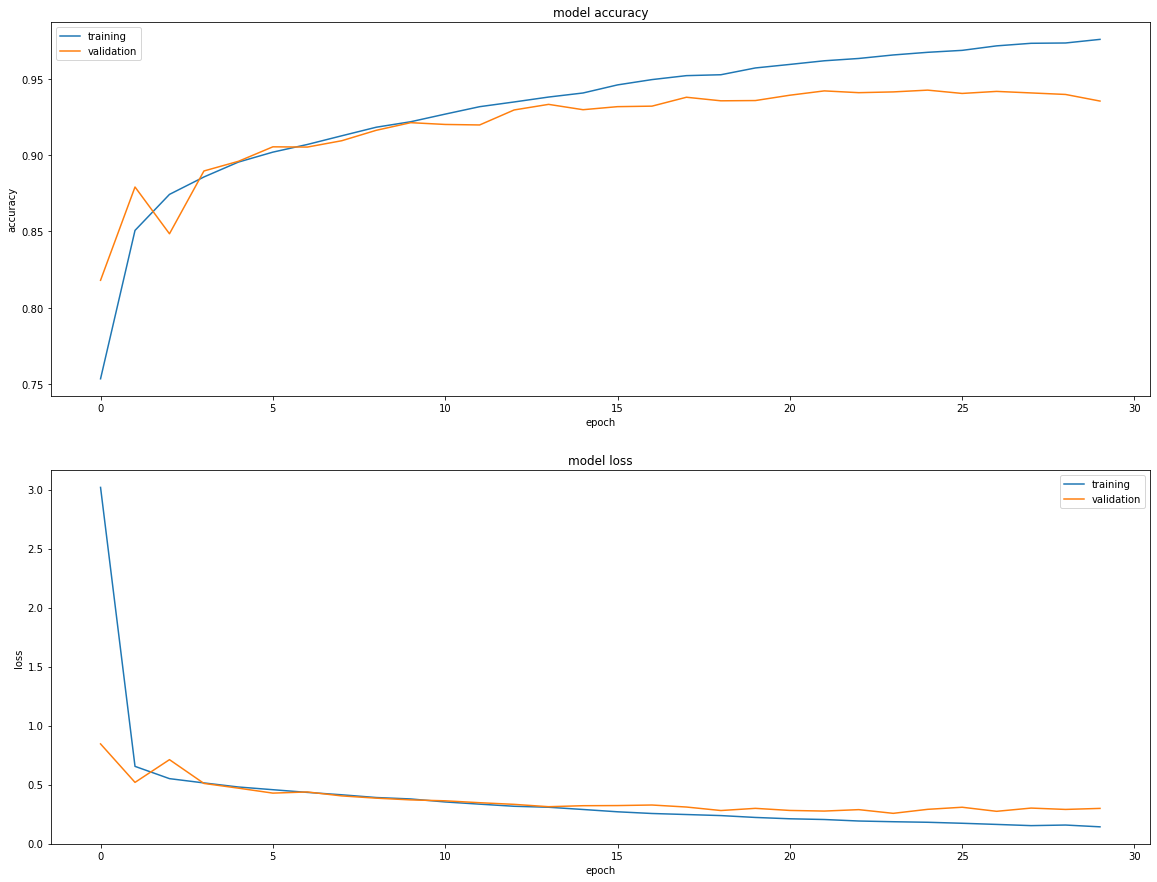

In [159]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_14.history['accuracy'], history_14.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_14.history['loss'], history_14.history['val_loss'], 'loss', 212)

In [160]:
pred_14 = model_14.predict(x_test)
pred_14_cm=np.argmax(pred_14, axis=1)
print_validation_report(y_test, pred_14_cm)

313/313 [==============================] - 2s 5ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1000
           1       1.00      0.99      0.99      1000
           2       0.88      0.94      0.91      1000
           3       0.95      0.93      0.94      1000
           4       0.90      0.90      0.90      1000
           5       0.99      0.99      0.99      1000
           6       0.82      0.81      0.81      1000
           7       0.97      0.97      0.97      1000
           8       1.00      0.98      0.99      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

Accuracy Score: 0.9366
Root Mean Square Error: 0.9736529155710468


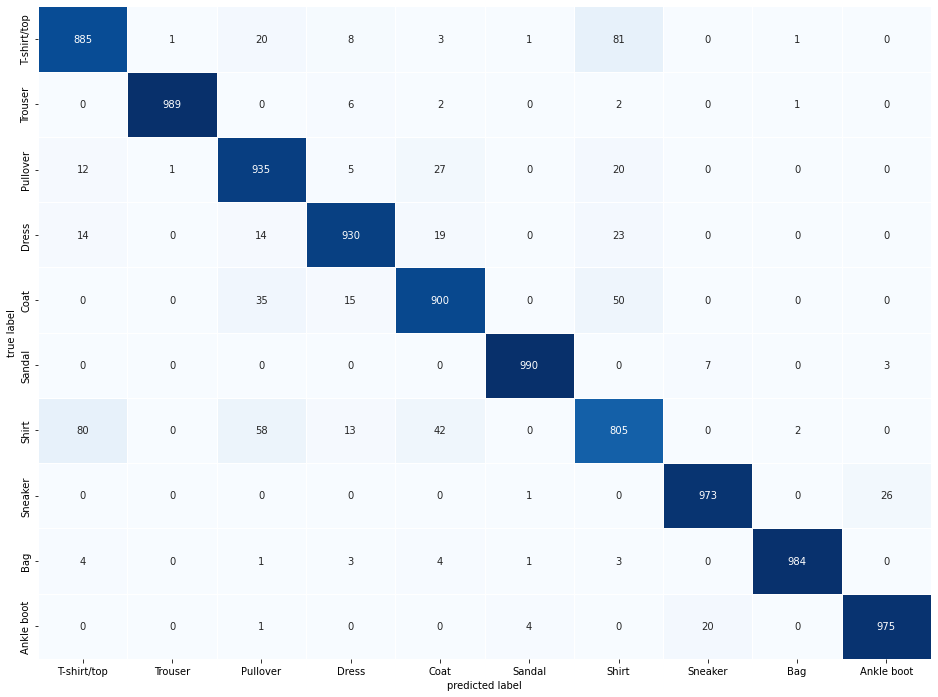

In [161]:
plot_confusion_matrix(y_test,pred_14_cm)

In [162]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred_14[0:20], columns = class_names)
df.style.format("{:.2%}").background_gradient(cmap=cm)

## Experiment 15 - dropout high/low from 0.2: 0.1 (low)

- Conv2D with 3 stacks of 3 Layers (Kernel size 3, Padding same)
- DNN with 2 layers (384, 768)
- Batch Normalization
- Dropout(0.3) - modded from exp 11
- L2 Regularization(0.01)

In [163]:
k.clear_session()
model_15 = Sequential([
  Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
  Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.1),
  Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.1),
  Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  Conv2D(filters=32, kernel_size=(3,3), strides=(1, 1), padding='Same', activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Dropout(0.1),    
  Flatten(),
  Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.01)),
  BatchNormalization(),
  Dropout(0.1),
  Dense(units=768,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.01)),
  BatchNormalization(),
  Dropout(0.1),
  Dense(units=10, activation=tf.nn.softmax)       
])

In [164]:
model_15.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       295040    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 256)       295168    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 256)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 256)      1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 14, 14, 256)       0

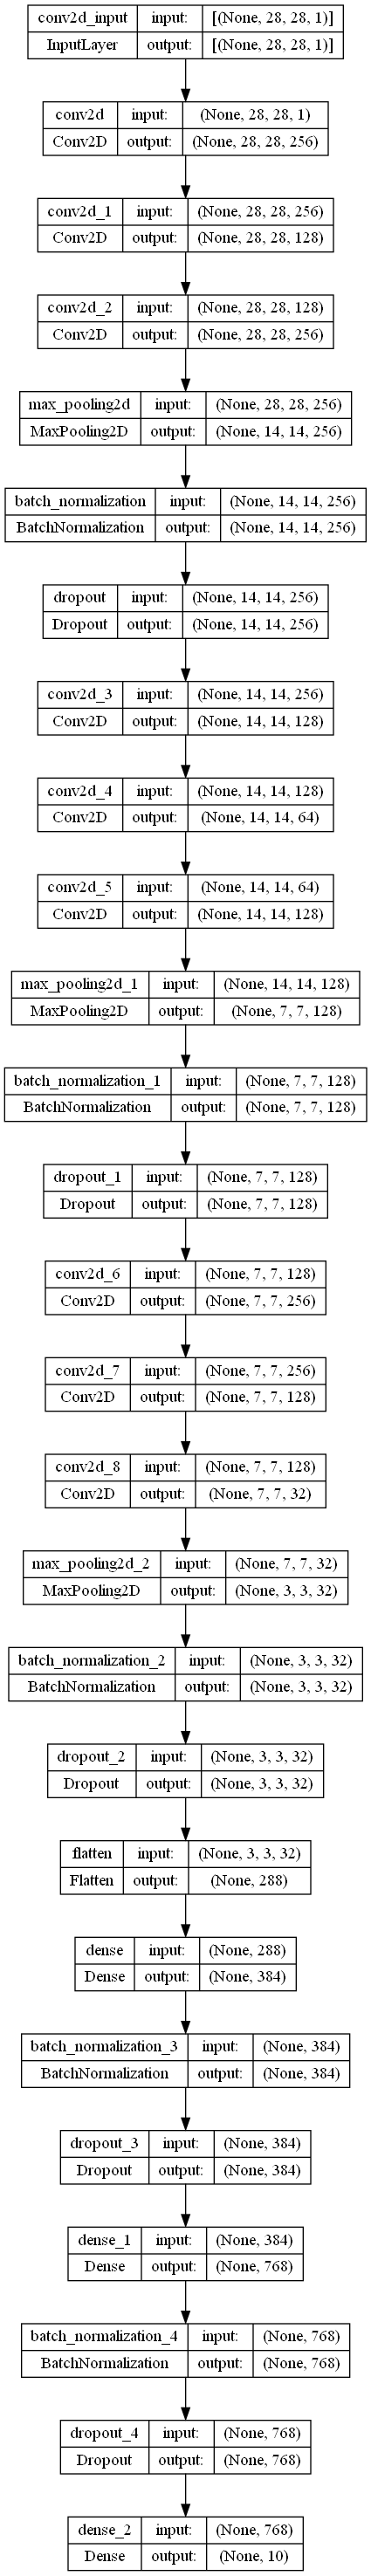

In [165]:
keras.utils.plot_model(model_15, "FASHION-MNIST_EXP-15.png", show_shapes=True) 

In [166]:
model_15.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [167]:
history_15 = model_15.fit(x_train
                    ,y_train
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid, y_valid)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("FASHION-MNIST_EXP-15.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
                    ]                                                                                                           
                   )

Epoch 1/200
844/844 [==============================] - 25s 27ms/step - loss: 2.4733 - accuracy: 0.7933 - val_loss: 0.7219 - val_accuracy: 0.8192
Epoch 2/200
844/844 [==============================] - 23s 27ms/step - loss: 0.5284 - accuracy: 0.8673 - val_loss: 0.4971 - val_accuracy: 0.8812
Epoch 3/200
844/844 [==============================] - 23s 27ms/step - loss: 0.4500 - accuracy: 0.8879 - val_loss: 0.4514 - val_accuracy: 0.8900
Epoch 4/200
844/844 [==============================] - 23s 27ms/step - loss: 0.4075 - accuracy: 0.8989 - val_loss: 0.4407 - val_accuracy: 0.8852
Epoch 5/200
844/844 [==============================] - 23s 27ms/step - loss: 0.3658 - accuracy: 0.9085 - val_loss: 0.4720 - val_accuracy: 0.8722
Epoch 6/200
844/844 [==============================] - 23s 28ms/step - loss: 0.3386 - accuracy: 0.9166 - val_loss: 0.3274 - val_accuracy: 0.9155
Epoch 7/200
844/844 [==============================] - 23s 28ms/step - loss: 0.3200 - accuracy: 0.9195 - val_loss: 0.2884 - val_ac

In [168]:
model_15 = tf.keras.models.load_model("FASHION-MNIST_EXP-15.h5") # batch normalization, L2 reg 0.01, dropout 0.2
print(f"Test acc: {model_15.evaluate(x_test, y_test)[1]:.3f}")

313/313 [==============================] - 3s 7ms/step - loss: 0.2545 - accuracy: 0.9304
Test acc: 0.930


In [169]:
history_15_dict = history_15.history
history_15_df=pd.DataFrame(history_15_dict)
history_15_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
16  0.128     0.970     0.260         0.933
17  0.119     0.973     0.284         0.935
18  0.109     0.975     0.254         0.938
19  0.100     0.978     0.262         0.939
20  0.095     0.979     0.277         0.935

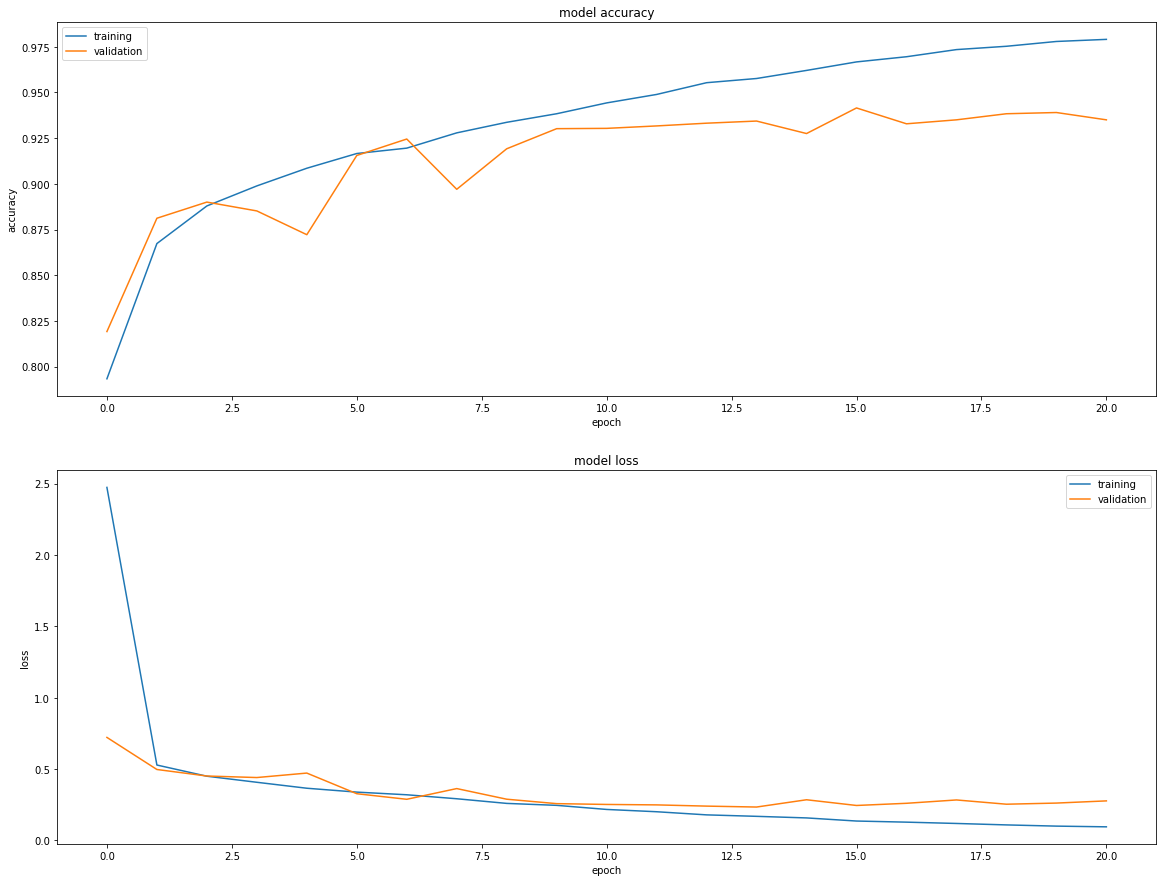

In [170]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_15.history['accuracy'], history_15.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_15.history['loss'], history_15.history['val_loss'], 'loss', 212)

In [171]:
pred_15 = model_15.predict(x_test)
pred_15_cm=np.argmax(pred_15, axis=1)
print_validation_report(y_test, pred_15_cm)

313/313 [==============================] - 2s 6ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1000
           1       0.99      0.98      0.99      1000
           2       0.88      0.92      0.90      1000
           3       0.91      0.95      0.93      1000
           4       0.91      0.88      0.89      1000
           5       0.99      0.99      0.99      1000
           6       0.81      0.80      0.80      1000
           7       0.96      0.97      0.97      1000
           8       0.99      0.98      0.99      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

Accuracy Score: 0.9304
Root Mean Square Error: 0.9881801455200363


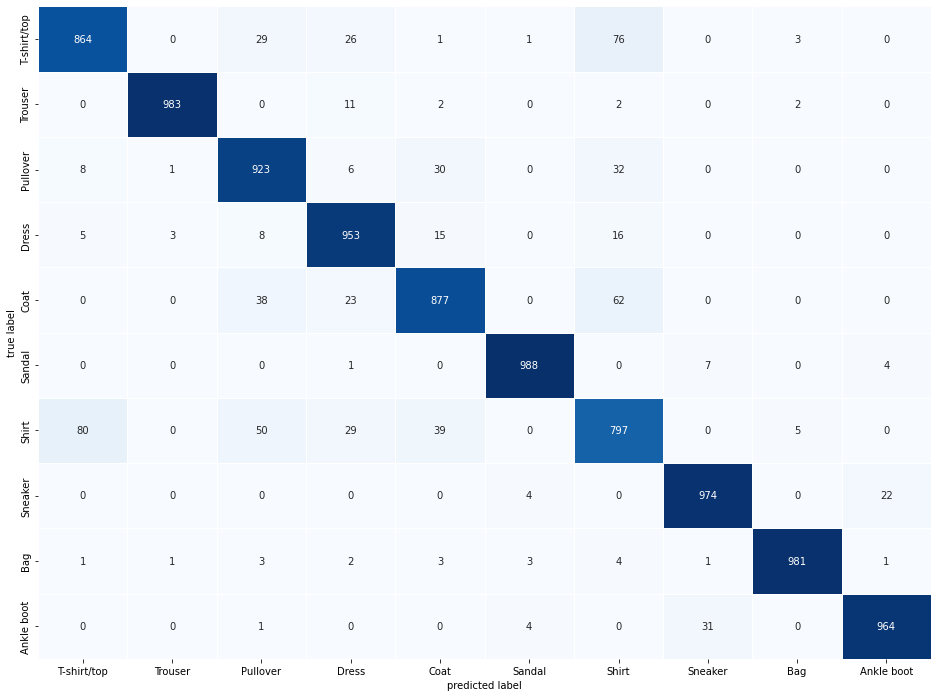

In [172]:
plot_confusion_matrix(y_test,pred_15_cm)

In [173]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred_15[0:20], columns = class_names)
df.style.format("{:.2%}").background_gradient(cmap=cm)

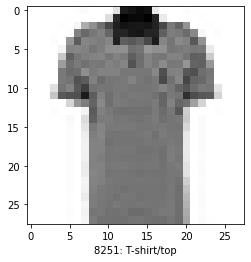

In [328]:
# original B/W image
img_num = random.randint(0,10000)
plt.imshow(x_test[img_num], cmap=plt.cm.binary)
plt.xlabel(str(img_num) + ": " + class_names[y_test[img_num][0]])
plt.show()